<a href="https://colab.research.google.com/github/jbp261/Cifar-10-using-Fully-Connected-DNN/blob/master/EE258_Project_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
10.6408560276
GPU (s):
1.85254716873
GPU speedup over CPU: 5x


# **Loading of the libraries**

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Loading the CIFAR-10 dataset
from keras.datasets import cifar10
from tensorflow import keras
from datetime import datetime

from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
print(tf.__version__)

1.11.0


# **Data Loading**

In [0]:
#Train test saperation of the dataset
(x_train_unshuffled, y_train_unshuffled), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 33s 0us/step


# **Data Visualization**

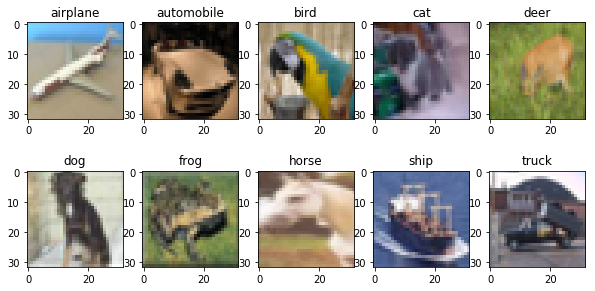

In [0]:
num_classes = 10 # total number of classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
               'horse', 'ship', 'truck'] # the class names in order

#Visualization of images from each class randomly
fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i)
    idx = np.where(y_train_unshuffled[:]==i)[0]
    features_idx = x_train_unshuffled[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    image = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(image)
    plt.grid(False)
plt.show()

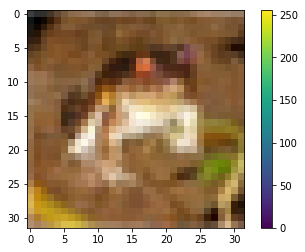

In [0]:
#Visualization of a single image from training data
plt.figure()
plt.imshow(x_train_unshuffled[0])
plt.colorbar()
plt.grid(False)

# **Exploring Train and Test Data**

**Knowing the training data types, dimensions and  distribution**

In [0]:
# Shape of the training and testing data
print('X_train_unshuffled', type(x_train_unshuffled), x_train_unshuffled.shape)
print('X_test', type(X_test), X_test.shape)

('X_train_unshuffled', <type 'numpy.ndarray'>, (50000, 32, 32, 3))
('X_test', <type 'numpy.ndarray'>, (10000, 32, 32, 3))


In [0]:
# Datatypes of the training and testing data
print('X_train_unshuffled element type', type(x_train_unshuffled[1,1,1,1]))
print('X_test element type', type(X_test[1,1,1,1]))

('X_train_unshuffled element type', <type 'numpy.uint8'>)
('X_test element type', <type 'numpy.uint8'>)


In [0]:
#Updating the datatype from uint8 to float32 for training and testing data
x_train_unshuffled = x_train_unshuffled.astype(np.float32)
X_test = X_test.astype(np.float32)
print('X_train_unshuffled element type', type(x_train_unshuffled[1,1,1,1]))
print('X_test element type', type(X_test[1,1,1,1]))

('X_train_unshuffled element type', <type 'numpy.float32'>)
('X_test element type', <type 'numpy.float32'>)


In [0]:
# Shape of the training and testing labels
print('y_train_unshuffled', type(y_train_unshuffled), y_train_unshuffled.shape)
print('y_test', type(y_test), y_test.shape)

('y_train_unshuffled', <type 'numpy.ndarray'>, (50000, 1))
('y_test', <type 'numpy.ndarray'>, (10000, 1))


In [0]:
# Datatype of the training and testing labels
print('y_train_unshuffled element type', type(y_train_unshuffled[1,0]))
print('y_test element type', type(y_test[1,0]))

('y_train_unshuffled element type', <type 'numpy.uint8'>)
('y_test element type', <type 'numpy.int64'>)


In [0]:
#Updating the datatype from uint8 to float32 for training and testing data
y_train_unshuffled = y_train_unshuffled.astype(np.int32)
y_test = y_test.astype(np.int32)
print('y_train_unshuffled element type', type(y_train_unshuffled[1,0]))
print('y_test element type', type(y_test[1,0]))

('y_train_unshuffled element type', <type 'numpy.int32'>)
('y_test element type', <type 'numpy.int32'>)


In [0]:
# Saperating training and validation data and labels with shuffle from unshuffled data and lables
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    x_train_unshuffled, y_train_unshuffled, test_size=0.1, random_state=42)

In [0]:
# Shape of the training and testing data
print('X_train', X_train.shape)
print('X_valid', X_valid.shape)

('X_train', (45000, 32, 32, 3))
('X_valid', (5000, 32, 32, 3))


In [0]:
# Shape of the training and testing labels
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)

('y_train', (45000, 1))
('y_valid', (5000, 1))


**Visualization of the distribution of datapoints among the classes**

In [0]:
# Getting the information on the number of classes and training data points distribution among classes
class_train, counts_train = np.unique(y_train_unshuffled, return_counts = True)
distribution_train = dict(zip(class_train, counts_train))
print(distribution_train )

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


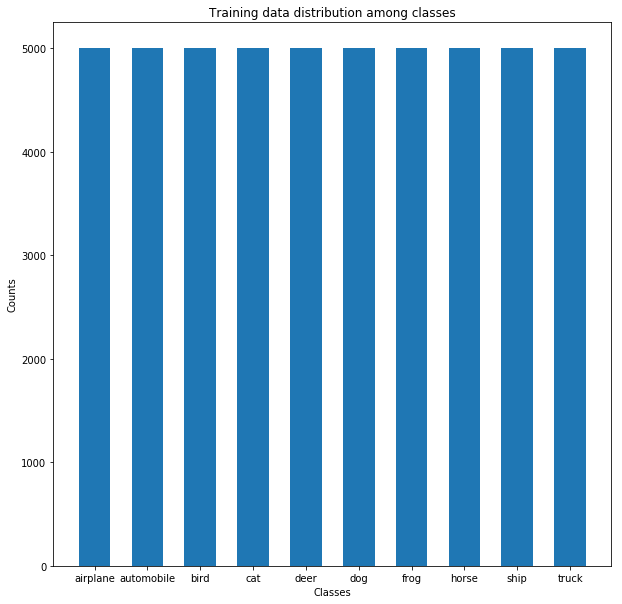

In [0]:
#Plot of the training datapoints distribution among classes
plt.figure(figsize=(10,10))
plt.bar(list(class_names),distribution_train.values(),width =0.6)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Training data distribution among classes')
plt.show()

In [0]:
# Getting the information on the number of classes and testing data points distribution among classes
class_train, counts_train = np.unique(y_test, return_counts = True)
distribution_train = dict(zip(class_train, counts_train))
print(distribution_train )

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


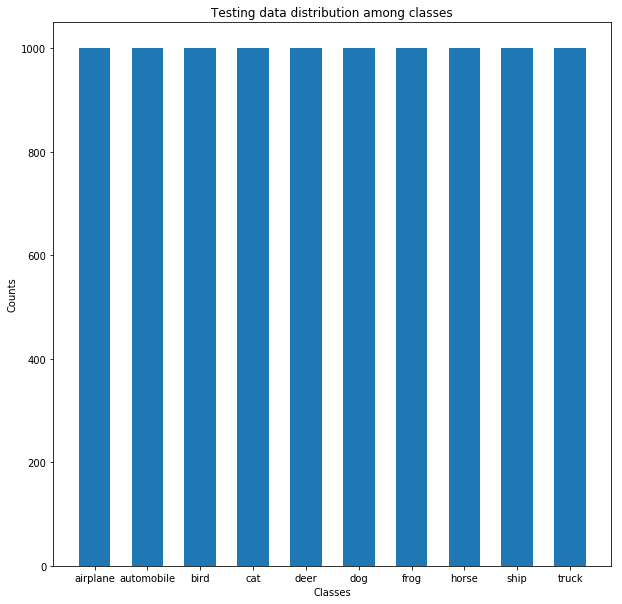

In [0]:
#Plot of the testing datapoints distribution among classes
plt.figure(figsize=(10,10))
plt.bar(list(class_names),distribution_train.values(),width =0.6)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Testing data distribution among classes')
plt.show()

# **Feature Scaling and One Hot Encoding**

In [0]:
# Flattening of the training, testing and validation data
X_train_ft = X_train.flatten().reshape(45000,-1)
X_valid_ft = X_valid.flatten().reshape(5000,-1)
X_test_ft = X_test.flatten().reshape(10000,-1)
# Shape of the flattened training, validation, and testing data
print('X_train_ft', X_train_ft.shape)
print('X_valid_ft', X_valid_ft.shape)
print('X_test_ft', X_test_ft.shape)

('X_train_ft', (45000, 3072))
('X_valid_ft', (5000, 3072))
('X_test_ft', (10000, 3072))


In [0]:
#Scaling the data using Standerd Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_train_sc = scaler.fit_transform(X_train)
#X_valid_sc = scaler.fit_transform(X_valid)
#X_test_sc = scaler.fit_transform(X_test)
X_train_ft_sc = scaler.fit_transform(X_train_ft)
X_valid_ft_sc = scaler.fit_transform(X_valid_ft)
X_test_ft_sc = scaler.fit_transform(X_test_ft)

In [0]:
#Scaling the data using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()
X_train_ft_mm = scaler_mm.fit_transform(X_train_ft)
X_valid_ft_mm = scaler_mm.fit_transform(X_valid_ft)
X_test_ft_mm = scaler_mm.fit_transform(X_test_ft)

In [0]:
#Need to add one hot encoding here!
#One Hot encoding of the lables
from sklearn.preprocessing import OneHotEncoder
oh_enc = OneHotEncoder()
#y_train_oh = oh_enc.fit_transform(y_train)
#y_valid_oh = oh_enc.fit_transform(y_valid)
#y_test_oh = oh_enc.fit_transform(y_test)

y_train_oh  = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid_oh  = tf.keras.utils.to_categorical(y_valid, num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes)

# Testing the scaled and unscaled datasets on a generic DNN 

**Performance of Unscaled Data**

In [0]:
#Performance of Unscaled data
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.001
config = tf.contrib.learn.RunConfig(tf_random_seed=42,
                                   save_checkpoints_steps= None)
                                   #model_dir="./models/initial/cifar10_init/") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

#tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr)
#tf.contrib.optimizer_v2.AdadeltaOptimizer(learning_rate=lr,rho=0.95,epsilon=1e-07)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # to be compatible with sklearn
dnn_clf.fit(X_train_ft, y_train, batch_size=batch_size, steps=epoch*5)

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please feed input to tf.data to support dask.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python

INFO:tensorflow:loss = 8.508777, step = 2200 (0.236 sec)
INFO:tensorflow:global_step/sec: 423.526
INFO:tensorflow:loss = 11.426819, step = 2300 (0.236 sec)
INFO:tensorflow:global_step/sec: 425.042
INFO:tensorflow:loss = 10.487155, step = 2400 (0.235 sec)
INFO:tensorflow:global_step/sec: 424.589
INFO:tensorflow:loss = 14.151384, step = 2500 (0.236 sec)
INFO:tensorflow:global_step/sec: 430.317
INFO:tensorflow:loss = 9.575111, step = 2600 (0.233 sec)
INFO:tensorflow:global_step/sec: 424.865
INFO:tensorflow:loss = 13.352739, step = 2700 (0.235 sec)
INFO:tensorflow:global_step/sec: 431.014
INFO:tensorflow:loss = 17.730644, step = 2800 (0.232 sec)
INFO:tensorflow:global_step/sec: 428.489
INFO:tensorflow:loss = 9.680422, step = 2900 (0.233 sec)
INFO:tensorflow:global_step/sec: 424.629
INFO:tensorflow:loss = 7.2341833, step = 3000 (0.235 sec)
INFO:tensorflow:global_step/sec: 425.96
INFO:tensorflow:loss = 6.973447, step = 3100 (0.235 sec)
INFO:tensorflow:global_step/sec: 424.946
INFO:tensorflow

SKCompat()

In [0]:
y_valid_pred = dnn_clf.predict(X_valid_ft)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxIih42/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.282


**Performance of MinMax Scaled data**


In [0]:
#Performance of MinMax Scaled data
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.001
config = tf.contrib.learn.RunConfig(tf_random_seed=42,
                                   save_checkpoints_steps= None)
                                   #model_dir="./models/initial/cifar10_init/") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

#tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr)
#tf.contrib.optimizer_v2.AdadeltaOptimizer(learning_rate=lr,rho=0.95,epsilon=1e-07)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # to be compatible with sklearn
dnn_clf.fit(X_train_ft_mm, y_train, batch_size=batch_size, steps=epoch*5)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe8236ec7d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpz6BXaT', '_tf_random_seed': 42, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz6BXaT/model.ckpt.
INFO:tensorflow:loss = 2.3650155, 

SKCompat()

In [0]:
y_valid_pred = dnn_clf.predict(X_valid_ft_mm)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjATjS3/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.3264

**Performance of Standerd Sacler Scaled data**

In [0]:
#Performance of Standerd Scaler Scaled data
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.001
config = tf.contrib.learn.RunConfig(tf_random_seed=42,
                                   save_checkpoints_steps= None)
                                   #model_dir="./models/initial/cifar10_init/") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

#tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr)
#tf.contrib.optimizer_v2.AdadeltaOptimizer(learning_rate=lr,rho=0.95,epsilon=1e-07)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # to be compatible with sklearn
dnn_clf.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=epoch*5)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe7856fc5d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpCcqhkx', '_tf_random_seed': 42, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpCcqhkx/model.ckpt.
INFO:tensorflow:loss = 2.5555367, 

SKCompat()

In [0]:
y_valid_pred = dnn_clf.predict(X_valid_ft_sc)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpCcqhkx/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.4898

# Using Standard Scaler Scaled Dataset from here:


## Learning Curve (Around 1 epoch)

In [0]:
Train_size_list_1ep = []
Train_error_list_1ep = []
Val_error_list_1ep = []
Train_time_list_1ep = []
Val_time_list_1ep = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 1 # total number of epoch 

for j in [ 0.999, 0.995, 0.99,0.985,0.98, 0.975,0.97, 0.96,0.95, 0.94, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.2, 0.1, 0.001, 0]:

    #### Data Saperation
    X_train_scaled_partial, X_noneed, y_train_partial, y_noneed  = train_test_split(X_train_ft_sc, 
                                                                                    y_train, test_size = j, 
                                                                                    random_state = 26)
    
    print('Train_set_size:', y_train_partial.shape[0])
    
    Train_size_list_1ep.append(y_train_partial.shape[0])
    
    
    #### Model building
    epoch = len(X_train_scaled_partial) /batch_size # number of steps in one epoch
  
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None,
                                   model_dir=None)
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_scaled_partial)
    
    dnn_clf_1ep = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_1ep = tf.contrib.learn.SKCompat(dnn_clf_1ep) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_1ep.fit(X_train_scaled_partial, y_train_partial, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_1ep.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_1ep.predict(X_train_scaled_partial) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train_partial, y_train_partial_pred['classes'])# training error
    
    Train_error_list_1ep.append(Train_error)#append training error
    
    print('dnn_1_clf training time', Train_elapse)
    print(type(y_train_partial_pred))
    
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_1ep.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_1ep.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_1ep.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Train_size_list: ", Train_size_list_1ep)
print("Train_error_list: ", Train_error_list_1ep)
print("Val_error_list: ", Val_error_list_1ep)
print("Train_time_list: ", Train_time_list_1ep)
print("Val_time_list: ", Val_time_list_1ep)   

('Train_set_size:', 45)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe75c0cb310>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpF2X78c', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpF2X78c/model.ckpt.
INFO:tenso

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_1_clf training time', 1.30863)
<type 'dict'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaQuBqp/model.ckpt-18
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.6955555555555555, '/', 0.7666)
('Train_set_size:', 1125)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe743723810>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmp8gZTSE', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id'

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpAaG_sN/model.ckpt.
INFO:tensorflow:loss = 2.438102, step = 0
INFO:tensorflow:Saving checkpoints for 54 into /tmp/tmpAaG_sN/model.ckpt.
INFO:tensorflow:Loss for final step: 2.0009272.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpAaG_sN/model.ckpt-54
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_1_clf training time', 1.389828)
<type 'dict'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpAaG_sN/model.ckpt-54
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.6314814814814815, '/', 0.7083999999999999)
('Train_set_size:', 4500)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribu

INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5594444444444444, '/', 0.6022000000000001)
('Train_set_size:', 22500)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6d46411d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmp77A2MX', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:ten

INFO:tensorflow:loss = 1.7268203, step = 300 (0.239 sec)
INFO:tensorflow:global_step/sec: 418.356
INFO:tensorflow:loss = 1.5722592, step = 400 (0.238 sec)
INFO:tensorflow:global_step/sec: 412.608
INFO:tensorflow:loss = 1.5609246, step = 500 (0.243 sec)
INFO:tensorflow:global_step/sec: 416.283
INFO:tensorflow:loss = 1.7195477, step = 600 (0.241 sec)
INFO:tensorflow:global_step/sec: 417.714
INFO:tensorflow:loss = 1.3986573, step = 700 (0.239 sec)
INFO:tensorflow:global_step/sec: 418.212
INFO:tensorflow:loss = 1.599126, step = 800 (0.239 sec)
INFO:tensorflow:Saving checkpoints for 810 into /tmp/tmpZHtS2B/model.ckpt.
INFO:tensorflow:Loss for final step: 1.5341219.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpZHtS2B/model.ckpt-810
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_1_clf training time', 3.073305)
<type 'dict'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp

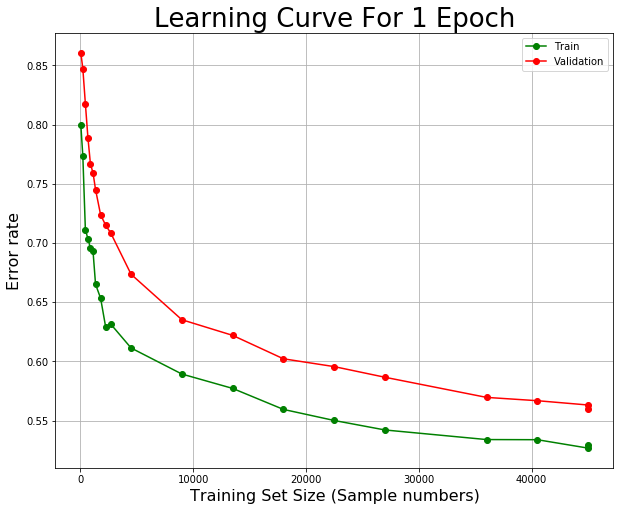

In [0]:
#Drawing learning curve for 1 epoch
plt.figure(figsize = (10,8))
plt.plot(Train_size_list_1ep, Train_error_list_1ep, 'go-',label = "Train")
plt.plot(Train_size_list_1ep, Val_error_list_1ep, 'ro-',label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Learning Curve For 1 Epoch', fontsize=26)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.savefig('./LearningCurve_1ep.png')

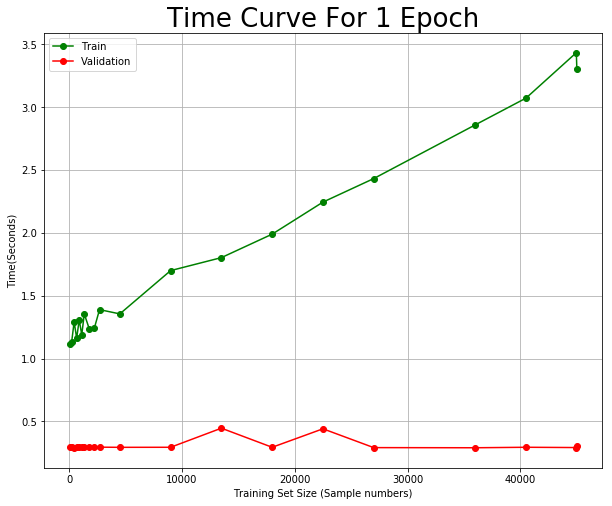

In [0]:
#Drawing train/val time v.s. training set for 1 epoch

plt.figure(figsize = (10,8))
plt.plot(Train_size_list_1ep, Train_time_list_1ep, 'go-', label = "Train")
plt.plot(Train_size_list_1ep, Val_time_list_1ep, 'ro-', label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For 1 Epoch', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_1ep.png')

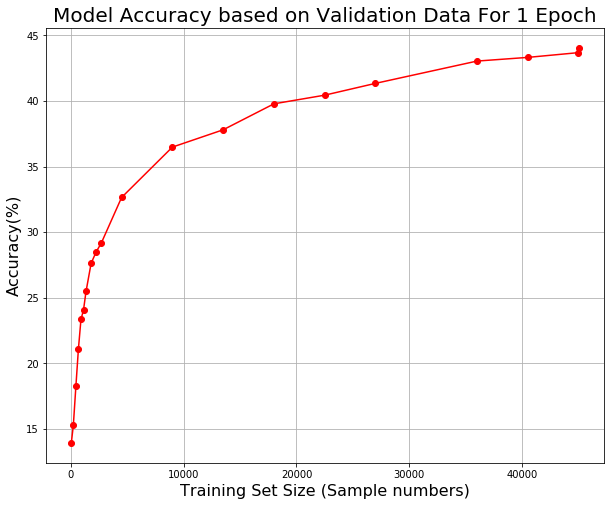

In [0]:
#Drawing model accuracy curve based on validation data for 1 epoch
plt.figure(figsize = (10,8))
a = []
a[:] = [(1 - x)*100 for x in Val_error_list_1ep]
plt.plot(Train_size_list_1ep, a, 'ro-')
plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Accuracy(%)',fontsize=16)
plt.title('Model Accuracy based on Validation Data For 1 Epoch', fontsize=20)
#plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.savefig('./accuracy_1ep.png')

In [0]:
# Saving data locally
import os
print( os.getcwd() )
print( os.listdir(os.getcwd()) )
print( os.listdir('models') )

/content
['sample_data', '.config', 'TimeCurve_1ep.png', 'models', 'LearningCurve_1ep.png']
['dnn_clf_1ep']


In [0]:
#downloading relevent files
from google.colab import files
#files.download( "./models/dnn_clf_1ep" )
#files.download( "./TimeCurve_1ep.png" )
#files.download( "./LearningCurve_1ep.png" )

## Learning Curve (Around 5 epoch)

In [0]:
Train_size_list_5ep = []
Train_error_list_5ep = []
Val_error_list_5ep = []
Train_time_list_5ep = []
Val_time_list_5ep = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 5 # total number of epoch 

for j in [ 0.999, 0.995, 0.99,0.985,0.98, 0.975,0.97, 0.96,0.95, 0.94, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.2, 0.1, 0.001, 0]:

    #### Data Saperation
    X_train_scaled_partial, X_noneed, y_train_partial, y_noneed  = train_test_split(X_train_ft_sc, 
                                                                                    y_train, test_size = j, 
                                                                                    random_state = 26)
    
    print('Train_set_size:', y_train_partial.shape[0])
    
    Train_size_list_5ep.append(y_train_partial.shape[0])# append the shape of training data
    
    
    #### Model building
    epoch = len(X_train_scaled_partial)/batch_size # number of steps in one epoch
  
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= 100,
                                   model_dir="./models/dnn_clf_5ep/")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_scaled_partial)
    
    dnn_clf_5ep = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir="./models/dnn_clf_5ep/",
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_5ep = tf.contrib.learn.SKCompat(dnn_clf_5ep) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_5ep.fit(X_train_scaled_partial, y_train_partial, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_5ep.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_5ep.predict(X_train_scaled_partial) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train_partial, y_train_partial_pred['classes'])# training error
    
    Train_error_list_5ep.append(Train_error)#append training error
    
    print('dnn_1_clf training time', Train_elapse)
    print(type(y_train_partial_pred))
    
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_5ep.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_5ep.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_5ep.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Train_size_list: ", Train_size_list_5ep)
print("Train_error_list: ", Train_error_list_5ep)
print("Val_error_list: ", Val_error_list_5ep)
print("Train_time_list: ", Train_time_list_5ep)
print("Val_time_list: ", Val_time_list_5ep)   

('Train_set_size:', 45)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe81f2efc10>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': 26, '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_num_ps_replicas': 0, '_train_distribute': None, '_is_chief': True, '_model_dir': './models/dnn_clf_5ep/', '_protocol': None, '_save_checkpoints_steps': 100, '_environment': 'local', '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./models/dnn_clf_5ep/model.ckp

INFO:tensorflow:Restoring parameters from ./models/dnn_clf_5ep/model.ckpt-221
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_1_clf training time', 3.971941)
<type 'dict'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/dnn_clf_5ep/model.ckpt-221
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.21999999999999997, '/', 0.669)
('Train_set_size:', 1125)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe718178050>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': 26, '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_num_ps_replicas': 0, '_train_distribute': None, '_is_chief': Tr

INFO:tensorflow:Restoring parameters from ./models/dnn_clf_5ep/model.ckpt-871
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.2008888888888889, '/', 0.6048)
('Train_set_size:', 2700)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe718683f50>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': 26, '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_num_ps_replicas': 0, '_train_distribute': None, '_is_chief': True, '_model_dir': './models/dnn_clf_5ep/', '_protocol': None, '_save_checkpoints_steps': 100, '_environment': 'local', '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_summary_steps': 100}
INFO:tensorflow:C

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/dnn_clf_5ep/model.ckpt-2491
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2491 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:loss = 0.9246818, step = 2491
INFO:tensorflow:Saving checkpoints for 2591 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 228.206
INFO:tensorflow:loss = 1.3297828, step = 2591 (0.440 sec)
INFO:tensorflow:Saving checkpoints for 2691 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 244.665
INFO:tensorflow:loss = 1.4322662, step = 2691 (0.409 sec)
INFO:tensorflow:Saving checkpoints for 2791 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 244.25
INFO:tensorflow:loss = 1.2929593, step = 2791 (0.409 sec)
INFO:tensorflow:Saving checkpoints for 2891 into ./models/dnn_clf_5ep/model.ckpt.
INFO:

('Train_set_size:', 22500)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe7200dc790>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': 26, '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_num_ps_replicas': 0, '_train_distribute': None, '_is_chief': True, '_model_dir': './models/dnn_clf_5ep/', '_protocol': None, '_save_checkpoints_steps': 100, '_environment': 'local', '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/dnn_clf_5ep/model.ckpt-5641
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_ini

INFO:tensorflow:global_step/sec: 245.579
INFO:tensorflow:loss = 1.0250527, step = 8691 (0.407 sec)
INFO:tensorflow:Saving checkpoints for 8791 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 245.508
INFO:tensorflow:loss = 1.1064458, step = 8791 (0.407 sec)
INFO:tensorflow:Saving checkpoints for 8891 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 247.603
INFO:tensorflow:loss = 0.9812381, step = 8891 (0.404 sec)
INFO:tensorflow:Saving checkpoints for 8991 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 246.319
INFO:tensorflow:loss = 0.9182034, step = 8991 (0.406 sec)
INFO:tensorflow:Saving checkpoints for 9091 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 246.73
INFO:tensorflow:loss = 1.1392553, step = 9091 (0.405 sec)
INFO:tensorflow:Saving checkpoints for 9191 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 248.841
INFO:tensorflow:loss = 1.0549942, step = 9191 (0.402 se

INFO:tensorflow:loss = 1.1352508, step = 12291 (0.407 sec)
INFO:tensorflow:Saving checkpoints for 12391 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 245.01
INFO:tensorflow:loss = 1.0745764, step = 12391 (0.408 sec)
INFO:tensorflow:Saving checkpoints for 12491 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 245.701
INFO:tensorflow:loss = 0.9393605, step = 12491 (0.407 sec)
INFO:tensorflow:Saving checkpoints for 12591 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 243.604
INFO:tensorflow:loss = 0.9325314, step = 12591 (0.411 sec)
INFO:tensorflow:Saving checkpoints for 12691 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 245.159
INFO:tensorflow:loss = 1.0331308, step = 12691 (0.407 sec)
INFO:tensorflow:Saving checkpoints for 12791 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 245.341
INFO:tensorflow:loss = 0.9678242, step = 12791 (0.408 sec)
INFO:tensorflow:Saving chec

INFO:tensorflow:Saving checkpoints for 15991 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 247.014
INFO:tensorflow:loss = 1.0537931, step = 15991 (0.405 sec)
INFO:tensorflow:Saving checkpoints for 16091 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 247.67
INFO:tensorflow:loss = 0.910475, step = 16091 (0.404 sec)
INFO:tensorflow:Saving checkpoints for 16191 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 247.123
INFO:tensorflow:loss = 0.97149926, step = 16191 (0.405 sec)
INFO:tensorflow:Saving checkpoints for 16291 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 244.856
INFO:tensorflow:loss = 0.9830867, step = 16291 (0.408 sec)
INFO:tensorflow:Saving checkpoints for 16391 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 245.36
INFO:tensorflow:loss = 0.8921643, step = 16391 (0.408 sec)
INFO:tensorflow:Saving checkpoints for 16491 into ./models/dnn_clf_5ep/model.ckpt.
INFO

INFO:tensorflow:Saving checkpoints for 19541 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 244.58
INFO:tensorflow:loss = 1.0517561, step = 19541 (0.409 sec)
INFO:tensorflow:Saving checkpoints for 19641 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 244.106
INFO:tensorflow:loss = 0.8581823, step = 19641 (0.409 sec)
INFO:tensorflow:Saving checkpoints for 19741 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 243.989
INFO:tensorflow:loss = 1.289516, step = 19741 (0.410 sec)
INFO:tensorflow:Saving checkpoints for 19841 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 242.379
INFO:tensorflow:loss = 0.8662439, step = 19841 (0.412 sec)
INFO:tensorflow:Saving checkpoints for 19941 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 243.058
INFO:tensorflow:loss = 1.0940632, step = 19941 (0.412 sec)
INFO:tensorflow:Saving checkpoints for 20041 into ./models/dnn_clf_5ep/model.ckpt.
INFO

INFO:tensorflow:Saving checkpoints for 23136 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 246.785
INFO:tensorflow:loss = 0.9950011, step = 23136 (0.406 sec)
INFO:tensorflow:Saving checkpoints for 23236 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 247.716
INFO:tensorflow:loss = 0.7993778, step = 23236 (0.403 sec)
INFO:tensorflow:Saving checkpoints for 23336 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 245.21
INFO:tensorflow:loss = 0.7730219, step = 23336 (0.408 sec)
INFO:tensorflow:Saving checkpoints for 23436 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 246.139
INFO:tensorflow:loss = 0.70225996, step = 23436 (0.407 sec)
INFO:tensorflow:Saving checkpoints for 23536 into ./models/dnn_clf_5ep/model.ckpt.
INFO:tensorflow:global_step/sec: 246.688
INFO:tensorflow:loss = 0.8736359, step = 23536 (0.405 sec)
INFO:tensorflow:Saving checkpoints for 23636 into ./models/dnn_clf_5ep/model.ckpt.
IN

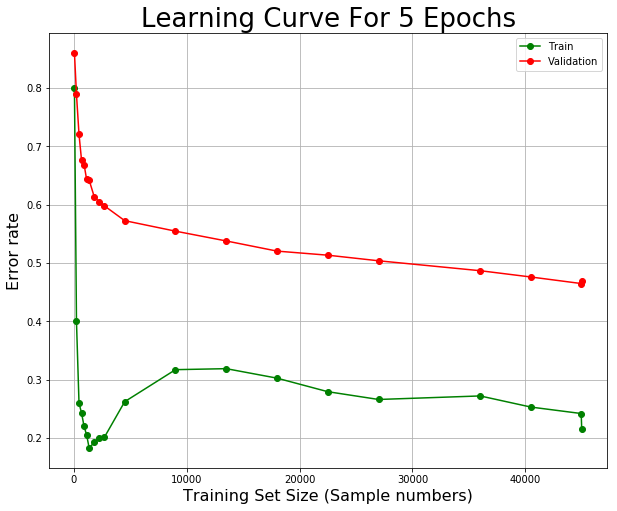

In [0]:
#Drawing learning curve for 5 epoch
plt.figure(figsize = (10,8))
plt.plot(Train_size_list_5ep, Train_error_list_5ep, 'go-',label = "Train")
plt.plot(Train_size_list_5ep, Val_error_list_5ep, 'ro-',label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Learning Curve For 5 Epochs', fontsize=26)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.savefig('./LearningCurve_5ep.png')

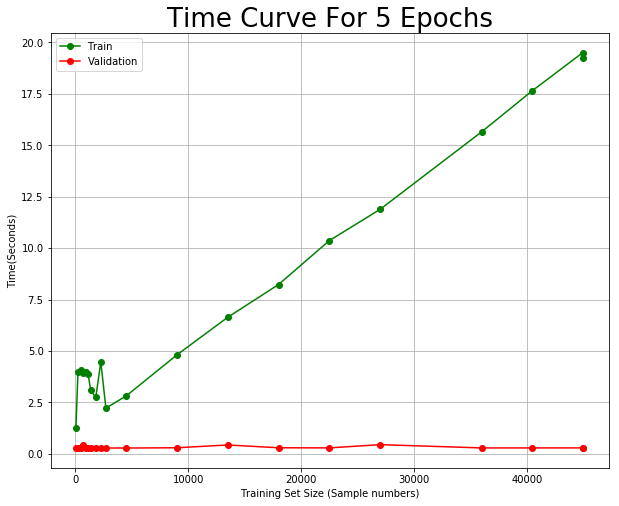

In [0]:
#Drawing train/val time v.s. training set for 5 epoch

plt.figure(figsize = (10,8))
plt.plot(Train_size_list_5ep, Train_time_list_5ep, 'go-', label = "Train")
plt.plot(Train_size_list_5ep, Val_time_list_5ep, 'ro-', label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For 5 Epochs', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_5ep.png')

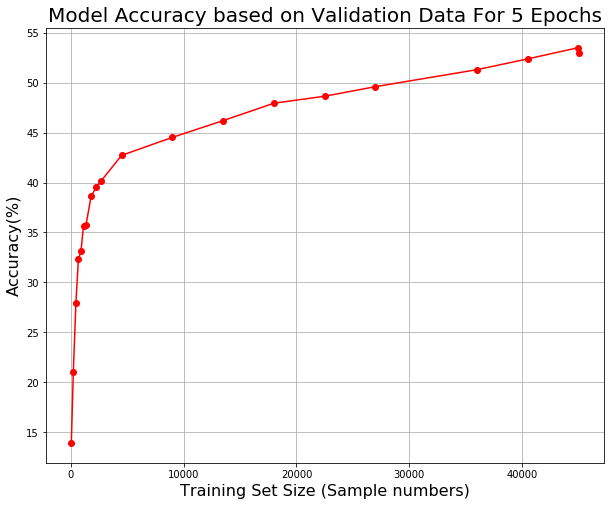

In [0]:
#Drawing model accuracy curve based on validation data for 5 epoch
plt.figure(figsize = (10,8))
#plt.plot(Train_size_list_5ep, Train_error_list_5ep, 'go-',label = "Train")
a = []
a[:] = [(1 - x)*100 for x in Val_error_list_5ep]
plt.plot(Train_size_list_5ep, a, 'ro-')
plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Accuracy(%)',fontsize=16)
plt.title('Model Accuracy based on Validation Data For 5 Epochs', fontsize=20)
#plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.savefig('./accuracy_5ep.png')

## Learning Curve (Around 10 epoch)

In [0]:
Train_size_list_10ep = []
Train_error_list_10ep = []
Val_error_list_10ep = []
Train_time_list_10ep = []
Val_time_list_10ep = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 10 # total number of epoch 

for j in [ 0.999, 0.995, 0.99,0.985,0.98, 0.975,0.97, 0.96,0.95, 0.94, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.2, 0.1, 0.001, 0]:

    #### Data Saperation
    X_train_scaled_partial, X_noneed, y_train_partial, y_noneed  = train_test_split(X_train_ft_sc, 
                                                                                    y_train, test_size = j, 
                                                                                    random_state = 26)
    
    print('Train_set_size:', y_train_partial.shape[0])
    
    Train_size_list_10ep.append(y_train_partial.shape[0])# append the shape of training data
    
    
    #### Model building
    epoch = len(X_train_scaled_partial)/batch_size # number of steps in one epoch
  
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None,
                                   model_dir=None)
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_scaled_partial)
    
    dnn_clf_10ep = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_10ep = tf.contrib.learn.SKCompat(dnn_clf_10ep) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_10ep.fit(X_train_scaled_partial, y_train_partial, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_10ep.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_10ep.predict(X_train_scaled_partial) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train_partial, y_train_partial_pred['classes'])# training error
    
    Train_error_list_10ep.append(Train_error)#append training error
    
    print('dnn_clf_10ep training time', Train_elapse)
    print(type(y_train_partial_pred))
    
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_10ep.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_10ep.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_10ep.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Train_size_list: ", Train_size_list_10ep)
print("Train_error_list: ", Train_error_list_10ep)
print("Val_error_list: ", Val_error_list_10ep)
print("Train_time_list: ", Train_time_list_10ep)
print("Val_time_list: ", Val_time_list_10ep)   

('Train_set_size:', 45)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6d405d090>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpGXg0vq', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpGXg0vq/model.ckpt.
INFO:tenso

INFO:tensorflow:Saving checkpoints for 180 into /tmp/tmp_eH9Np/model.ckpt.
INFO:tensorflow:Loss for final step: 1.2237606.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_eH9Np/model.ckpt-180
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_10ep training time', 1.566729)
<type 'dict'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_eH9Np/model.ckpt-180
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.2466666666666667, '/', 0.6734)
('Train_set_size:', 1125)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6bc00c650>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protoc

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_10ep training time', 2.203238)
<type 'dict'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6VGQyj/model.ckpt-450
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.2831111111111111, '/', 0.6162000000000001)
('Train_set_size:', 2700)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6d473dc10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmprQrebN', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replica

INFO:tensorflow:Done running local_init_op.
('dnn_clf_10ep training time', 5.338504)
<type 'dict'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8tZbzi/model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.32999999999999996, '/', 0.552)
('Train_set_size:', 13500)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6d4641ed0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpygx2VK', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 10

INFO:tensorflow:global_step/sec: 423.871
INFO:tensorflow:loss = 1.2543235, step = 2600 (0.236 sec)
INFO:tensorflow:global_step/sec: 423.033
INFO:tensorflow:loss = 1.2443494, step = 2700 (0.236 sec)
INFO:tensorflow:global_step/sec: 423.341
INFO:tensorflow:loss = 1.1749101, step = 2800 (0.236 sec)
INFO:tensorflow:global_step/sec: 421.582
INFO:tensorflow:loss = 0.9504564, step = 2900 (0.237 sec)
INFO:tensorflow:global_step/sec: 421.1
INFO:tensorflow:loss = 1.1221372, step = 3000 (0.237 sec)
INFO:tensorflow:global_step/sec: 424.852
INFO:tensorflow:loss = 1.0874699, step = 3100 (0.236 sec)
INFO:tensorflow:global_step/sec: 428.423
INFO:tensorflow:loss = 1.1979171, step = 3200 (0.233 sec)
INFO:tensorflow:global_step/sec: 426.891
INFO:tensorflow:loss = 1.1499405, step = 3300 (0.234 sec)
INFO:tensorflow:global_step/sec: 428.747
INFO:tensorflow:loss = 1.2516568, step = 3400 (0.234 sec)
INFO:tensorflow:global_step/sec: 428.089
INFO:tensorflow:loss = 1.2283417, step = 3500 (0.233 sec)
INFO:tensorf

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpU5UBC_/model.ckpt.
INFO:tensorflow:loss = 2.4994092, step = 0
INFO:tensorflow:global_step/sec: 370.037
INFO:tensorflow:loss = 1.8789679, step = 100 (0.272 sec)
INFO:tensorflow:global_step/sec: 412.737
INFO:tensorflow:loss = 1.9255635, step = 200 (0.242 sec)
INFO:tensorflow:global_step/sec: 409.406
INFO:tensorflow:loss = 1.7180893, step = 300 (0.245 sec)
INFO:tensorflow:global_step/sec: 408.751
INFO:tensorflow:loss = 1.6306186, step = 400 (0.244 sec)
INFO:tensorflow:global_step/sec: 411.211
INFO:tensorflow:loss = 1.7299135, step = 500 (0.243 sec)
INFO:tensorflow:global_step/sec: 414.398
INFO:tensorflow:loss = 1.471824, step = 600 (0.241 sec)
INFO:tensorflow:global_step/sec: 412.594
INFO:tensorflow:loss = 1.5674031, step = 700 (0.243 sec)
INFO:tensorflow:global_step/sec: 41

INFO:tensorflow:global_step/sec: 410.863
INFO:tensorflow:loss = 1.5065826, step = 1100 (0.243 sec)
INFO:tensorflow:global_step/sec: 418.645
INFO:tensorflow:loss = 1.529013, step = 1200 (0.239 sec)
INFO:tensorflow:global_step/sec: 414.298
INFO:tensorflow:loss = 1.571957, step = 1300 (0.241 sec)
INFO:tensorflow:global_step/sec: 418.531
INFO:tensorflow:loss = 1.59814, step = 1400 (0.240 sec)
INFO:tensorflow:global_step/sec: 412.809
INFO:tensorflow:loss = 1.3344028, step = 1500 (0.242 sec)
INFO:tensorflow:global_step/sec: 415.73
INFO:tensorflow:loss = 1.5699481, step = 1600 (0.241 sec)
INFO:tensorflow:global_step/sec: 414.216
INFO:tensorflow:loss = 1.486362, step = 1700 (0.241 sec)
INFO:tensorflow:global_step/sec: 413.62
INFO:tensorflow:loss = 1.5961237, step = 1800 (0.241 sec)
INFO:tensorflow:global_step/sec: 410.58
INFO:tensorflow:loss = 1.265203, step = 1900 (0.243 sec)
INFO:tensorflow:global_step/sec: 416.648
INFO:tensorflow:loss = 1.288782, step = 2000 (0.241 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 416.186
INFO:tensorflow:loss = 1.7195889, step = 600 (0.240 sec)
INFO:tensorflow:global_step/sec: 416.05
INFO:tensorflow:loss = 1.398797, step = 700 (0.240 sec)
INFO:tensorflow:global_step/sec: 418.811
INFO:tensorflow:loss = 1.5992441, step = 800 (0.238 sec)
INFO:tensorflow:global_step/sec: 418.181
INFO:tensorflow:loss = 1.5233716, step = 900 (0.239 sec)
INFO:tensorflow:global_step/sec: 417.788
INFO:tensorflow:loss = 1.3852704, step = 1000 (0.239 sec)
INFO:tensorflow:global_step/sec: 415.963
INFO:tensorflow:loss = 1.5865222, step = 1100 (0.241 sec)
INFO:tensorflow:global_step/sec: 415.818
INFO:tensorflow:loss = 1.4609455, step = 1200 (0.240 sec)
INFO:tensorflow:global_step/sec: 408.931
INFO:tensorflow:loss = 1.5837909, step = 1300 (0.245 sec)
INFO:tensorflow:global_step/sec: 410.076
INFO:tensorflow:loss = 1.6270125, step = 1400 (0.243 sec)
INFO:tensorflow:global_step/sec: 411.943
INFO:tensorflow:loss = 1.5005863, step = 1500 (0.243 sec)
INFO:tensorflow:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpNKmJpm/model.ckpt.
INFO:tensorflow:loss = 2.5372481, step = 0
INFO:tensorflow:global_step/sec: 370.596
INFO:tensorflow:loss = 1.8357242, step = 100 (0.271 sec)
INFO:tensorflow:global_step/sec: 415.077
INFO:tensorflow:loss = 1.7246399, step = 200 (0.240 sec)
INFO:tensorflow:global_step/sec: 418.627
INFO:tensorflow:loss = 1.9438272, step = 300 (0.239 sec)
INFO:tensorflow:global_step/sec: 417.042
INFO:tensorflow:loss = 1.7147685, step = 400 (0.240 sec)
INFO:tensorflow:global_step/sec: 419.108
INFO:tensorflow:loss = 1.7580237, step = 500 (0.239 sec)
INFO:tensorflow:global_step/sec: 417.124
INFO:tensorflow:loss = 1.5703301, step = 600 (0.240 sec)
INFO:tensorflow:global_step/sec: 414.209
INFO:tensorflow:loss = 1.6054819, step = 700 (0.242 sec)
INFO:tensorflow:global_step/sec: 4

INFO:tensorflow:loss = 0.99865115, step = 8100 (0.245 sec)
INFO:tensorflow:global_step/sec: 411.999
INFO:tensorflow:loss = 1.4728106, step = 8200 (0.243 sec)
INFO:tensorflow:global_step/sec: 411.161
INFO:tensorflow:loss = 1.1061655, step = 8300 (0.243 sec)
INFO:tensorflow:global_step/sec: 412.097
INFO:tensorflow:loss = 1.2502518, step = 8400 (0.243 sec)
INFO:tensorflow:global_step/sec: 417.765
INFO:tensorflow:loss = 1.3400378, step = 8500 (0.239 sec)
INFO:tensorflow:global_step/sec: 414.271
INFO:tensorflow:loss = 0.94778913, step = 8600 (0.241 sec)
INFO:tensorflow:global_step/sec: 413.632
INFO:tensorflow:loss = 1.1730392, step = 8700 (0.242 sec)
INFO:tensorflow:global_step/sec: 411.93
INFO:tensorflow:loss = 1.0485629, step = 8800 (0.242 sec)
INFO:tensorflow:global_step/sec: 414.779
INFO:tensorflow:loss = 1.0765083, step = 8900 (0.241 sec)
INFO:tensorflow:Saving checkpoints for 8990 into /tmp/tmpNKmJpm/model.ckpt.
INFO:tensorflow:Loss for final step: 1.011029.
INFO:tensorflow:Graph was 

INFO:tensorflow:global_step/sec: 411.475
INFO:tensorflow:loss = 1.2778075, step = 5800 (0.244 sec)
INFO:tensorflow:global_step/sec: 410.283
INFO:tensorflow:loss = 1.0117916, step = 5900 (0.243 sec)
INFO:tensorflow:global_step/sec: 412.894
INFO:tensorflow:loss = 1.1413786, step = 6000 (0.243 sec)
INFO:tensorflow:global_step/sec: 411.002
INFO:tensorflow:loss = 1.2545528, step = 6100 (0.243 sec)
INFO:tensorflow:global_step/sec: 411.38
INFO:tensorflow:loss = 1.2410351, step = 6200 (0.244 sec)
INFO:tensorflow:global_step/sec: 410.946
INFO:tensorflow:loss = 1.3349034, step = 6300 (0.243 sec)
INFO:tensorflow:global_step/sec: 409.117
INFO:tensorflow:loss = 0.95952445, step = 6400 (0.245 sec)
INFO:tensorflow:global_step/sec: 412.233
INFO:tensorflow:loss = 1.1332588, step = 6500 (0.243 sec)
INFO:tensorflow:global_step/sec: 410.575
INFO:tensorflow:loss = 1.0490031, step = 6600 (0.244 sec)
INFO:tensorflow:global_step/sec: 414.479
INFO:tensorflow:loss = 1.2140766, step = 6700 (0.242 sec)
INFO:tenso

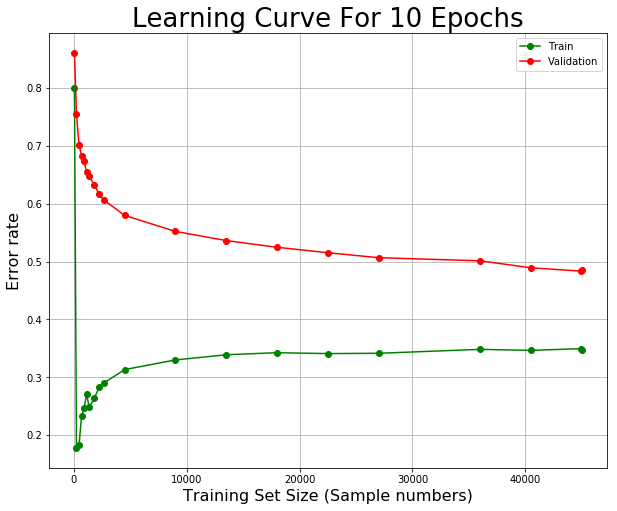

In [0]:
#Drawing learning curve for 10 epochs
plt.figure(figsize = (10,8))
plt.plot(Train_size_list_10ep, Train_error_list_10ep, 'go-',label = "Train")
plt.plot(Train_size_list_10ep, Val_error_list_10ep, 'ro-',label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Learning Curve For 10 Epochs', fontsize=26)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.savefig('./LearningCurve_10ep.png')

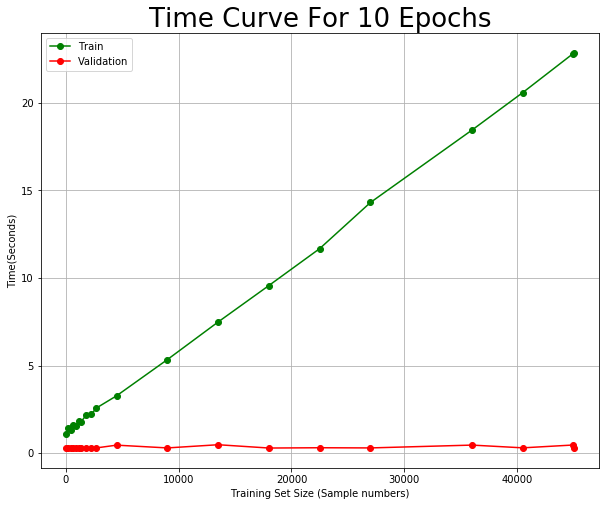

In [0]:
#Drawing train/val time v.s. training set for 10 epochs

plt.figure(figsize = (10,8))
plt.plot(Train_size_list_10ep, Train_time_list_10ep, 'go-', label = "Train")
plt.plot(Train_size_list_10ep, Val_time_list_10ep, 'ro-', label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For 10 Epochs', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_10ep.png')

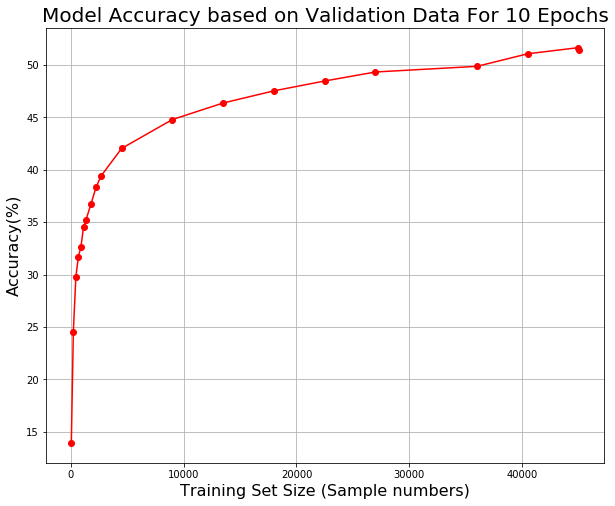

In [0]:
#Drawing model accuracy curve based on validation data for 10 epochs
plt.figure(figsize = (10,8))
a = []
a[:] = [(1 - x)*100 for x in Val_error_list_10ep]
plt.plot(Train_size_list_10ep, a, 'ro-')
plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Accuracy(%)',fontsize=16)
plt.title('Model Accuracy based on Validation Data For 10 Epochs', fontsize=20)
plt.grid(True)
plt.savefig('./accuracy_10ep.png')

## Comparing performaces of models with 1,5 and 10 epochs

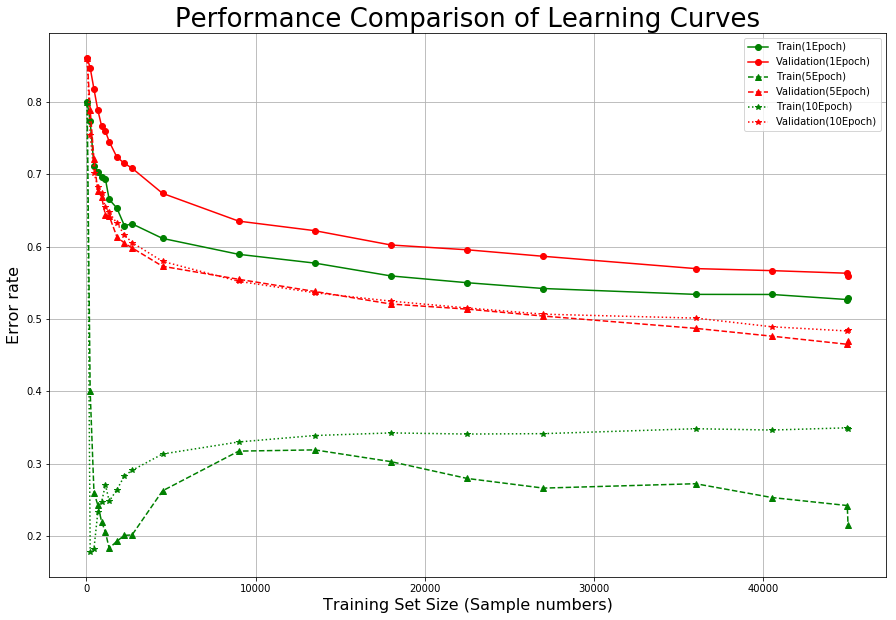

In [0]:
#Drawing learning curve performances
plt.figure(figsize = (15,10))
plt.plot(Train_size_list_1ep, Train_error_list_1ep, 'go-', label = "Train(1Epoch)")
plt.plot(Train_size_list_1ep, Val_error_list_1ep, 'ro-', label = "Validation(1Epoch)")
plt.plot(Train_size_list_5ep, Train_error_list_5ep, 'g^--', label = "Train(5Epoch)")
plt.plot(Train_size_list_5ep, Val_error_list_5ep, 'r^--', label = "Validation(5Epoch)")
plt.plot(Train_size_list_10ep, Train_error_list_10ep, 'g*:', label = "Train(10Epoch)")
plt.plot(Train_size_list_10ep, Val_error_list_10ep, 'r*:', label = "Validation(10Epoch)")

plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.legend(loc="upper right", fontsize=10)
plt.title('Performance Comparison of Learning Curves', fontsize=26)
plt.grid(True)
plt.savefig('./performance_comp_1_5_10ep.png')

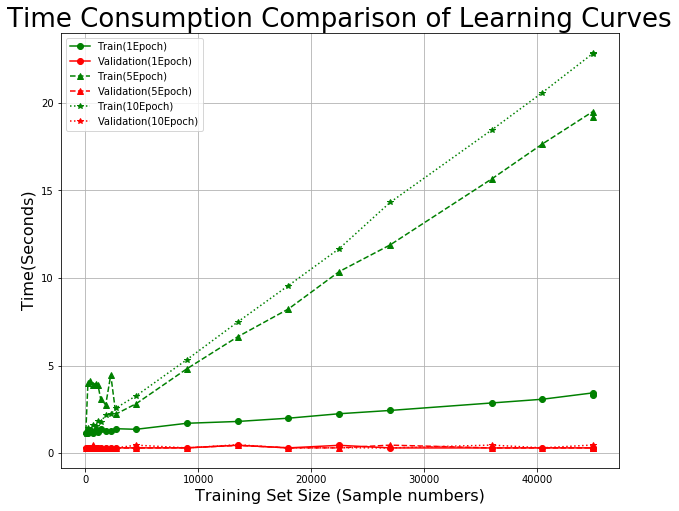

In [0]:
#Drawing time comparison plot
#Drawing train/val time v.s. training set

plt.figure(figsize = (10,8))
plt.plot(Train_size_list_1ep, Train_time_list_1ep, 'go-', label = "Train(1Epoch)")
plt.plot(Train_size_list_1ep, Val_time_list_1ep, 'ro-', label = "Validation(1Epoch)")
plt.plot(Train_size_list_5ep, Train_time_list_5ep, 'g^--', label = "Train(5Epoch)")
plt.plot(Train_size_list_5ep, Val_time_list_5ep, 'r^--', label = "Validation(5Epoch)")
plt.plot(Train_size_list_10ep, Train_time_list_10ep, 'g*:', label = "Train(10Epoch)")
plt.plot(Train_size_list_10ep, Val_time_list_10ep, 'r*:', label = "Validation(10Epoch)")
 

plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Time(Seconds)',fontsize=16)
plt.legend(loc="upper left", fontsize=10)
plt.title('Time Consumption Comparison of Learning Curves', fontsize=26)
plt.grid(True)
plt.savefig('./time_comp_1_5_10ep.png')

In [0]:
# Saving data locally
print( os.getcwd() )
print( os.listdir(os.getcwd()) )
print( os.listdir('models') )

/content
['sample_data', '.config', 'TimeCurve_5ep.png', 'TimeCurve_1ep.png', 'models', 'performance_comp_1_5_10ep.png', 'accuracy_1ep.png', 'LearningCurve_10ep.png', 'TimeCurve_10ep.png', 'accuracy_10ep.png', 'LearningCurve_5ep.png', 'time_comp_1_5_10ep.png', 'LearningCurve_1ep.png', 'accuracy_5ep.png']
['dnn_clf_1ep', 'dnn_clf_5ep', 'dnn_clf_10ep']


In [0]:
#downloading relevent files
files.download( "./TimeCurve_5ep.png" )
files.download( "./performance_comp_1_5_10ep.png" )
files.download( "./accuracy_1ep.png" )
files.download( "./LearningCurve_10ep.png" )
files.download( "./TimeCurve_10ep.png" )
files.download( "./accuracy_10ep.png" )
files.download( "./LearningCurve_5ep.png" )
files.download( "./time_comp_1_5_10ep.png" )
files.download( "./accuracy_5ep.png" )

# Changing Number of Neurons and Activation Functions

## ReLU Activation with different Neurons

In [0]:
Nron_size_list_relu = []
Train_error_list_relu = []
Val_error_list_relu = []
Train_time_list_relu = []
Val_time_list_relu = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 5 # total number of epoch 
epoch = len(X_train_ft_sc)/batch_size # number of steps in one epoch

for j in [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,3000,5000,8000,10000,20000]:

    #### Appending number of neurons                                                                               
    Nron_size_list_relu.append(j)
                                                                                    
    print('Neuron_set_size:', j)
    
    
    #### Model building
    
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None)
                                  # model_dir="./models/dnn_clf_relu/")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
    
    dnn_clf_relu = tf.contrib.learn.DNNClassifier(hidden_units = [j],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_relu = tf.contrib.learn.SKCompat(dnn_clf_relu) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_relu.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_relu.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_relu.predict(X_train_ft_sc) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train, y_train_partial_pred['classes'])# training error
    
    Train_error_list_relu.append(Train_error)#append training error
    
    print('dnn_clf_relu training time', Train_elapse) 
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_relu.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_relu.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_relu.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Nron_size_list_RELU: ", Nron_size_list_relu)
print("Train_error_list_RELU: ", Train_error_list_relu)
print("Val_error_list_RELU: ", Val_error_list_relu)
print("Train_time_list_RELU: ", Train_time_list_relu)
print("Val_time_list_RELU: ", Val_time_list_relu)  

('Neuron_set_size:', 10)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe7180f9f50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmp7Q9h_3', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp7Q9h_3/model.ckpt.
INFO:tens

INFO:tensorflow:global_step/sec: 605.155
INFO:tensorflow:loss = 1.5962561, step = 1200 (0.165 sec)
INFO:tensorflow:global_step/sec: 604.8
INFO:tensorflow:loss = 1.996807, step = 1300 (0.166 sec)
INFO:tensorflow:global_step/sec: 605.1
INFO:tensorflow:loss = 1.6972979, step = 1400 (0.165 sec)
INFO:tensorflow:global_step/sec: 602.808
INFO:tensorflow:loss = 1.6548733, step = 1500 (0.166 sec)
INFO:tensorflow:global_step/sec: 608.066
INFO:tensorflow:loss = 1.7702854, step = 1600 (0.164 sec)
INFO:tensorflow:global_step/sec: 607.054
INFO:tensorflow:loss = 1.7365358, step = 1700 (0.165 sec)
INFO:tensorflow:global_step/sec: 592.21
INFO:tensorflow:loss = 1.9450535, step = 1800 (0.168 sec)
INFO:tensorflow:global_step/sec: 616.257
INFO:tensorflow:loss = 1.5230908, step = 1900 (0.163 sec)
INFO:tensorflow:global_step/sec: 617.222
INFO:tensorflow:loss = 1.6070819, step = 2000 (0.162 sec)
INFO:tensorflow:global_step/sec: 619.944
INFO:tensorflow:loss = 1.5276266, step = 2100 (0.161 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 598.881
INFO:tensorflow:loss = 1.5813104, step = 3400 (0.166 sec)
INFO:tensorflow:global_step/sec: 607.172
INFO:tensorflow:loss = 1.4324147, step = 3500 (0.165 sec)
INFO:tensorflow:global_step/sec: 610.102
INFO:tensorflow:loss = 1.4168886, step = 3600 (0.164 sec)
INFO:tensorflow:global_step/sec: 599.772
INFO:tensorflow:loss = 1.7161112, step = 3700 (0.167 sec)
INFO:tensorflow:global_step/sec: 611.082
INFO:tensorflow:loss = 1.6976062, step = 3800 (0.164 sec)
INFO:tensorflow:global_step/sec: 610.11
INFO:tensorflow:loss = 1.4976029, step = 3900 (0.163 sec)
INFO:tensorflow:global_step/sec: 614.231
INFO:tensorflow:loss = 1.4611185, step = 4000 (0.163 sec)
INFO:tensorflow:global_step/sec: 609.622
INFO:tensorflow:loss = 1.3126987, step = 4100 (0.164 sec)
INFO:tensorflow:global_step/sec: 610.926
INFO:tensorflow:loss = 1.5845472, step = 4200 (0.164 sec)
INFO:tensorflow:global_step/sec: 609.608
INFO:tensorflow:loss = 1.4897946, step = 4300 (0.165 sec)
INFO:tensor

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpAJH9zM/model.ckpt.
INFO:tensorflow:loss = 3.0503538, step = 0
INFO:tensorflow:global_step/sec: 526.948
INFO:tensorflow:loss = 1.9664208, step = 100 (0.191 sec)
INFO:tensorflow:global_step/sec: 611.392
INFO:tensorflow:loss = 1.6303068, step = 200 (0.164 sec)
INFO:tensorflow:global_step/sec: 611.21
INFO:tensorflow:loss = 1.684375, step = 300 (0.163 sec)
INFO:tensorflow:global_step/sec: 601.663
INFO:tensorflow:loss = 1.6872878, step = 400 (0.166 sec)
INFO:tensorflow:global_step/sec: 612.895
INFO:tensorflow:loss = 1.5844007, step = 500 (0.163 sec)
INFO:tensorflow:global_step/sec: 617.711
INFO:tensorflow:loss = 1.5052481, step = 600 (0.162 sec)
INFO:tensorflow:global_step/sec: 612.066
INFO:tensorflow:loss = 1.660891, step = 700 (0.164 sec)
INFO:tensorflow:global_step/sec: 619.

INFO:tensorflow:global_step/sec: 611.875
INFO:tensorflow:loss = 1.5649146, step = 2000 (0.163 sec)
INFO:tensorflow:global_step/sec: 621.528
INFO:tensorflow:loss = 1.4631308, step = 2100 (0.161 sec)
INFO:tensorflow:global_step/sec: 615.866
INFO:tensorflow:loss = 1.503364, step = 2200 (0.162 sec)
INFO:tensorflow:global_step/sec: 616.69
INFO:tensorflow:loss = 1.5591016, step = 2300 (0.162 sec)
INFO:tensorflow:global_step/sec: 611.894
INFO:tensorflow:loss = 1.8443369, step = 2400 (0.163 sec)
INFO:tensorflow:global_step/sec: 612.317
INFO:tensorflow:loss = 1.8098855, step = 2500 (0.164 sec)
INFO:tensorflow:global_step/sec: 554.917
INFO:tensorflow:loss = 1.544968, step = 2600 (0.180 sec)
INFO:tensorflow:global_step/sec: 615.813
INFO:tensorflow:loss = 1.6022954, step = 2700 (0.162 sec)
INFO:tensorflow:global_step/sec: 610.534
INFO:tensorflow:loss = 1.733363, step = 2800 (0.164 sec)
INFO:tensorflow:global_step/sec: 613.512
INFO:tensorflow:loss = 1.2530591, step = 2900 (0.163 sec)
INFO:tensorflo

INFO:tensorflow:global_step/sec: 612.279
INFO:tensorflow:loss = 1.4206262, step = 4200 (0.164 sec)
INFO:tensorflow:global_step/sec: 612.389
INFO:tensorflow:loss = 1.3420912, step = 4300 (0.163 sec)
INFO:tensorflow:global_step/sec: 607.124
INFO:tensorflow:loss = 1.4977382, step = 4400 (0.164 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmp4EKKgs/model.ckpt.
INFO:tensorflow:Loss for final step: 1.4480025.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4EKKgs/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_relu training time', 8.052308)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4EKKgs/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.48106666666666664, '/', 0.5406)
('Neuron_set_size:', 350)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_n

INFO:tensorflow:loss = 1.6805942, step = 200 (0.171 sec)
INFO:tensorflow:global_step/sec: 586.118
INFO:tensorflow:loss = 1.6723458, step = 300 (0.170 sec)
INFO:tensorflow:global_step/sec: 589.331
INFO:tensorflow:loss = 1.7538959, step = 400 (0.170 sec)
INFO:tensorflow:global_step/sec: 588.162
INFO:tensorflow:loss = 1.5785108, step = 500 (0.170 sec)
INFO:tensorflow:global_step/sec: 582.476
INFO:tensorflow:loss = 1.6278263, step = 600 (0.172 sec)
INFO:tensorflow:global_step/sec: 588.734
INFO:tensorflow:loss = 1.5774401, step = 700 (0.170 sec)
INFO:tensorflow:global_step/sec: 584.16
INFO:tensorflow:loss = 1.8734814, step = 800 (0.171 sec)
INFO:tensorflow:global_step/sec: 588.744
INFO:tensorflow:loss = 1.5966257, step = 900 (0.170 sec)
INFO:tensorflow:global_step/sec: 581.923
INFO:tensorflow:loss = 1.8792151, step = 1000 (0.172 sec)
INFO:tensorflow:global_step/sec: 583.233
INFO:tensorflow:loss = 1.4118774, step = 1100 (0.172 sec)
INFO:tensorflow:global_step/sec: 582.367
INFO:tensorflow:los

INFO:tensorflow:loss = 1.9251546, step = 2400 (0.168 sec)
INFO:tensorflow:global_step/sec: 605.052
INFO:tensorflow:loss = 1.648999, step = 2500 (0.165 sec)
INFO:tensorflow:global_step/sec: 597.683
INFO:tensorflow:loss = 1.5878605, step = 2600 (0.167 sec)
INFO:tensorflow:global_step/sec: 590.002
INFO:tensorflow:loss = 1.525188, step = 2700 (0.170 sec)
INFO:tensorflow:global_step/sec: 586.029
INFO:tensorflow:loss = 1.6910597, step = 2800 (0.171 sec)
INFO:tensorflow:global_step/sec: 589.376
INFO:tensorflow:loss = 1.1787944, step = 2900 (0.170 sec)
INFO:tensorflow:global_step/sec: 583.291
INFO:tensorflow:loss = 1.5854801, step = 3000 (0.171 sec)
INFO:tensorflow:global_step/sec: 598.67
INFO:tensorflow:loss = 1.364874, step = 3100 (0.167 sec)
INFO:tensorflow:global_step/sec: 598.907
INFO:tensorflow:loss = 1.5846411, step = 3200 (0.167 sec)
INFO:tensorflow:global_step/sec: 603.679
INFO:tensorflow:loss = 1.3827945, step = 3300 (0.166 sec)
INFO:tensorflow:global_step/sec: 605.586
INFO:tensorflo

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpU2R8cy/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_relu training time', 8.221092)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpU2R8cy/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.46715555555555555, '/', 0.5312)
('Neuron_set_size:', 550)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6d415b410>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpT

INFO:tensorflow:loss = 1.5814981, step = 600 (0.169 sec)
INFO:tensorflow:global_step/sec: 588.688
INFO:tensorflow:loss = 1.6456325, step = 700 (0.170 sec)
INFO:tensorflow:global_step/sec: 595.291
INFO:tensorflow:loss = 1.8675596, step = 800 (0.168 sec)
INFO:tensorflow:global_step/sec: 584.669
INFO:tensorflow:loss = 1.5306308, step = 900 (0.171 sec)
INFO:tensorflow:global_step/sec: 589.439
INFO:tensorflow:loss = 1.7815155, step = 1000 (0.170 sec)
INFO:tensorflow:global_step/sec: 590.127
INFO:tensorflow:loss = 1.4363633, step = 1100 (0.169 sec)
INFO:tensorflow:global_step/sec: 599.136
INFO:tensorflow:loss = 1.529203, step = 1200 (0.167 sec)
INFO:tensorflow:global_step/sec: 600.071
INFO:tensorflow:loss = 1.8795521, step = 1300 (0.167 sec)
INFO:tensorflow:global_step/sec: 586.875
INFO:tensorflow:loss = 1.6542463, step = 1400 (0.170 sec)
INFO:tensorflow:global_step/sec: 600.312
INFO:tensorflow:loss = 1.3937078, step = 1500 (0.167 sec)
INFO:tensorflow:global_step/sec: 593.243
INFO:tensorflow

INFO:tensorflow:global_step/sec: 568.742
INFO:tensorflow:loss = 1.5240631, step = 2800 (0.176 sec)
INFO:tensorflow:global_step/sec: 567.102
INFO:tensorflow:loss = 1.2155011, step = 2900 (0.177 sec)
INFO:tensorflow:global_step/sec: 570.867
INFO:tensorflow:loss = 1.3912232, step = 3000 (0.175 sec)
INFO:tensorflow:global_step/sec: 562.629
INFO:tensorflow:loss = 1.3617574, step = 3100 (0.178 sec)
INFO:tensorflow:global_step/sec: 573.734
INFO:tensorflow:loss = 1.5357114, step = 3200 (0.174 sec)
INFO:tensorflow:global_step/sec: 576.316
INFO:tensorflow:loss = 1.3340319, step = 3300 (0.174 sec)
INFO:tensorflow:global_step/sec: 562.908
INFO:tensorflow:loss = 1.4545108, step = 3400 (0.177 sec)
INFO:tensorflow:global_step/sec: 561.829
INFO:tensorflow:loss = 1.3694937, step = 3500 (0.179 sec)
INFO:tensorflow:global_step/sec: 551.548
INFO:tensorflow:loss = 1.1971292, step = 3600 (0.181 sec)
INFO:tensorflow:global_step/sec: 557.927
INFO:tensorflow:loss = 1.5003617, step = 3700 (0.179 sec)
INFO:tenso

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.45737777777777777, '/', 0.5322)
('Neuron_set_size:', 750)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6ac642110>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpmT57e9', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Runn

INFO:tensorflow:loss = 1.7557913, step = 1000 (0.180 sec)
INFO:tensorflow:global_step/sec: 549.998
INFO:tensorflow:loss = 1.2906165, step = 1100 (0.182 sec)
INFO:tensorflow:global_step/sec: 544.775
INFO:tensorflow:loss = 1.5996703, step = 1200 (0.184 sec)
INFO:tensorflow:global_step/sec: 550.861
INFO:tensorflow:loss = 1.8323624, step = 1300 (0.181 sec)
INFO:tensorflow:global_step/sec: 552.486
INFO:tensorflow:loss = 1.5594467, step = 1400 (0.180 sec)
INFO:tensorflow:global_step/sec: 562.3
INFO:tensorflow:loss = 1.459867, step = 1500 (0.178 sec)
INFO:tensorflow:global_step/sec: 560.969
INFO:tensorflow:loss = 1.6340246, step = 1600 (0.178 sec)
INFO:tensorflow:global_step/sec: 554.917
INFO:tensorflow:loss = 1.4257771, step = 1700 (0.179 sec)
INFO:tensorflow:global_step/sec: 557.55
INFO:tensorflow:loss = 1.6677397, step = 1800 (0.180 sec)
INFO:tensorflow:global_step/sec: 550.94
INFO:tensorflow:loss = 1.2710986, step = 1900 (0.181 sec)
INFO:tensorflow:global_step/sec: 555.722
INFO:tensorflow

INFO:tensorflow:global_step/sec: 553.216
INFO:tensorflow:loss = 1.5420084, step = 3200 (0.180 sec)
INFO:tensorflow:global_step/sec: 558.622
INFO:tensorflow:loss = 1.3505701, step = 3300 (0.179 sec)
INFO:tensorflow:global_step/sec: 554.736
INFO:tensorflow:loss = 1.3979118, step = 3400 (0.180 sec)
INFO:tensorflow:global_step/sec: 553.449
INFO:tensorflow:loss = 1.3720435, step = 3500 (0.180 sec)
INFO:tensorflow:global_step/sec: 552.804
INFO:tensorflow:loss = 1.2637837, step = 3600 (0.181 sec)
INFO:tensorflow:global_step/sec: 549.3
INFO:tensorflow:loss = 1.4134375, step = 3700 (0.182 sec)
INFO:tensorflow:global_step/sec: 548.454
INFO:tensorflow:loss = 1.5374767, step = 3800 (0.182 sec)
INFO:tensorflow:global_step/sec: 553.853
INFO:tensorflow:loss = 1.308195, step = 3900 (0.181 sec)
INFO:tensorflow:global_step/sec: 552.258
INFO:tensorflow:loss = 1.2848575, step = 4000 (0.181 sec)
INFO:tensorflow:global_step/sec: 548.168
INFO:tensorflow:loss = 1.2041154, step = 4100 (0.182 sec)
INFO:tensorfl

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpsv9Rld/model.ckpt.
INFO:tensorflow:loss = 2.8529632, step = 0
INFO:tensorflow:global_step/sec: 493.893
INFO:tensorflow:loss = 1.8086394, step = 100 (0.204 sec)
INFO:tensorflow:global_step/sec: 578.099
INFO:tensorflow:loss = 1.7076828, step = 200 (0.173 sec)
INFO:tensorflow:global_step/sec: 569.917
INFO:tensorflow:loss = 1.7521378, step = 300 (0.175 sec)
INFO:tensorflow:global_step/sec: 574.62
INFO:tensorflow:loss = 1.7752866, step = 400 (0.173 sec)
INFO:tensorflow:global_step/sec: 578.138
INFO:tensorflow:loss = 1.5527545, step = 500 (0.174 sec)
INFO:tensorflow:global_step/sec: 573.437
INFO:tensorflow:loss = 1.5005121, step = 600 (0.174 sec)
INFO:tensorflow:global_step/sec: 581.514
INFO:tensorflow:loss = 1.6119756, step = 700 (0.172 sec)
INFO:tensorflow:global_step/sec: 58

INFO:tensorflow:global_step/sec: 567.131
INFO:tensorflow:loss = 1.3007587, step = 2000 (0.176 sec)
INFO:tensorflow:global_step/sec: 564.264
INFO:tensorflow:loss = 1.3409325, step = 2100 (0.177 sec)
INFO:tensorflow:global_step/sec: 564.242
INFO:tensorflow:loss = 1.4454857, step = 2200 (0.177 sec)
INFO:tensorflow:global_step/sec: 564.553
INFO:tensorflow:loss = 1.5336908, step = 2300 (0.177 sec)
INFO:tensorflow:global_step/sec: 576.526
INFO:tensorflow:loss = 1.8876698, step = 2400 (0.174 sec)
INFO:tensorflow:global_step/sec: 571.331
INFO:tensorflow:loss = 1.7232476, step = 2500 (0.174 sec)
INFO:tensorflow:global_step/sec: 578.586
INFO:tensorflow:loss = 1.4703234, step = 2600 (0.174 sec)
INFO:tensorflow:global_step/sec: 571.609
INFO:tensorflow:loss = 1.3874568, step = 2700 (0.175 sec)
INFO:tensorflow:global_step/sec: 568.495
INFO:tensorflow:loss = 1.5494553, step = 2800 (0.176 sec)
INFO:tensorflow:global_step/sec: 572.368
INFO:tensorflow:loss = 1.1904682, step = 2900 (0.174 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 476.89
INFO:tensorflow:loss = 1.3297775, step = 4200 (0.210 sec)
INFO:tensorflow:global_step/sec: 480.605
INFO:tensorflow:loss = 1.2115179, step = 4300 (0.209 sec)
INFO:tensorflow:global_step/sec: 471.709
INFO:tensorflow:loss = 1.4429206, step = 4400 (0.212 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmpaZRMTA/model.ckpt.
INFO:tensorflow:Loss for final step: 1.3506901.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaZRMTA/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_relu training time', 10.551496)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaZRMTA/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.4218222222222222, '/', 0.5118)
('Neuron_set_size:', 5000)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_n

INFO:tensorflow:loss = 1.6736301, step = 200 (0.301 sec)
INFO:tensorflow:global_step/sec: 334.465
INFO:tensorflow:loss = 1.6182816, step = 300 (0.299 sec)
INFO:tensorflow:global_step/sec: 333.883
INFO:tensorflow:loss = 1.5981048, step = 400 (0.299 sec)
INFO:tensorflow:global_step/sec: 334.834
INFO:tensorflow:loss = 1.47103, step = 500 (0.299 sec)
INFO:tensorflow:global_step/sec: 333.338
INFO:tensorflow:loss = 1.4092325, step = 600 (0.300 sec)
INFO:tensorflow:global_step/sec: 335.143
INFO:tensorflow:loss = 1.5364531, step = 700 (0.298 sec)
INFO:tensorflow:global_step/sec: 331.868
INFO:tensorflow:loss = 1.5725493, step = 800 (0.301 sec)
INFO:tensorflow:global_step/sec: 328.137
INFO:tensorflow:loss = 1.5000638, step = 900 (0.305 sec)
INFO:tensorflow:global_step/sec: 332.814
INFO:tensorflow:loss = 1.6974723, step = 1000 (0.300 sec)
INFO:tensorflow:global_step/sec: 332.781
INFO:tensorflow:loss = 1.3064194, step = 1100 (0.300 sec)
INFO:tensorflow:global_step/sec: 331.982
INFO:tensorflow:loss

INFO:tensorflow:loss = 1.7450547, step = 2400 (0.335 sec)
INFO:tensorflow:global_step/sec: 303.288
INFO:tensorflow:loss = 1.6184965, step = 2500 (0.330 sec)
INFO:tensorflow:global_step/sec: 302.28
INFO:tensorflow:loss = 1.4373274, step = 2600 (0.331 sec)
INFO:tensorflow:global_step/sec: 301.221
INFO:tensorflow:loss = 1.3665618, step = 2700 (0.332 sec)
INFO:tensorflow:global_step/sec: 303.096
INFO:tensorflow:loss = 1.4673715, step = 2800 (0.330 sec)
INFO:tensorflow:global_step/sec: 301.567
INFO:tensorflow:loss = 1.1315144, step = 2900 (0.331 sec)
INFO:tensorflow:global_step/sec: 300.539
INFO:tensorflow:loss = 1.3554754, step = 3000 (0.333 sec)
INFO:tensorflow:global_step/sec: 299.813
INFO:tensorflow:loss = 1.3164554, step = 3100 (0.333 sec)
INFO:tensorflow:global_step/sec: 301.216
INFO:tensorflow:loss = 1.3815913, step = 3200 (0.332 sec)
INFO:tensorflow:global_step/sec: 296.771
INFO:tensorflow:loss = 1.2014823, step = 3300 (0.337 sec)
INFO:tensorflow:global_step/sec: 295.497
INFO:tensor

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpOJhEuq/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_relu training time', 26.208912)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpOJhEuq/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.387, '/', 0.4988)
('Nron_size_list_RELU: ', [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 3000, 5000, 8000, 10000, 20000])
('Train_error_list_RELU: ', [0.6444444444444444, 0.5523333333333333, 0.5214, 0.5037111111111111, 0.4921333333333333, 0.48848888888888886, 0.48106666666666664, 0.4748888888888889, 0.47268888888888894, 0.46740000000000004, 0.46715555555555555, 0.4628888888888889, 0.4628888888888889, 0.45924444444444446, 0.45737777777777777, 0.45686666666666664, 0.45375555555555

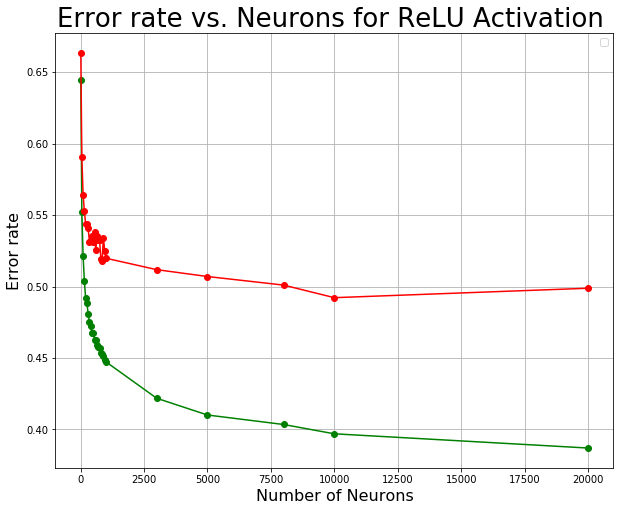

In [0]:
#Drawing error rate vs neurons for relu
plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_relu, Train_error_list_relu, 'go-')
plt.plot(Nron_size_list_relu, Val_error_list_relu, 'ro-')
plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Error rate vs. Neurons for ReLU Activation ', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./performance_relu.png')

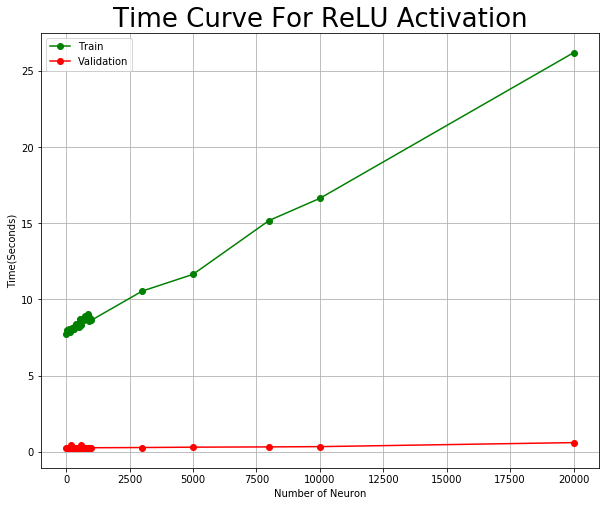

In [0]:
#Drawing train/val time v.s. training set for relu

plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_relu, Train_time_list_relu, 'go-', label = "Train")
plt.plot(Nron_size_list_relu, Val_time_list_relu, 'ro-', label = "Validation")
plt.xlabel('Number of Neuron')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For ReLU Activation', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_relu.png')

## Sigmoid Activation with different Neurons

In [0]:
Nron_size_list_sgmd = []
Train_error_list_sgmd = []
Val_error_list_sgmd = []
Train_time_list_sgmd = []
Val_time_list_sgmd = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 5 # total number of epoch 
epoch = len(X_train_ft_sc)/batch_size # number of steps in one epoch

for j in [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,3000,5000,8000,10000,20000]:

    #### Appending number of neurons                                                                               
    Nron_size_list_sgmd.append(j)
                                                                                    
    print('Neuron_set_size:', j)
    
    
    #### Model building
    
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None)
                                  # model_dir="./models/dnn_clf_/sgmd")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
    
    dnn_clf_sgmd = tf.contrib.learn.DNNClassifier(hidden_units = [j],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.sigmoid,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_sgmd = tf.contrib.learn.SKCompat(dnn_clf_sgmd) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_sgmd.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_sgmd.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_sgmd.predict(X_train_ft_sc) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train, y_train_partial_pred['classes'])# training error
    
    Train_error_list_sgmd.append(Train_error)#append training error
    
    print('dnn_clf_sgmd training time', Train_elapse) 
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_sgmd.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_sgmd.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_sgmd.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Nron_size_list_Sigmoid: ", Nron_size_list_sgmd)
print("Train_error_list_Sigmoid: ", Train_error_list_sgmd)
print("Val_error_list_Sigmoid: ", Val_error_list_sgmd)
print("Train_time_list_Sigmoid: ", Train_time_list_sgmd)
print("Val_time_list_Sigmoid: ", Val_time_list_sgmd)  

('Neuron_set_size:', 10)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6ac6ca2d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpdD6c6k', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdD6c6k/model.ckpt.
INFO:tens

INFO:tensorflow:global_step/sec: 610.934
INFO:tensorflow:loss = 1.8465496, step = 1200 (0.164 sec)
INFO:tensorflow:global_step/sec: 623.566
INFO:tensorflow:loss = 2.1082096, step = 1300 (0.160 sec)
INFO:tensorflow:global_step/sec: 617.17
INFO:tensorflow:loss = 1.8981073, step = 1400 (0.162 sec)
INFO:tensorflow:global_step/sec: 620.081
INFO:tensorflow:loss = 1.8203027, step = 1500 (0.162 sec)
INFO:tensorflow:global_step/sec: 615.68
INFO:tensorflow:loss = 1.8646573, step = 1600 (0.163 sec)
INFO:tensorflow:global_step/sec: 626.759
INFO:tensorflow:loss = 1.8253107, step = 1700 (0.159 sec)
INFO:tensorflow:global_step/sec: 647.521
INFO:tensorflow:loss = 2.0814033, step = 1800 (0.154 sec)
INFO:tensorflow:global_step/sec: 646.387
INFO:tensorflow:loss = 1.819592, step = 1900 (0.155 sec)
INFO:tensorflow:global_step/sec: 643.887
INFO:tensorflow:loss = 1.7772856, step = 2000 (0.155 sec)
INFO:tensorflow:global_step/sec: 643.67
INFO:tensorflow:loss = 1.8582904, step = 2100 (0.156 sec)
INFO:tensorflo

INFO:tensorflow:global_step/sec: 607.171
INFO:tensorflow:loss = 1.8711061, step = 3400 (0.164 sec)
INFO:tensorflow:global_step/sec: 607.8
INFO:tensorflow:loss = 1.8235631, step = 3500 (0.165 sec)
INFO:tensorflow:global_step/sec: 603.544
INFO:tensorflow:loss = 1.6482166, step = 3600 (0.165 sec)
INFO:tensorflow:global_step/sec: 607.718
INFO:tensorflow:loss = 1.9578042, step = 3700 (0.165 sec)
INFO:tensorflow:global_step/sec: 607.489
INFO:tensorflow:loss = 1.9742273, step = 3800 (0.164 sec)
INFO:tensorflow:global_step/sec: 614.364
INFO:tensorflow:loss = 1.7715036, step = 3900 (0.162 sec)
INFO:tensorflow:global_step/sec: 614.821
INFO:tensorflow:loss = 1.6881932, step = 4000 (0.163 sec)
INFO:tensorflow:global_step/sec: 609.801
INFO:tensorflow:loss = 1.5347643, step = 4100 (0.165 sec)
INFO:tensorflow:global_step/sec: 604.025
INFO:tensorflow:loss = 1.7955465, step = 4200 (0.164 sec)
INFO:tensorflow:global_step/sec: 614.149
INFO:tensorflow:loss = 1.8570479, step = 4300 (0.164 sec)
INFO:tensorf

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbQ46YL/model.ckpt.
INFO:tensorflow:loss = 2.631937, step = 0
INFO:tensorflow:global_step/sec: 500.345
INFO:tensorflow:loss = 2.1041703, step = 100 (0.202 sec)
INFO:tensorflow:global_step/sec: 591.926
INFO:tensorflow:loss = 2.042211, step = 200 (0.169 sec)
INFO:tensorflow:global_step/sec: 582.449
INFO:tensorflow:loss = 1.961034, step = 300 (0.172 sec)
INFO:tensorflow:global_step/sec: 590.946
INFO:tensorflow:loss = 1.9832553, step = 400 (0.169 sec)
INFO:tensorflow:global_step/sec: 594.683
INFO:tensorflow:loss = 1.9081575, step = 500 (0.169 sec)
INFO:tensorflow:global_step/sec: 592.182
INFO:tensorflow:loss = 1.748873, step = 600 (0.168 sec)
INFO:tensorflow:global_step/sec: 587.34
INFO:tensorflow:loss = 1.8594711, step = 700 (0.170 sec)
INFO:tensorflow:global_step/sec: 587.48

INFO:tensorflow:global_step/sec: 600.796
INFO:tensorflow:loss = 1.7222834, step = 2000 (0.166 sec)
INFO:tensorflow:global_step/sec: 597.885
INFO:tensorflow:loss = 1.7775437, step = 2100 (0.167 sec)
INFO:tensorflow:global_step/sec: 600.226
INFO:tensorflow:loss = 1.7341222, step = 2200 (0.168 sec)
INFO:tensorflow:global_step/sec: 597.151
INFO:tensorflow:loss = 1.7935545, step = 2300 (0.167 sec)
INFO:tensorflow:global_step/sec: 598.076
INFO:tensorflow:loss = 1.9493783, step = 2400 (0.167 sec)
INFO:tensorflow:global_step/sec: 598.44
INFO:tensorflow:loss = 1.9947565, step = 2500 (0.168 sec)
INFO:tensorflow:global_step/sec: 597.94
INFO:tensorflow:loss = 1.936151, step = 2600 (0.167 sec)
INFO:tensorflow:global_step/sec: 596.68
INFO:tensorflow:loss = 1.970671, step = 2700 (0.168 sec)
INFO:tensorflow:global_step/sec: 594.336
INFO:tensorflow:loss = 1.7694412, step = 2800 (0.168 sec)
INFO:tensorflow:global_step/sec: 596.147
INFO:tensorflow:loss = 1.6020045, step = 2900 (0.168 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 594.835
INFO:tensorflow:loss = 1.8105416, step = 4200 (0.168 sec)
INFO:tensorflow:global_step/sec: 597.864
INFO:tensorflow:loss = 1.8682775, step = 4300 (0.167 sec)
INFO:tensorflow:global_step/sec: 596.634
INFO:tensorflow:loss = 1.8579937, step = 4400 (0.168 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmpFNLcCk/model.ckpt.
INFO:tensorflow:Loss for final step: 1.9346073.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpFNLcCk/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_sgmd training time', 8.551599)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpFNLcCk/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.598111111111111, '/', 0.6175999999999999)
('Neuron_set_size:', 350)
INFO:tensorflow:Using config: {'_save_checkpoints_secs'

INFO:tensorflow:loss = 2.0381386, step = 200 (0.171 sec)
INFO:tensorflow:global_step/sec: 582.387
INFO:tensorflow:loss = 1.9559579, step = 300 (0.172 sec)
INFO:tensorflow:global_step/sec: 584.191
INFO:tensorflow:loss = 1.9563113, step = 400 (0.171 sec)
INFO:tensorflow:global_step/sec: 583.853
INFO:tensorflow:loss = 1.9061885, step = 500 (0.172 sec)
INFO:tensorflow:global_step/sec: 581.578
INFO:tensorflow:loss = 1.8219821, step = 600 (0.172 sec)
INFO:tensorflow:global_step/sec: 581.517
INFO:tensorflow:loss = 1.8509991, step = 700 (0.172 sec)
INFO:tensorflow:global_step/sec: 578.787
INFO:tensorflow:loss = 2.048686, step = 800 (0.173 sec)
INFO:tensorflow:global_step/sec: 576.572
INFO:tensorflow:loss = 1.8329004, step = 900 (0.173 sec)
INFO:tensorflow:global_step/sec: 582.703
INFO:tensorflow:loss = 1.9949276, step = 1000 (0.172 sec)
INFO:tensorflow:global_step/sec: 579.415
INFO:tensorflow:loss = 1.7165742, step = 1100 (0.173 sec)
INFO:tensorflow:global_step/sec: 577.73
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 588.363
INFO:tensorflow:loss = 1.9791903, step = 2400 (0.170 sec)
INFO:tensorflow:global_step/sec: 586.009
INFO:tensorflow:loss = 1.9879861, step = 2500 (0.170 sec)
INFO:tensorflow:global_step/sec: 590.933
INFO:tensorflow:loss = 1.9729701, step = 2600 (0.170 sec)
INFO:tensorflow:global_step/sec: 585.981
INFO:tensorflow:loss = 1.9562188, step = 2700 (0.170 sec)
INFO:tensorflow:global_step/sec: 586.386
INFO:tensorflow:loss = 1.7477028, step = 2800 (0.171 sec)
INFO:tensorflow:global_step/sec: 586.999
INFO:tensorflow:loss = 1.5811237, step = 2900 (0.170 sec)
INFO:tensorflow:global_step/sec: 587.918
INFO:tensorflow:loss = 1.8962045, step = 3000 (0.170 sec)
INFO:tensorflow:global_step/sec: 583.996
INFO:tensorflow:loss = 1.6501459, step = 3100 (0.171 sec)
INFO:tensorflow:global_step/sec: 583.339
INFO:tensorflow:loss = 1.7165363, step = 3200 (0.171 sec)
INFO:tensorflow:global_step/sec: 587.13
INFO:tensorflow:loss = 1.830045, step = 3300 (0.170 sec)
INFO:tensorf

INFO:tensorflow:Loss for final step: 1.9295316.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6R91Xi/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_sgmd training time', 8.612092)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6R91Xi/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5964, '/', 0.6115999999999999)
('Neuron_set_size:', 550)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6bc15c9d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_

INFO:tensorflow:loss = 1.8219568, step = 600 (0.176 sec)
INFO:tensorflow:global_step/sec: 559.889
INFO:tensorflow:loss = 1.8451183, step = 700 (0.179 sec)
INFO:tensorflow:global_step/sec: 575.036
INFO:tensorflow:loss = 2.0103092, step = 800 (0.174 sec)
INFO:tensorflow:global_step/sec: 571.56
INFO:tensorflow:loss = 1.8024281, step = 900 (0.175 sec)
INFO:tensorflow:global_step/sec: 580.433
INFO:tensorflow:loss = 1.9580698, step = 1000 (0.172 sec)
INFO:tensorflow:global_step/sec: 572.695
INFO:tensorflow:loss = 1.7344414, step = 1100 (0.175 sec)
INFO:tensorflow:global_step/sec: 572.768
INFO:tensorflow:loss = 1.7830745, step = 1200 (0.175 sec)
INFO:tensorflow:global_step/sec: 573.967
INFO:tensorflow:loss = 2.1262977, step = 1300 (0.174 sec)
INFO:tensorflow:global_step/sec: 575.685
INFO:tensorflow:loss = 1.825226, step = 1400 (0.174 sec)
INFO:tensorflow:global_step/sec: 582.363
INFO:tensorflow:loss = 1.7151687, step = 1500 (0.171 sec)
INFO:tensorflow:global_step/sec: 575.024
INFO:tensorflow:

INFO:tensorflow:loss = 1.6884094, step = 2800 (0.173 sec)
INFO:tensorflow:global_step/sec: 582.177
INFO:tensorflow:loss = 1.6166188, step = 2900 (0.172 sec)
INFO:tensorflow:global_step/sec: 581.818
INFO:tensorflow:loss = 1.8280765, step = 3000 (0.172 sec)
INFO:tensorflow:global_step/sec: 575.163
INFO:tensorflow:loss = 1.6397736, step = 3100 (0.173 sec)
INFO:tensorflow:global_step/sec: 584.218
INFO:tensorflow:loss = 1.7092863, step = 3200 (0.172 sec)
INFO:tensorflow:global_step/sec: 582.608
INFO:tensorflow:loss = 1.7795132, step = 3300 (0.171 sec)
INFO:tensorflow:global_step/sec: 579.703
INFO:tensorflow:loss = 1.8689184, step = 3400 (0.173 sec)
INFO:tensorflow:global_step/sec: 581.105
INFO:tensorflow:loss = 1.7696412, step = 3500 (0.172 sec)
INFO:tensorflow:global_step/sec: 580.017
INFO:tensorflow:loss = 1.6224823, step = 3600 (0.173 sec)
INFO:tensorflow:global_step/sec: 581.774
INFO:tensorflow:loss = 1.9369506, step = 3700 (0.172 sec)
INFO:tensorflow:global_step/sec: 579.905
INFO:tenso

('Train error, Val_error', 0.5946, '/', 0.6126)
('Neuron_set_size:', 750)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6bc185410>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmp8fbhLU', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoint

INFO:tensorflow:loss = 1.6587485, step = 1100 (0.180 sec)
INFO:tensorflow:global_step/sec: 566.37
INFO:tensorflow:loss = 1.7827156, step = 1200 (0.176 sec)
INFO:tensorflow:global_step/sec: 565.023
INFO:tensorflow:loss = 2.0857575, step = 1300 (0.177 sec)
INFO:tensorflow:global_step/sec: 557.442
INFO:tensorflow:loss = 1.7848848, step = 1400 (0.179 sec)
INFO:tensorflow:global_step/sec: 564.576
INFO:tensorflow:loss = 1.7317544, step = 1500 (0.178 sec)
INFO:tensorflow:global_step/sec: 569.781
INFO:tensorflow:loss = 1.8266823, step = 1600 (0.175 sec)
INFO:tensorflow:global_step/sec: 563.819
INFO:tensorflow:loss = 1.7151594, step = 1700 (0.177 sec)
INFO:tensorflow:global_step/sec: 565.841
INFO:tensorflow:loss = 2.058828, step = 1800 (0.177 sec)
INFO:tensorflow:global_step/sec: 567.47
INFO:tensorflow:loss = 1.7030331, step = 1900 (0.176 sec)
INFO:tensorflow:global_step/sec: 561.769
INFO:tensorflow:loss = 1.7466081, step = 2000 (0.179 sec)
INFO:tensorflow:global_step/sec: 562.015
INFO:tensorfl

INFO:tensorflow:global_step/sec: 562.433
INFO:tensorflow:loss = 1.7974609, step = 3300 (0.179 sec)
INFO:tensorflow:global_step/sec: 554.96
INFO:tensorflow:loss = 1.8645977, step = 3400 (0.179 sec)
INFO:tensorflow:global_step/sec: 564.271
INFO:tensorflow:loss = 1.7825078, step = 3500 (0.178 sec)
INFO:tensorflow:global_step/sec: 554.927
INFO:tensorflow:loss = 1.6165973, step = 3600 (0.180 sec)
INFO:tensorflow:global_step/sec: 555.53
INFO:tensorflow:loss = 1.9355416, step = 3700 (0.181 sec)
INFO:tensorflow:global_step/sec: 560.124
INFO:tensorflow:loss = 1.9724131, step = 3800 (0.178 sec)
INFO:tensorflow:global_step/sec: 566.482
INFO:tensorflow:loss = 1.7298871, step = 3900 (0.177 sec)
INFO:tensorflow:global_step/sec: 556.656
INFO:tensorflow:loss = 1.6360573, step = 4000 (0.180 sec)
INFO:tensorflow:global_step/sec: 566.942
INFO:tensorflow:loss = 1.4873184, step = 4100 (0.176 sec)
INFO:tensorflow:global_step/sec: 560.051
INFO:tensorflow:loss = 1.7901306, step = 4200 (0.178 sec)
INFO:tensorf

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpNF_lNn/model.ckpt.
INFO:tensorflow:loss = 2.5884826, step = 0
INFO:tensorflow:global_step/sec: 488.568
INFO:tensorflow:loss = 2.0087974, step = 100 (0.206 sec)
INFO:tensorflow:global_step/sec: 566.781
INFO:tensorflow:loss = 2.011142, step = 200 (0.177 sec)
INFO:tensorflow:global_step/sec: 559.478
INFO:tensorflow:loss = 1.9293512, step = 300 (0.179 sec)
INFO:tensorflow:global_step/sec: 562.205
INFO:tensorflow:loss = 1.960349, step = 400 (0.178 sec)
INFO:tensorflow:global_step/sec: 563.826
INFO:tensorflow:loss = 1.8655287, step = 500 (0.177 sec)
INFO:tensorflow:global_step/sec: 563.081
INFO:tensorflow:loss = 1.7519367, step = 600 (0.177 sec)
INFO:tensorflow:global_step/sec: 562.968
INFO:tensorflow:loss = 1.8576066, step = 700 (0.178 sec)
INFO:tensorflow:global_step/sec: 557

INFO:tensorflow:global_step/sec: 559.512
INFO:tensorflow:loss = 1.7180889, step = 2000 (0.178 sec)
INFO:tensorflow:global_step/sec: 563.984
INFO:tensorflow:loss = 1.7684888, step = 2100 (0.178 sec)
INFO:tensorflow:global_step/sec: 554.478
INFO:tensorflow:loss = 1.7083077, step = 2200 (0.180 sec)
INFO:tensorflow:global_step/sec: 554.246
INFO:tensorflow:loss = 1.7727829, step = 2300 (0.180 sec)
INFO:tensorflow:global_step/sec: 557.494
INFO:tensorflow:loss = 1.9565349, step = 2400 (0.180 sec)
INFO:tensorflow:global_step/sec: 558.775
INFO:tensorflow:loss = 2.0297315, step = 2500 (0.179 sec)
INFO:tensorflow:global_step/sec: 554.739
INFO:tensorflow:loss = 1.971187, step = 2600 (0.180 sec)
INFO:tensorflow:global_step/sec: 553.86
INFO:tensorflow:loss = 1.9716028, step = 2700 (0.181 sec)
INFO:tensorflow:global_step/sec: 551.84
INFO:tensorflow:loss = 1.6976829, step = 2800 (0.181 sec)
INFO:tensorflow:global_step/sec: 547.945
INFO:tensorflow:loss = 1.6136044, step = 2900 (0.182 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 477.717
INFO:tensorflow:loss = 1.7832206, step = 4200 (0.209 sec)
INFO:tensorflow:global_step/sec: 478.98
INFO:tensorflow:loss = 1.9012128, step = 4300 (0.209 sec)
INFO:tensorflow:global_step/sec: 479.102
INFO:tensorflow:loss = 1.8437024, step = 4400 (0.208 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmpArV__h/model.ckpt.
INFO:tensorflow:Loss for final step: 1.9395007.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpArV__h/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_sgmd training time', 10.341705)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpArV__h/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5909777777777778, '/', 0.609)
('Neuron_set_size:', 5000)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_nu

INFO:tensorflow:loss = 2.0171068, step = 200 (0.308 sec)
INFO:tensorflow:global_step/sec: 328.189
INFO:tensorflow:loss = 1.8116244, step = 300 (0.305 sec)
INFO:tensorflow:global_step/sec: 327.953
INFO:tensorflow:loss = 1.8989115, step = 400 (0.305 sec)
INFO:tensorflow:global_step/sec: 330.469
INFO:tensorflow:loss = 1.8638419, step = 500 (0.302 sec)
INFO:tensorflow:global_step/sec: 328.586
INFO:tensorflow:loss = 1.7034436, step = 600 (0.305 sec)
INFO:tensorflow:global_step/sec: 327.387
INFO:tensorflow:loss = 1.8344414, step = 700 (0.306 sec)
INFO:tensorflow:global_step/sec: 330.497
INFO:tensorflow:loss = 1.9678407, step = 800 (0.302 sec)
INFO:tensorflow:global_step/sec: 329.484
INFO:tensorflow:loss = 1.8226752, step = 900 (0.304 sec)
INFO:tensorflow:global_step/sec: 330.788
INFO:tensorflow:loss = 1.9705026, step = 1000 (0.302 sec)
INFO:tensorflow:global_step/sec: 329.829
INFO:tensorflow:loss = 1.625628, step = 1100 (0.303 sec)
INFO:tensorflow:global_step/sec: 327.771
INFO:tensorflow:los

INFO:tensorflow:loss = 1.9280456, step = 2400 (0.332 sec)
INFO:tensorflow:global_step/sec: 301.527
INFO:tensorflow:loss = 2.0264146, step = 2500 (0.331 sec)
INFO:tensorflow:global_step/sec: 302.109
INFO:tensorflow:loss = 1.9723338, step = 2600 (0.331 sec)
INFO:tensorflow:global_step/sec: 303.158
INFO:tensorflow:loss = 1.9423568, step = 2700 (0.330 sec)
INFO:tensorflow:global_step/sec: 301.571
INFO:tensorflow:loss = 1.7261231, step = 2800 (0.331 sec)
INFO:tensorflow:global_step/sec: 301.579
INFO:tensorflow:loss = 1.5923126, step = 2900 (0.332 sec)
INFO:tensorflow:global_step/sec: 301.739
INFO:tensorflow:loss = 1.8405228, step = 3000 (0.331 sec)
INFO:tensorflow:global_step/sec: 298.675
INFO:tensorflow:loss = 1.6326163, step = 3100 (0.335 sec)
INFO:tensorflow:global_step/sec: 298.181
INFO:tensorflow:loss = 1.7032776, step = 3200 (0.336 sec)
INFO:tensorflow:global_step/sec: 301.088
INFO:tensorflow:loss = 1.7627674, step = 3300 (0.332 sec)
INFO:tensorflow:global_step/sec: 301.623
INFO:tenso

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj8r_RS/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_sgmd training time', 25.855159)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj8r_RS/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5900222222222222, '/', 0.6046)
('Nron_size_list_Sigmoid: ', [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 3000, 5000, 8000, 10000, 20000])
('Train_error_list_Sigmoid: ', [0.7069555555555556, 0.6152666666666666, 0.6020222222222222, 0.6008, 0.5993111111111111, 0.5992444444444445, 0.598111111111111, 0.5962666666666667, 0.5963777777777778, 0.5963333333333334, 0.5964, 0.5952444444444445, 0.594111111111111, 0.5948, 0.5946, 0.5932, 0.5933555555555556, 0.5957111111111111, 0.5946444444444

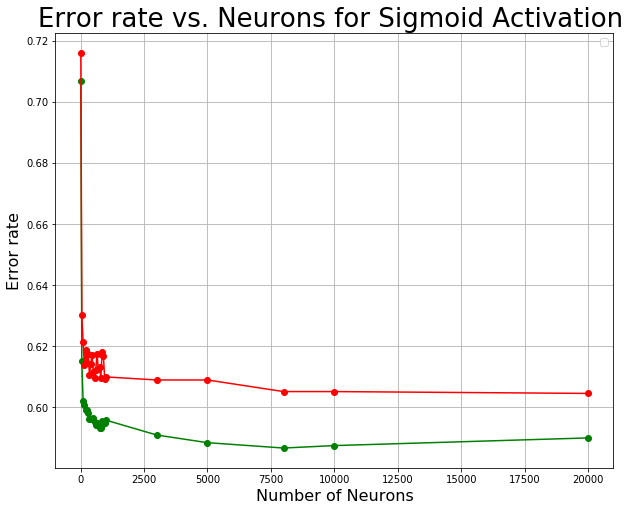

In [0]:
#Drawing error rate vs neurons for sigmoid
plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_sgmd, Train_error_list_sgmd, 'go-')
plt.plot(Nron_size_list_sgmd, Val_error_list_sgmd, 'ro-')
plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Error rate vs. Neurons for Sigmoid Activation ', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./performance_sgmd.png')

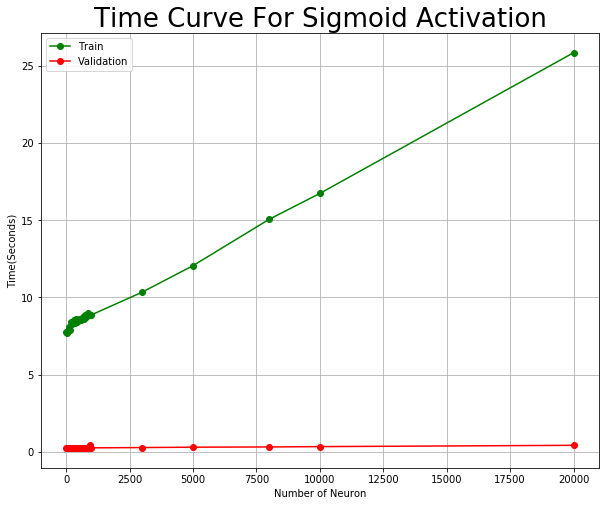

In [0]:
#Drawing train/val time v.s. training set for sigmoid

plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_sgmd, Train_time_list_sgmd, 'go-', label = "Train")
plt.plot(Nron_size_list_sgmd, Val_time_list_sgmd, 'ro-', label = "Validation")
plt.xlabel('Number of Neuron')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For Sigmoid Activation', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_sgmd.png')

## Tanh Activation with different Neurons

In [0]:
Nron_size_list_tanh = []
Train_error_list_tanh = []
Val_error_list_tanh = []
Train_time_list_tanh = []
Val_time_list_tanh = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 5 # total number of epoch 
epoch = len(X_train_ft_sc)/batch_size # number of steps in one epoch

for j in [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,3000,5000,8000,10000,20000]:

    #### Appending number of neurons                                                                               
    Nron_size_list_tanh.append(j)
                                                                                    
    print('Neuron_set_size:', j)
    
    
    #### Model building
    
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None)
                                  # model_dir="./models/dnn_clf_/tanh")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
    
    dnn_clf_tanh = tf.contrib.learn.DNNClassifier(hidden_units = [j],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.tanh,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_tanh = tf.contrib.learn.SKCompat(dnn_clf_tanh) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_tanh.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_tanh.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_tanh.predict(X_train_ft_sc) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train, y_train_partial_pred['classes'])# training error
    
    Train_error_list_tanh.append(Train_error)#append training error
    
    print('dnn_clf_tanh training time', Train_elapse) 
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_tanh.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_tanh.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_tanh.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Nron_size_list_Tanh: ", Nron_size_list_tanh)
print("Train_error_list_Tanh: ", Train_error_list_tanh)
print("Val_error_list_Tanh: ", Val_error_list_tanh)
print("Train_time_list_Tanh: ", Train_time_list_tanh)
print("Val_time_list_Tanh: ", Val_time_list_tanh)  

('Neuron_set_size:', 10)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6a47a74d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpfn5Hvf', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpfn5Hvf/model.ckpt.
INFO:tens

INFO:tensorflow:global_step/sec: 622.886
INFO:tensorflow:loss = 1.703156, step = 1200 (0.160 sec)
INFO:tensorflow:global_step/sec: 620.94
INFO:tensorflow:loss = 2.0273728, step = 1300 (0.161 sec)
INFO:tensorflow:global_step/sec: 618.835
INFO:tensorflow:loss = 1.7734303, step = 1400 (0.162 sec)
INFO:tensorflow:global_step/sec: 627.53
INFO:tensorflow:loss = 1.599998, step = 1500 (0.159 sec)
INFO:tensorflow:global_step/sec: 620.563
INFO:tensorflow:loss = 1.7212708, step = 1600 (0.161 sec)
INFO:tensorflow:global_step/sec: 635.975
INFO:tensorflow:loss = 1.7623465, step = 1700 (0.157 sec)
INFO:tensorflow:global_step/sec: 627.66
INFO:tensorflow:loss = 1.9859467, step = 1800 (0.159 sec)
INFO:tensorflow:global_step/sec: 633.011
INFO:tensorflow:loss = 1.5956079, step = 1900 (0.158 sec)
INFO:tensorflow:global_step/sec: 616.117
INFO:tensorflow:loss = 1.6119412, step = 2000 (0.162 sec)
INFO:tensorflow:global_step/sec: 615.237
INFO:tensorflow:loss = 1.6985693, step = 2100 (0.162 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 633.809
INFO:tensorflow:loss = 1.8115876, step = 3400 (0.157 sec)
INFO:tensorflow:global_step/sec: 643.289
INFO:tensorflow:loss = 1.7180128, step = 3500 (0.156 sec)
INFO:tensorflow:global_step/sec: 633.413
INFO:tensorflow:loss = 1.4710479, step = 3600 (0.158 sec)
INFO:tensorflow:global_step/sec: 640.103
INFO:tensorflow:loss = 1.8506318, step = 3700 (0.156 sec)
INFO:tensorflow:global_step/sec: 644.94
INFO:tensorflow:loss = 1.8993404, step = 3800 (0.155 sec)
INFO:tensorflow:global_step/sec: 642.381
INFO:tensorflow:loss = 1.6479927, step = 3900 (0.156 sec)
INFO:tensorflow:global_step/sec: 646.119
INFO:tensorflow:loss = 1.5605118, step = 4000 (0.154 sec)
INFO:tensorflow:global_step/sec: 641.334
INFO:tensorflow:loss = 1.3628765, step = 4100 (0.155 sec)
INFO:tensorflow:global_step/sec: 640.3
INFO:tensorflow:loss = 1.6554351, step = 4200 (0.157 sec)
INFO:tensorflow:global_step/sec: 647.127
INFO:tensorflow:loss = 1.7323002, step = 4300 (0.154 sec)
INFO:tensorfl

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6jXtUw/model.ckpt.
INFO:tensorflow:loss = 2.5449545, step = 0
INFO:tensorflow:global_step/sec: 533.863
INFO:tensorflow:loss = 1.9986786, step = 100 (0.189 sec)
INFO:tensorflow:global_step/sec: 619.391
INFO:tensorflow:loss = 1.8342445, step = 200 (0.162 sec)
INFO:tensorflow:global_step/sec: 622.856
INFO:tensorflow:loss = 1.9038845, step = 300 (0.160 sec)
INFO:tensorflow:global_step/sec: 627.152
INFO:tensorflow:loss = 1.8706082, step = 400 (0.160 sec)
INFO:tensorflow:global_step/sec: 621.411
INFO:tensorflow:loss = 1.7972345, step = 500 (0.161 sec)
INFO:tensorflow:global_step/sec: 625.771
INFO:tensorflow:loss = 1.541409, step = 600 (0.160 sec)
INFO:tensorflow:global_step/sec: 624.914
INFO:tensorflow:loss = 1.790682, step = 700 (0.160 sec)
INFO:tensorflow:global_step/sec: 627

INFO:tensorflow:global_step/sec: 593.299
INFO:tensorflow:loss = 1.5851865, step = 2000 (0.170 sec)
INFO:tensorflow:global_step/sec: 596.207
INFO:tensorflow:loss = 1.5568069, step = 2100 (0.167 sec)
INFO:tensorflow:global_step/sec: 598.946
INFO:tensorflow:loss = 1.6650381, step = 2200 (0.167 sec)
INFO:tensorflow:global_step/sec: 606.565
INFO:tensorflow:loss = 1.7386049, step = 2300 (0.165 sec)
INFO:tensorflow:global_step/sec: 598.343
INFO:tensorflow:loss = 1.944779, step = 2400 (0.167 sec)
INFO:tensorflow:global_step/sec: 594.513
INFO:tensorflow:loss = 1.9417148, step = 2500 (0.168 sec)
INFO:tensorflow:global_step/sec: 595.387
INFO:tensorflow:loss = 1.8584563, step = 2600 (0.168 sec)
INFO:tensorflow:global_step/sec: 595.164
INFO:tensorflow:loss = 1.7946613, step = 2700 (0.168 sec)
INFO:tensorflow:global_step/sec: 588.222
INFO:tensorflow:loss = 1.6985577, step = 2800 (0.170 sec)
INFO:tensorflow:global_step/sec: 589.643
INFO:tensorflow:loss = 1.402643, step = 2900 (0.169 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 595.93
INFO:tensorflow:loss = 1.6241808, step = 4200 (0.167 sec)
INFO:tensorflow:global_step/sec: 596.69
INFO:tensorflow:loss = 1.6773872, step = 4300 (0.168 sec)
INFO:tensorflow:global_step/sec: 600.879
INFO:tensorflow:loss = 1.7379538, step = 4400 (0.167 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmpqK9pHq/model.ckpt.
INFO:tensorflow:Loss for final step: 1.7546941.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpqK9pHq/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_tanh training time', 8.227046)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpqK9pHq/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5357111111111111, '/', 0.5876)
('Neuron_set_size:', 350)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_

INFO:tensorflow:loss = 1.751392, step = 200 (0.174 sec)
INFO:tensorflow:global_step/sec: 592.975
INFO:tensorflow:loss = 1.8782074, step = 300 (0.168 sec)
INFO:tensorflow:global_step/sec: 597.165
INFO:tensorflow:loss = 1.8133109, step = 400 (0.167 sec)
INFO:tensorflow:global_step/sec: 598.308
INFO:tensorflow:loss = 1.7718674, step = 500 (0.167 sec)
INFO:tensorflow:global_step/sec: 585.491
INFO:tensorflow:loss = 1.6690441, step = 600 (0.171 sec)
INFO:tensorflow:global_step/sec: 596.285
INFO:tensorflow:loss = 1.7468245, step = 700 (0.168 sec)
INFO:tensorflow:global_step/sec: 589.449
INFO:tensorflow:loss = 2.0403779, step = 800 (0.170 sec)
INFO:tensorflow:global_step/sec: 595.345
INFO:tensorflow:loss = 1.7130448, step = 900 (0.168 sec)
INFO:tensorflow:global_step/sec: 589.491
INFO:tensorflow:loss = 1.9058233, step = 1000 (0.170 sec)
INFO:tensorflow:global_step/sec: 595.075
INFO:tensorflow:loss = 1.6122217, step = 1100 (0.167 sec)
INFO:tensorflow:global_step/sec: 589.813
INFO:tensorflow:los

INFO:tensorflow:loss = 1.9899651, step = 2400 (0.167 sec)
INFO:tensorflow:global_step/sec: 590.73
INFO:tensorflow:loss = 1.9462723, step = 2500 (0.170 sec)
INFO:tensorflow:global_step/sec: 589.303
INFO:tensorflow:loss = 1.9360129, step = 2600 (0.170 sec)
INFO:tensorflow:global_step/sec: 586.081
INFO:tensorflow:loss = 1.7475694, step = 2700 (0.171 sec)
INFO:tensorflow:global_step/sec: 591.71
INFO:tensorflow:loss = 1.6120225, step = 2800 (0.169 sec)
INFO:tensorflow:global_step/sec: 589.268
INFO:tensorflow:loss = 1.3599343, step = 2900 (0.169 sec)
INFO:tensorflow:global_step/sec: 594.294
INFO:tensorflow:loss = 1.8141942, step = 3000 (0.167 sec)
INFO:tensorflow:global_step/sec: 589.07
INFO:tensorflow:loss = 1.5225177, step = 3100 (0.170 sec)
INFO:tensorflow:global_step/sec: 587.741
INFO:tensorflow:loss = 1.6810029, step = 3200 (0.170 sec)
INFO:tensorflow:global_step/sec: 587.278
INFO:tensorflow:loss = 1.6753018, step = 3300 (0.171 sec)
INFO:tensorflow:global_step/sec: 588.246
INFO:tensorfl

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpDMW_29/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_tanh training time', 8.39272)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpDMW_29/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5272888888888889, '/', 0.585)
('Neuron_set_size:', 550)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6ac67c210>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpvGGn

INFO:tensorflow:global_step/sec: 572.846
INFO:tensorflow:loss = 1.7480986, step = 700 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.247
INFO:tensorflow:loss = 1.9739407, step = 800 (0.174 sec)
INFO:tensorflow:global_step/sec: 571.36
INFO:tensorflow:loss = 1.6330663, step = 900 (0.175 sec)
INFO:tensorflow:global_step/sec: 577.061
INFO:tensorflow:loss = 1.7926133, step = 1000 (0.174 sec)
INFO:tensorflow:global_step/sec: 573.013
INFO:tensorflow:loss = 1.6338577, step = 1100 (0.175 sec)
INFO:tensorflow:global_step/sec: 580.124
INFO:tensorflow:loss = 1.6172639, step = 1200 (0.172 sec)
INFO:tensorflow:global_step/sec: 579.529
INFO:tensorflow:loss = 2.095168, step = 1300 (0.172 sec)
INFO:tensorflow:global_step/sec: 577.714
INFO:tensorflow:loss = 1.7775998, step = 1400 (0.174 sec)
INFO:tensorflow:global_step/sec: 566.945
INFO:tensorflow:loss = 1.5834159, step = 1500 (0.176 sec)
INFO:tensorflow:global_step/sec: 569.933
INFO:tensorflow:loss = 1.7161744, step = 1600 (0.176 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 573.204
INFO:tensorflow:loss = 1.4293993, step = 2900 (0.174 sec)
INFO:tensorflow:global_step/sec: 573.5
INFO:tensorflow:loss = 1.729361, step = 3000 (0.175 sec)
INFO:tensorflow:global_step/sec: 569.654
INFO:tensorflow:loss = 1.5102355, step = 3100 (0.176 sec)
INFO:tensorflow:global_step/sec: 562.886
INFO:tensorflow:loss = 1.596353, step = 3200 (0.178 sec)
INFO:tensorflow:global_step/sec: 567.769
INFO:tensorflow:loss = 1.609967, step = 3300 (0.176 sec)
INFO:tensorflow:global_step/sec: 565.323
INFO:tensorflow:loss = 1.7271097, step = 3400 (0.177 sec)
INFO:tensorflow:global_step/sec: 566.415
INFO:tensorflow:loss = 1.569962, step = 3500 (0.176 sec)
INFO:tensorflow:global_step/sec: 569.953
INFO:tensorflow:loss = 1.4297718, step = 3600 (0.176 sec)
INFO:tensorflow:global_step/sec: 570.418
INFO:tensorflow:loss = 1.7150147, step = 3700 (0.175 sec)
INFO:tensorflow:global_step/sec: 576.748
INFO:tensorflow:loss = 1.9227421, step = 3800 (0.173 sec)
INFO:tensorflow:

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6b47edc50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpjiBflo', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjiBflo/model.ckpt.
INFO:tensorflow:loss = 2.4728024, 

INFO:tensorflow:global_step/sec: 589.178
INFO:tensorflow:loss = 2.0170472, step = 1300 (0.170 sec)
INFO:tensorflow:global_step/sec: 587.482
INFO:tensorflow:loss = 1.6360735, step = 1400 (0.171 sec)
INFO:tensorflow:global_step/sec: 588.97
INFO:tensorflow:loss = 1.673409, step = 1500 (0.170 sec)
INFO:tensorflow:global_step/sec: 589.317
INFO:tensorflow:loss = 1.7362735, step = 1600 (0.169 sec)
INFO:tensorflow:global_step/sec: 584.634
INFO:tensorflow:loss = 1.5796913, step = 1700 (0.171 sec)
INFO:tensorflow:global_step/sec: 579.98
INFO:tensorflow:loss = 1.9248635, step = 1800 (0.173 sec)
INFO:tensorflow:global_step/sec: 589.348
INFO:tensorflow:loss = 1.5348057, step = 1900 (0.170 sec)
INFO:tensorflow:global_step/sec: 587.169
INFO:tensorflow:loss = 1.6317399, step = 2000 (0.169 sec)
INFO:tensorflow:global_step/sec: 588.911
INFO:tensorflow:loss = 1.5461972, step = 2100 (0.171 sec)
INFO:tensorflow:global_step/sec: 587.485
INFO:tensorflow:loss = 1.6449151, step = 2200 (0.169 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 568.769
INFO:tensorflow:loss = 1.6084757, step = 3500 (0.176 sec)
INFO:tensorflow:global_step/sec: 561.483
INFO:tensorflow:loss = 1.4688148, step = 3600 (0.178 sec)
INFO:tensorflow:global_step/sec: 565.384
INFO:tensorflow:loss = 1.6826216, step = 3700 (0.177 sec)
INFO:tensorflow:global_step/sec: 568.182
INFO:tensorflow:loss = 1.9675641, step = 3800 (0.175 sec)
INFO:tensorflow:global_step/sec: 569.57
INFO:tensorflow:loss = 1.55647, step = 3900 (0.176 sec)
INFO:tensorflow:global_step/sec: 554.308
INFO:tensorflow:loss = 1.4368906, step = 4000 (0.180 sec)
INFO:tensorflow:global_step/sec: 564.433
INFO:tensorflow:loss = 1.3104272, step = 4100 (0.177 sec)
INFO:tensorflow:global_step/sec: 562.927
INFO:tensorflow:loss = 1.4951957, step = 4200 (0.178 sec)
INFO:tensorflow:global_step/sec: 558.275
INFO:tensorflow:loss = 1.6570792, step = 4300 (0.180 sec)
INFO:tensorflow:global_step/sec: 556.743
INFO:tensorflow:loss = 1.7528851, step = 4400 (0.180 sec)
INFO:tensorfl

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpWzCEIP/model.ckpt.
INFO:tensorflow:loss = 2.5965998, step = 0
INFO:tensorflow:global_step/sec: 484.391
INFO:tensorflow:loss = 1.8553578, step = 100 (0.208 sec)
INFO:tensorflow:global_step/sec: 560.79
INFO:tensorflow:loss = 1.766602, step = 200 (0.178 sec)
INFO:tensorflow:global_step/sec: 554.41
INFO:tensorflow:loss = 1.9246608, step = 300 (0.181 sec)
INFO:tensorflow:global_step/sec: 548.314
INFO:tensorflow:loss = 1.8895328, step = 400 (0.182 sec)
INFO:tensorflow:global_step/sec: 542.726
INFO:tensorflow:loss = 1.8163872, step = 500 (0.184 sec)
INFO:tensorflow:global_step/sec: 543.857
INFO:tensorflow:loss = 1.632808, step = 600 (0.184 sec)
INFO:tensorflow:global_step/sec: 542.738
INFO:tensorflow:loss = 1.7768406, step = 700 (0.185 sec)
INFO:tensorflow:global_step/sec: 544.3

INFO:tensorflow:global_step/sec: 548.561
INFO:tensorflow:loss = 1.5943058, step = 2000 (0.183 sec)
INFO:tensorflow:global_step/sec: 549.457
INFO:tensorflow:loss = 1.5259826, step = 2100 (0.182 sec)
INFO:tensorflow:global_step/sec: 550.91
INFO:tensorflow:loss = 1.5489699, step = 2200 (0.182 sec)
INFO:tensorflow:global_step/sec: 542.632
INFO:tensorflow:loss = 1.683724, step = 2300 (0.183 sec)
INFO:tensorflow:global_step/sec: 549.454
INFO:tensorflow:loss = 1.9703463, step = 2400 (0.183 sec)
INFO:tensorflow:global_step/sec: 549.143
INFO:tensorflow:loss = 1.983158, step = 2500 (0.182 sec)
INFO:tensorflow:global_step/sec: 543.419
INFO:tensorflow:loss = 1.9079394, step = 2600 (0.184 sec)
INFO:tensorflow:global_step/sec: 549.571
INFO:tensorflow:loss = 1.6811911, step = 2700 (0.182 sec)
INFO:tensorflow:global_step/sec: 550.276
INFO:tensorflow:loss = 1.6413562, step = 2800 (0.181 sec)
INFO:tensorflow:global_step/sec: 550.076
INFO:tensorflow:loss = 1.4356236, step = 2900 (0.182 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 478.829
INFO:tensorflow:loss = 1.4935391, step = 4200 (0.209 sec)
INFO:tensorflow:global_step/sec: 481.623
INFO:tensorflow:loss = 1.6005063, step = 4300 (0.208 sec)
INFO:tensorflow:global_step/sec: 476.429
INFO:tensorflow:loss = 1.6365707, step = 4400 (0.210 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmpGXtoDz/model.ckpt.
INFO:tensorflow:Loss for final step: 1.6151522.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpGXtoDz/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_tanh training time', 10.545615)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpGXtoDz/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5005777777777778, '/', 0.5656)
('Neuron_set_size:', 5000)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_

INFO:tensorflow:loss = 1.819852, step = 200 (0.308 sec)
INFO:tensorflow:global_step/sec: 325.01
INFO:tensorflow:loss = 1.7533133, step = 300 (0.308 sec)
INFO:tensorflow:global_step/sec: 327.078
INFO:tensorflow:loss = 1.6909845, step = 400 (0.306 sec)
INFO:tensorflow:global_step/sec: 329.142
INFO:tensorflow:loss = 1.7455989, step = 500 (0.304 sec)
INFO:tensorflow:global_step/sec: 327.531
INFO:tensorflow:loss = 1.5815219, step = 600 (0.305 sec)
INFO:tensorflow:global_step/sec: 324.64
INFO:tensorflow:loss = 1.7673569, step = 700 (0.308 sec)
INFO:tensorflow:global_step/sec: 327.21
INFO:tensorflow:loss = 1.8435266, step = 800 (0.306 sec)
INFO:tensorflow:global_step/sec: 327.977
INFO:tensorflow:loss = 1.6967474, step = 900 (0.305 sec)
INFO:tensorflow:global_step/sec: 322.307
INFO:tensorflow:loss = 1.8341016, step = 1000 (0.310 sec)
INFO:tensorflow:global_step/sec: 324.09
INFO:tensorflow:loss = 1.5663348, step = 1100 (0.309 sec)
INFO:tensorflow:global_step/sec: 324.116
INFO:tensorflow:loss = 

INFO:tensorflow:global_step/sec: 292.822
INFO:tensorflow:loss = 2.015834, step = 2400 (0.341 sec)
INFO:tensorflow:global_step/sec: 295.24
INFO:tensorflow:loss = 1.9315594, step = 2500 (0.339 sec)
INFO:tensorflow:global_step/sec: 294.969
INFO:tensorflow:loss = 1.9354705, step = 2600 (0.339 sec)
INFO:tensorflow:global_step/sec: 292.844
INFO:tensorflow:loss = 1.6326663, step = 2700 (0.342 sec)
INFO:tensorflow:global_step/sec: 295.459
INFO:tensorflow:loss = 1.6457529, step = 2800 (0.338 sec)
INFO:tensorflow:global_step/sec: 289.671
INFO:tensorflow:loss = 1.3338696, step = 2900 (0.345 sec)
INFO:tensorflow:global_step/sec: 291.997
INFO:tensorflow:loss = 1.7152809, step = 3000 (0.343 sec)
INFO:tensorflow:global_step/sec: 290.283
INFO:tensorflow:loss = 1.4803948, step = 3100 (0.344 sec)
INFO:tensorflow:global_step/sec: 295.761
INFO:tensorflow:loss = 1.5937473, step = 3200 (0.338 sec)
INFO:tensorflow:global_step/sec: 294.402
INFO:tensorflow:loss = 1.5659499, step = 3300 (0.340 sec)
INFO:tensorf

INFO:tensorflow:Loss for final step: 1.6815671.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpYI8k6t/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_tanh training time', 26.700383)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpYI8k6t/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.5267777777777778, '/', 0.5778)
('Nron_size_list_Tanh: ', [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 3000, 5000, 8000, 10000, 20000])
('Train_error_list_Tanh: ', [0.6552888888888888, 0.5771333333333333, 0.5606222222222222, 0.5522666666666667, 0.5495555555555556, 0.5418222222222222, 0.5357111111111111, 0.5343555555555555, 0.5322, 0.5310666666666667, 0.5272888888888889, 0.5232, 0.5224666666666666, 0.5238666666666667, 0.5202, 0.51857

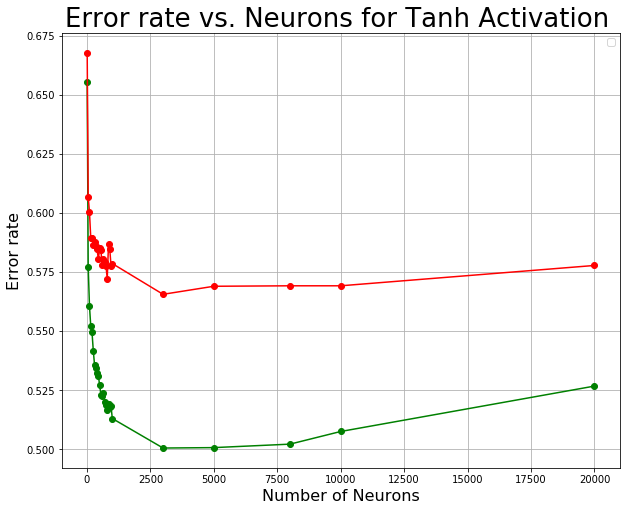

In [0]:
#Drawing error rate vs neurons for Tanh
plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_tanh, Train_error_list_tanh, 'go-')
plt.plot(Nron_size_list_tanh, Val_error_list_tanh, 'ro-')
plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Error rate vs. Neurons for Tanh Activation ', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./performance_tanh.png')

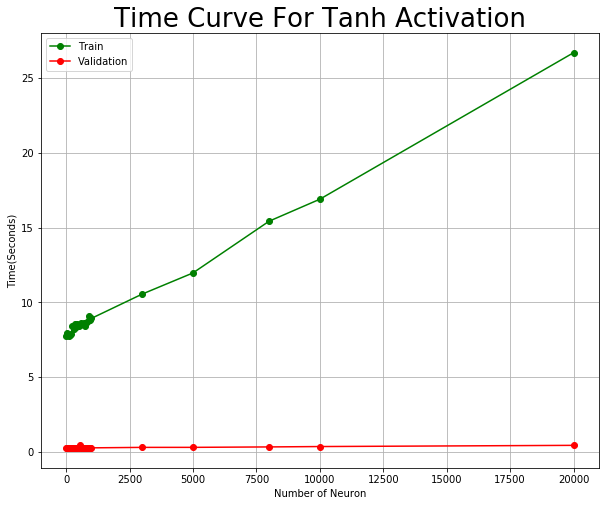

In [0]:
#Drawing train/val time v.s. training set for tanh

plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_tanh, Train_time_list_tanh, 'go-', label = "Train")
plt.plot(Nron_size_list_tanh, Val_time_list_tanh, 'ro-', label = "Validation")
plt.xlabel('Number of Neuron')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For Tanh Activation', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_tanh.png')

## Softmax Activation with different Neurons

In [0]:
Nron_size_list_smax = []
Train_error_list_smax = []
Val_error_list_smax = []
Train_time_list_smax = []
Val_time_list_smax = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 5 # total number of epoch 
epoch = len(X_train_ft_sc)/batch_size # number of steps in one epoch

for j in [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,3000,5000,8000,10000,20000]:

    #### Appending number of neurons                                                                               
    Nron_size_list_smax.append(j)
                                                                                    
    print('Neuron_set_size:', j)
    
    
    #### Model building
    
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None)
                                  # model_dir="./models/dnn_clf_/smax")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
    
    dnn_clf_smax = tf.contrib.learn.DNNClassifier(hidden_units = [j],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.softmax,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_smax = tf.contrib.learn.SKCompat(dnn_clf_smax) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_smax.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_smax.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_smax.predict(X_train_ft_sc) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train, y_train_partial_pred['classes'])# training error
    
    Train_error_list_smax.append(Train_error)#append training error
    
    print('dnn_clf_smax training time', Train_elapse) 
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_smax.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_smax.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_smax.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Nron_size_list_SoftMax: ", Nron_size_list_smax)
print("Train_error_list_SoftMax: ", Train_error_list_smax)
print("Val_error_list_SoftMax: ", Val_error_list_smax)
print("Train_time_list_SoftMax: ", Train_time_list_smax)
print("Val_time_list_SoftMax: ", Val_time_list_smax)  

('Neuron_set_size:', 10)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe71879b250>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpXRSMFN', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpXRSMFN/model.ckpt.
INFO:tens

INFO:tensorflow:global_step/sec: 650.313
INFO:tensorflow:loss = 2.2505765, step = 1200 (0.155 sec)
INFO:tensorflow:global_step/sec: 637.012
INFO:tensorflow:loss = 2.2832563, step = 1300 (0.157 sec)
INFO:tensorflow:global_step/sec: 645.357
INFO:tensorflow:loss = 2.2666826, step = 1400 (0.155 sec)
INFO:tensorflow:global_step/sec: 644.268
INFO:tensorflow:loss = 2.2512152, step = 1500 (0.155 sec)
INFO:tensorflow:global_step/sec: 636.023
INFO:tensorflow:loss = 2.2527273, step = 1600 (0.158 sec)
INFO:tensorflow:global_step/sec: 638.158
INFO:tensorflow:loss = 2.2483103, step = 1700 (0.156 sec)
INFO:tensorflow:global_step/sec: 618.854
INFO:tensorflow:loss = 2.2673593, step = 1800 (0.162 sec)
INFO:tensorflow:global_step/sec: 626.566
INFO:tensorflow:loss = 2.2446516, step = 1900 (0.159 sec)
INFO:tensorflow:global_step/sec: 622.115
INFO:tensorflow:loss = 2.2180343, step = 2000 (0.161 sec)
INFO:tensorflow:global_step/sec: 622.662
INFO:tensorflow:loss = 2.2327378, step = 2100 (0.161 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 616.497
INFO:tensorflow:loss = 2.2221432, step = 3400 (0.162 sec)
INFO:tensorflow:global_step/sec: 610.265
INFO:tensorflow:loss = 2.2380722, step = 3500 (0.164 sec)
INFO:tensorflow:global_step/sec: 602.664
INFO:tensorflow:loss = 2.2171316, step = 3600 (0.166 sec)
INFO:tensorflow:global_step/sec: 608.128
INFO:tensorflow:loss = 2.222944, step = 3700 (0.164 sec)
INFO:tensorflow:global_step/sec: 605.932
INFO:tensorflow:loss = 2.2487557, step = 3800 (0.165 sec)
INFO:tensorflow:global_step/sec: 606.837
INFO:tensorflow:loss = 2.2256641, step = 3900 (0.165 sec)
INFO:tensorflow:global_step/sec: 613.328
INFO:tensorflow:loss = 2.230469, step = 4000 (0.163 sec)
INFO:tensorflow:global_step/sec: 610.452
INFO:tensorflow:loss = 2.2068624, step = 4100 (0.164 sec)
INFO:tensorflow:global_step/sec: 606.748
INFO:tensorflow:loss = 2.2416396, step = 4200 (0.165 sec)
INFO:tensorflow:global_step/sec: 606.303
INFO:tensorflow:loss = 2.1966062, step = 4300 (0.164 sec)
INFO:tensorf

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpXeMUqV/model.ckpt.
INFO:tensorflow:loss = 2.3034756, step = 0
INFO:tensorflow:global_step/sec: 494.795
INFO:tensorflow:loss = 2.3032322, step = 100 (0.204 sec)
INFO:tensorflow:global_step/sec: 584.758
INFO:tensorflow:loss = 2.2965229, step = 200 (0.171 sec)
INFO:tensorflow:global_step/sec: 577.051
INFO:tensorflow:loss = 2.2980673, step = 300 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.061
INFO:tensorflow:loss = 2.2990868, step = 400 (0.173 sec)
INFO:tensorflow:global_step/sec: 572.095
INFO:tensorflow:loss = 2.2981832, step = 500 (0.175 sec)
INFO:tensorflow:global_step/sec: 579.61
INFO:tensorflow:loss = 2.286899, step = 600 (0.173 sec)
INFO:tensorflow:global_step/sec: 576.522
INFO:tensorflow:loss = 2.290647, step = 700 (0.173 sec)
INFO:tensorflow:global_step/sec: 577.

INFO:tensorflow:global_step/sec: 604
INFO:tensorflow:loss = 2.2937288, step = 2000 (0.166 sec)
INFO:tensorflow:global_step/sec: 608.036
INFO:tensorflow:loss = 2.2929187, step = 2100 (0.164 sec)
INFO:tensorflow:global_step/sec: 612.907
INFO:tensorflow:loss = 2.2920182, step = 2200 (0.164 sec)
INFO:tensorflow:global_step/sec: 606.204
INFO:tensorflow:loss = 2.2953136, step = 2300 (0.165 sec)
INFO:tensorflow:global_step/sec: 606.035
INFO:tensorflow:loss = 2.2753866, step = 2400 (0.165 sec)
INFO:tensorflow:global_step/sec: 603.376
INFO:tensorflow:loss = 2.2925947, step = 2500 (0.165 sec)
INFO:tensorflow:global_step/sec: 610.683
INFO:tensorflow:loss = 2.2808466, step = 2600 (0.164 sec)
INFO:tensorflow:global_step/sec: 605.719
INFO:tensorflow:loss = 2.2948732, step = 2700 (0.165 sec)
INFO:tensorflow:global_step/sec: 606.513
INFO:tensorflow:loss = 2.2822297, step = 2800 (0.165 sec)
INFO:tensorflow:global_step/sec: 607.77
INFO:tensorflow:loss = 2.279371, step = 2900 (0.165 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 595.256
INFO:tensorflow:loss = 2.268966, step = 4200 (0.167 sec)
INFO:tensorflow:global_step/sec: 599.434
INFO:tensorflow:loss = 2.2752643, step = 4300 (0.168 sec)
INFO:tensorflow:global_step/sec: 603.402
INFO:tensorflow:loss = 2.28005, step = 4400 (0.165 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmpRFckgr/model.ckpt.
INFO:tensorflow:Loss for final step: 2.282229.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpRFckgr/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_smax training time', 8.585924)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpRFckgr/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.8069333333333333, '/', 0.8142)
('Neuron_set_size:', 350)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps

INFO:tensorflow:loss = 2.3013604, step = 200 (0.173 sec)
INFO:tensorflow:global_step/sec: 584.543
INFO:tensorflow:loss = 2.3027465, step = 300 (0.171 sec)
INFO:tensorflow:global_step/sec: 586.551
INFO:tensorflow:loss = 2.3032691, step = 400 (0.170 sec)
INFO:tensorflow:global_step/sec: 592.365
INFO:tensorflow:loss = 2.3016555, step = 500 (0.169 sec)
INFO:tensorflow:global_step/sec: 587.917
INFO:tensorflow:loss = 2.3031664, step = 600 (0.170 sec)
INFO:tensorflow:global_step/sec: 590.35
INFO:tensorflow:loss = 2.3005118, step = 700 (0.169 sec)
INFO:tensorflow:global_step/sec: 593.63
INFO:tensorflow:loss = 2.3024464, step = 800 (0.168 sec)
INFO:tensorflow:global_step/sec: 598.706
INFO:tensorflow:loss = 2.299686, step = 900 (0.167 sec)
INFO:tensorflow:global_step/sec: 595.586
INFO:tensorflow:loss = 2.3016033, step = 1000 (0.168 sec)
INFO:tensorflow:global_step/sec: 591.587
INFO:tensorflow:loss = 2.3009841, step = 1100 (0.169 sec)
INFO:tensorflow:global_step/sec: 598.466
INFO:tensorflow:loss 

INFO:tensorflow:loss = 2.2765734, step = 2400 (0.175 sec)
INFO:tensorflow:global_step/sec: 578.845
INFO:tensorflow:loss = 2.300639, step = 2500 (0.173 sec)
INFO:tensorflow:global_step/sec: 580.615
INFO:tensorflow:loss = 2.2899146, step = 2600 (0.172 sec)
INFO:tensorflow:global_step/sec: 575.354
INFO:tensorflow:loss = 2.3013442, step = 2700 (0.174 sec)
INFO:tensorflow:global_step/sec: 576.851
INFO:tensorflow:loss = 2.2902198, step = 2800 (0.173 sec)
INFO:tensorflow:global_step/sec: 579.878
INFO:tensorflow:loss = 2.2951217, step = 2900 (0.172 sec)
INFO:tensorflow:global_step/sec: 579.377
INFO:tensorflow:loss = 2.2881799, step = 3000 (0.173 sec)
INFO:tensorflow:global_step/sec: 575.656
INFO:tensorflow:loss = 2.2981014, step = 3100 (0.174 sec)
INFO:tensorflow:global_step/sec: 573.385
INFO:tensorflow:loss = 2.2917004, step = 3200 (0.174 sec)
INFO:tensorflow:global_step/sec: 575.278
INFO:tensorflow:loss = 2.2930613, step = 3300 (0.174 sec)
INFO:tensorflow:global_step/sec: 573.786
INFO:tensor

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfLruSY/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_smax training time', 8.588966)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfLruSY/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.8325777777777777, '/', 0.8291999999999999)
('Neuron_set_size:', 550)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe61c71ac50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir':

INFO:tensorflow:loss = 2.3033416, step = 600 (0.177 sec)
INFO:tensorflow:global_step/sec: 575.377
INFO:tensorflow:loss = 2.3025303, step = 700 (0.174 sec)
INFO:tensorflow:global_step/sec: 564.745
INFO:tensorflow:loss = 2.3025777, step = 800 (0.177 sec)
INFO:tensorflow:global_step/sec: 565.211
INFO:tensorflow:loss = 2.3020413, step = 900 (0.177 sec)
INFO:tensorflow:global_step/sec: 571.219
INFO:tensorflow:loss = 2.3024237, step = 1000 (0.175 sec)
INFO:tensorflow:global_step/sec: 564.842
INFO:tensorflow:loss = 2.302801, step = 1100 (0.177 sec)
INFO:tensorflow:global_step/sec: 561.17
INFO:tensorflow:loss = 2.3025956, step = 1200 (0.178 sec)
INFO:tensorflow:global_step/sec: 566.797
INFO:tensorflow:loss = 2.3014152, step = 1300 (0.176 sec)
INFO:tensorflow:global_step/sec: 567.202
INFO:tensorflow:loss = 2.3014393, step = 1400 (0.177 sec)
INFO:tensorflow:global_step/sec: 568.056
INFO:tensorflow:loss = 2.3025455, step = 1500 (0.176 sec)
INFO:tensorflow:global_step/sec: 566.874
INFO:tensorflow:

INFO:tensorflow:loss = 2.2971678, step = 2800 (0.178 sec)
INFO:tensorflow:global_step/sec: 562.465
INFO:tensorflow:loss = 2.297434, step = 2900 (0.178 sec)
INFO:tensorflow:global_step/sec: 562.243
INFO:tensorflow:loss = 2.2942128, step = 3000 (0.178 sec)
INFO:tensorflow:global_step/sec: 570.737
INFO:tensorflow:loss = 2.298951, step = 3100 (0.175 sec)
INFO:tensorflow:global_step/sec: 568.185
INFO:tensorflow:loss = 2.2960703, step = 3200 (0.177 sec)
INFO:tensorflow:global_step/sec: 565.256
INFO:tensorflow:loss = 2.3012083, step = 3300 (0.177 sec)
INFO:tensorflow:global_step/sec: 562.269
INFO:tensorflow:loss = 2.2966418, step = 3400 (0.177 sec)
INFO:tensorflow:global_step/sec: 556.362
INFO:tensorflow:loss = 2.2941515, step = 3500 (0.180 sec)
INFO:tensorflow:global_step/sec: 555.54
INFO:tensorflow:loss = 2.296766, step = 3600 (0.180 sec)
INFO:tensorflow:global_step/sec: 558.435
INFO:tensorflow:loss = 2.28713, step = 3700 (0.179 sec)
INFO:tensorflow:global_step/sec: 558.815
INFO:tensorflow:

('Train error, Val_error', 0.8393555555555555, '/', 0.839)
('Neuron_set_size:', 750)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe624077f90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpKnYn3C', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving

INFO:tensorflow:loss = 2.3017187, step = 1100 (0.181 sec)
INFO:tensorflow:global_step/sec: 557.442
INFO:tensorflow:loss = 2.303147, step = 1200 (0.179 sec)
INFO:tensorflow:global_step/sec: 563.987
INFO:tensorflow:loss = 2.3032606, step = 1300 (0.177 sec)
INFO:tensorflow:global_step/sec: 560.312
INFO:tensorflow:loss = 2.3025098, step = 1400 (0.178 sec)
INFO:tensorflow:global_step/sec: 557.115
INFO:tensorflow:loss = 2.3019514, step = 1500 (0.180 sec)
INFO:tensorflow:global_step/sec: 555.257
INFO:tensorflow:loss = 2.3017821, step = 1600 (0.180 sec)
INFO:tensorflow:global_step/sec: 557.013
INFO:tensorflow:loss = 2.3007245, step = 1700 (0.179 sec)
INFO:tensorflow:global_step/sec: 553.501
INFO:tensorflow:loss = 2.3033469, step = 1800 (0.181 sec)
INFO:tensorflow:global_step/sec: 561.577
INFO:tensorflow:loss = 2.3021271, step = 1900 (0.178 sec)
INFO:tensorflow:global_step/sec: 558.294
INFO:tensorflow:loss = 2.3015413, step = 2000 (0.179 sec)
INFO:tensorflow:global_step/sec: 553.529
INFO:tensor

INFO:tensorflow:loss = 2.3001385, step = 3300 (0.175 sec)
INFO:tensorflow:global_step/sec: 571.677
INFO:tensorflow:loss = 2.2996383, step = 3400 (0.175 sec)
INFO:tensorflow:global_step/sec: 551.484
INFO:tensorflow:loss = 2.2988653, step = 3500 (0.181 sec)
INFO:tensorflow:global_step/sec: 561.041
INFO:tensorflow:loss = 2.2985914, step = 3600 (0.179 sec)
INFO:tensorflow:global_step/sec: 570.272
INFO:tensorflow:loss = 2.3006449, step = 3700 (0.176 sec)
INFO:tensorflow:global_step/sec: 567.665
INFO:tensorflow:loss = 2.298765, step = 3800 (0.175 sec)
INFO:tensorflow:global_step/sec: 573.365
INFO:tensorflow:loss = 2.301539, step = 3900 (0.175 sec)
INFO:tensorflow:global_step/sec: 563.717
INFO:tensorflow:loss = 2.301383, step = 4000 (0.177 sec)
INFO:tensorflow:global_step/sec: 568.624
INFO:tensorflow:loss = 2.2979896, step = 4100 (0.176 sec)
INFO:tensorflow:global_step/sec: 570.818
INFO:tensorflow:loss = 2.2993033, step = 4200 (0.175 sec)
INFO:tensorflow:global_step/sec: 572.511
INFO:tensorfl

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpgHoOq6/model.ckpt.
INFO:tensorflow:loss = 2.302405, step = 0
INFO:tensorflow:global_step/sec: 483.641
INFO:tensorflow:loss = 2.3017488, step = 100 (0.208 sec)
INFO:tensorflow:global_step/sec: 562.863
INFO:tensorflow:loss = 2.3025541, step = 200 (0.178 sec)
INFO:tensorflow:global_step/sec: 570.871
INFO:tensorflow:loss = 2.3021476, step = 300 (0.175 sec)
INFO:tensorflow:global_step/sec: 567.511
INFO:tensorflow:loss = 2.3026528, step = 400 (0.176 sec)
INFO:tensorflow:global_step/sec: 566.351
INFO:tensorflow:loss = 2.3022199, step = 500 (0.177 sec)
INFO:tensorflow:global_step/sec: 565.323
INFO:tensorflow:loss = 2.302377, step = 600 (0.177 sec)
INFO:tensorflow:global_step/sec: 560.051
INFO:tensorflow:loss = 2.3020651, step = 700 (0.179 sec)
INFO:tensorflow:global_step/sec: 561

INFO:tensorflow:global_step/sec: 533.393
INFO:tensorflow:loss = 2.3008163, step = 2000 (0.187 sec)
INFO:tensorflow:global_step/sec: 534.722
INFO:tensorflow:loss = 2.3016853, step = 2100 (0.187 sec)
INFO:tensorflow:global_step/sec: 549.861
INFO:tensorflow:loss = 2.3014274, step = 2200 (0.182 sec)
INFO:tensorflow:global_step/sec: 556.35
INFO:tensorflow:loss = 2.302405, step = 2300 (0.179 sec)
INFO:tensorflow:global_step/sec: 551.304
INFO:tensorflow:loss = 2.300909, step = 2400 (0.182 sec)
INFO:tensorflow:global_step/sec: 548.282
INFO:tensorflow:loss = 2.3017368, step = 2500 (0.182 sec)
INFO:tensorflow:global_step/sec: 549.26
INFO:tensorflow:loss = 2.3014898, step = 2600 (0.182 sec)
INFO:tensorflow:global_step/sec: 551.216
INFO:tensorflow:loss = 2.301359, step = 2700 (0.181 sec)
INFO:tensorflow:global_step/sec: 546.83
INFO:tensorflow:loss = 2.3017793, step = 2800 (0.183 sec)
INFO:tensorflow:global_step/sec: 551.241
INFO:tensorflow:loss = 2.3017755, step = 2900 (0.181 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 463.669
INFO:tensorflow:loss = 2.3024533, step = 4200 (0.215 sec)
INFO:tensorflow:global_step/sec: 471.203
INFO:tensorflow:loss = 2.3020496, step = 4300 (0.213 sec)
INFO:tensorflow:global_step/sec: 469.109
INFO:tensorflow:loss = 2.3020606, step = 4400 (0.213 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tmpG2YwV5/model.ckpt.
INFO:tensorflow:Loss for final step: 2.3023152.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpG2YwV5/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_smax training time', 10.653926)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpG2YwV5/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.8531555555555556, '/', 0.8584)
('Neuron_set_size:', 5000)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_

INFO:tensorflow:loss = 2.3025968, step = 200 (0.302 sec)
INFO:tensorflow:global_step/sec: 331.337
INFO:tensorflow:loss = 2.3025956, step = 300 (0.301 sec)
INFO:tensorflow:global_step/sec: 332.214
INFO:tensorflow:loss = 2.3027372, step = 400 (0.301 sec)
INFO:tensorflow:global_step/sec: 331.025
INFO:tensorflow:loss = 2.3027663, step = 500 (0.303 sec)
INFO:tensorflow:global_step/sec: 330.249
INFO:tensorflow:loss = 2.302482, step = 600 (0.302 sec)
INFO:tensorflow:global_step/sec: 333.735
INFO:tensorflow:loss = 2.3026361, step = 700 (0.301 sec)
INFO:tensorflow:global_step/sec: 328.692
INFO:tensorflow:loss = 2.302579, step = 800 (0.304 sec)
INFO:tensorflow:global_step/sec: 332.529
INFO:tensorflow:loss = 2.302503, step = 900 (0.301 sec)
INFO:tensorflow:global_step/sec: 333.992
INFO:tensorflow:loss = 2.3025668, step = 1000 (0.298 sec)
INFO:tensorflow:global_step/sec: 327.119
INFO:tensorflow:loss = 2.3026114, step = 1100 (0.306 sec)
INFO:tensorflow:global_step/sec: 326.393
INFO:tensorflow:loss 

INFO:tensorflow:loss = 2.3024504, step = 2400 (0.344 sec)
INFO:tensorflow:global_step/sec: 292.652
INFO:tensorflow:loss = 2.302512, step = 2500 (0.342 sec)
INFO:tensorflow:global_step/sec: 292.97
INFO:tensorflow:loss = 2.3026168, step = 2600 (0.340 sec)
INFO:tensorflow:global_step/sec: 293.869
INFO:tensorflow:loss = 2.3025587, step = 2700 (0.341 sec)
INFO:tensorflow:global_step/sec: 294.823
INFO:tensorflow:loss = 2.3027058, step = 2800 (0.339 sec)
INFO:tensorflow:global_step/sec: 295.689
INFO:tensorflow:loss = 2.3023984, step = 2900 (0.338 sec)
INFO:tensorflow:global_step/sec: 295.117
INFO:tensorflow:loss = 2.3025699, step = 3000 (0.339 sec)
INFO:tensorflow:global_step/sec: 296.5
INFO:tensorflow:loss = 2.30272, step = 3100 (0.338 sec)
INFO:tensorflow:global_step/sec: 294.151
INFO:tensorflow:loss = 2.302453, step = 3200 (0.339 sec)
INFO:tensorflow:global_step/sec: 294.225
INFO:tensorflow:loss = 2.3026512, step = 3300 (0.340 sec)
INFO:tensorflow:global_step/sec: 296.622
INFO:tensorflow:l

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpIlbwMv/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_smax training time', 26.793135)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpIlbwMv/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.9148222222222222, '/', 0.9206)
('Nron_size_list_SoftMax: ', [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 3000, 5000, 8000, 10000, 20000])
('Train_error_list_SoftMax: ', [0.7017333333333333, 0.7358, 0.7481111111111112, 0.7604666666666666, 0.7767999999999999, 0.7768444444444444, 0.8069333333333333, 0.8061777777777778, 0.7932666666666667, 0.8265333333333333, 0.8325777777777777, 0.8148888888888889, 0.815711111111111, 0.8170444444444445, 0.8393555555555555, 0.8339555555555556, 0.8336

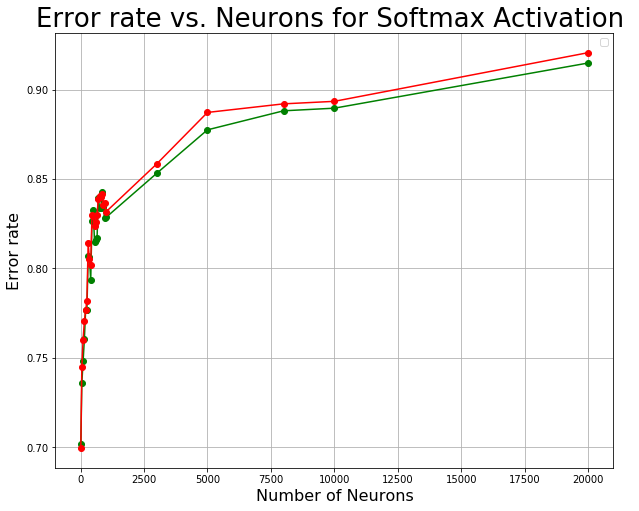

In [0]:
#Drawing error rate vs neurons for softmax
plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_smax, Train_error_list_smax, 'go-')
plt.plot(Nron_size_list_smax, Val_error_list_smax, 'ro-')
plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Error rate vs. Neurons for Softmax Activation ', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./performance_smax.png')


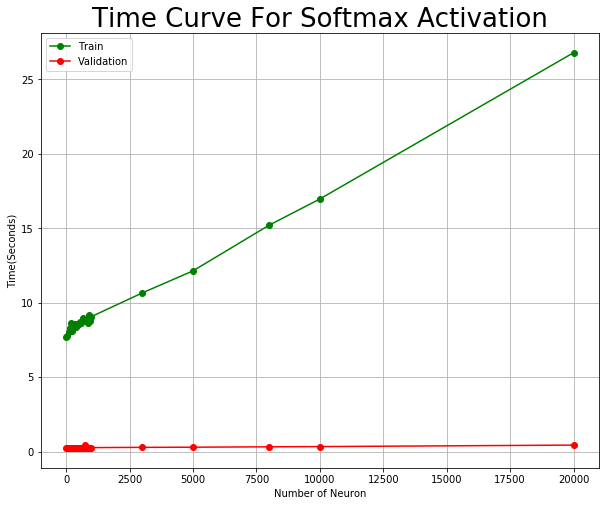

In [0]:
#Drawing train/val time v.s. training set for softmax

plt.figure(figsize = (10,8))
plt.plot(Nron_size_list_smax, Train_time_list_smax, 'go-', label = "Train")
plt.plot(Nron_size_list_smax, Val_time_list_smax, 'ro-', label = "Validation")
plt.xlabel('Number of Neuron')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For Softmax Activation', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_smax.png')

# Performance Comparison of the Activation Functions with Different Number of Neurons

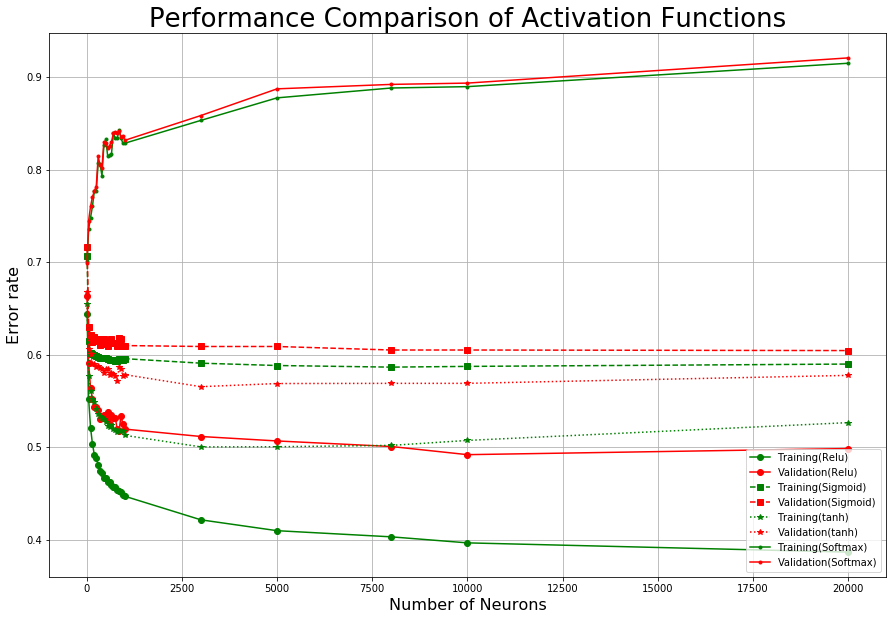

In [0]:
#Drawing performances of different activaion functions
plt.figure(figsize = (15,10))
plt.plot(Nron_size_list_relu, Train_error_list_relu, 'go-', label = "Training(Relu)")
plt.plot(Nron_size_list_relu, Val_error_list_relu, 'ro-', label = "Validation(Relu)")
plt.plot(Nron_size_list_sgmd, Train_error_list_sgmd, 'gs--', label = "Training(Sigmoid)")
plt.plot(Nron_size_list_sgmd, Val_error_list_sgmd, 'rs--', label = "Validation(Sigmoid)") 
plt.plot(Nron_size_list_tanh, Train_error_list_tanh, 'g*:', label = "Training(tanh)")
plt.plot(Nron_size_list_tanh, Val_error_list_tanh, 'r*:', label = "Validation(tanh)")
plt.plot(Nron_size_list_smax, Train_error_list_smax, 'g.-', label = "Training(Softmax)")
plt.plot(Nron_size_list_smax, Val_error_list_smax, 'r.-', label = "Validation(Softmax)")

plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.legend( fontsize=10)
plt.title('Performance Comparison of Activation Functions', fontsize=26)
plt.grid(True)
plt.savefig('./performance_comp_activation.png')

<Figure size 1080x720 with 0 Axes>

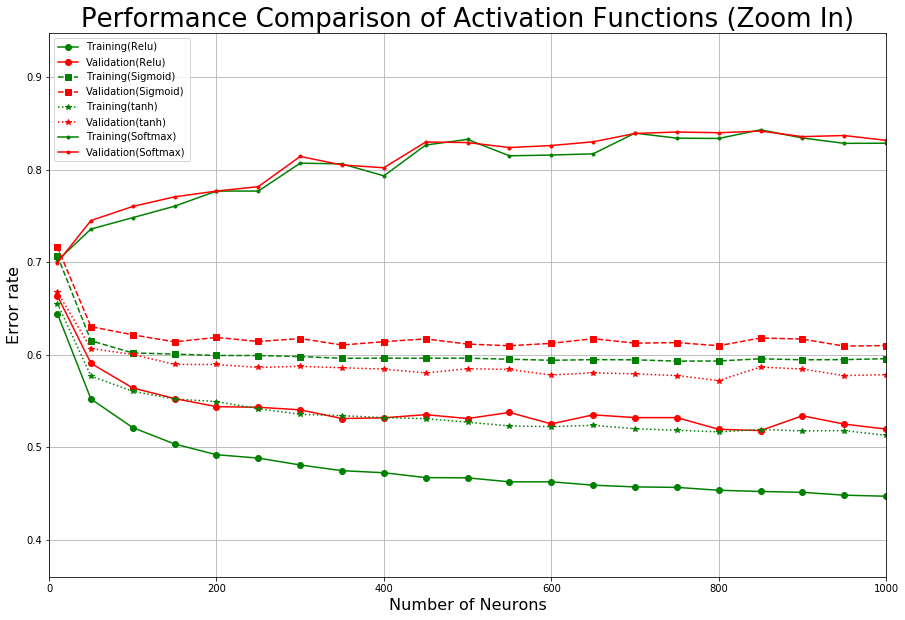

In [0]:
#Drawing performances of different activaion functions (Zoomed Version)
plt.figure(figsize = (15,10))
plt.figure(figsize = (15,10))
plt.plot(Nron_size_list_relu, Train_error_list_relu, 'go-', label = "Training(Relu)")
plt.plot(Nron_size_list_relu, Val_error_list_relu, 'ro-', label = "Validation(Relu)")
plt.plot(Nron_size_list_sgmd, Train_error_list_sgmd, 'gs--', label = "Training(Sigmoid)")
plt.plot(Nron_size_list_sgmd, Val_error_list_sgmd, 'rs--', label = "Validation(Sigmoid)") 
plt.plot(Nron_size_list_tanh, Train_error_list_tanh, 'g*:', label = "Training(tanh)")
plt.plot(Nron_size_list_tanh, Val_error_list_tanh, 'r*:', label = "Validation(tanh)")
plt.plot(Nron_size_list_smax, Train_error_list_smax, 'g.-', label = "Training(Softmax)")
plt.plot(Nron_size_list_smax, Val_error_list_smax, 'r.-', label = "Validation(Softmax)")

plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.legend( fontsize=10)
plt.title('Performance Comparison of Activation Functions (Zoom In)', fontsize=26)
plt.xlim(0, 1000)
plt.grid(True)
plt.savefig('./performance_comp_activation_zoomIn.png')

<Figure size 1080x720 with 0 Axes>

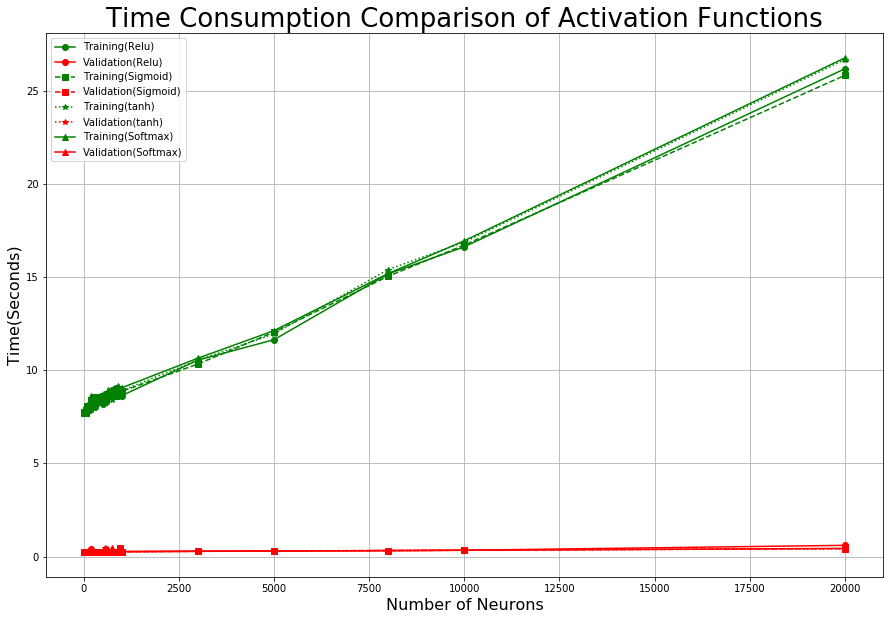

In [0]:
#Drawing time comparison plot for different activation functions
#Drawing train/val time v.s. training set
plt.figure(figsize = (15,10))
plt.figure(figsize = (15,10))
plt.plot(Nron_size_list_relu, Train_time_list_relu, 'go-', label = "Training(Relu)")
plt.plot(Nron_size_list_relu, Val_time_list_relu, 'ro-', label = "Validation(Relu)")
plt.plot(Nron_size_list_sgmd, Train_time_list_sgmd, 'gs--', label = "Training(Sigmoid)")
plt.plot(Nron_size_list_sgmd, Val_time_list_sgmd, 'rs--', label = "Validation(Sigmoid)") 
plt.plot(Nron_size_list_tanh, Train_time_list_tanh, 'g*:', label = "Training(tanh)")
plt.plot(Nron_size_list_tanh, Val_time_list_tanh, 'r*:', label = "Validation(tanh)")
plt.plot(Nron_size_list_smax, Train_time_list_smax, 'g^-', label = "Training(Softmax)")
plt.plot(Nron_size_list_smax, Val_time_list_smax, 'r^-', label = "Validation(Softmax)")


plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Time(Seconds)',fontsize=16)
plt.legend( fontsize=10)
plt.title('Time Consumption Comparison of Activation Functions', fontsize=26)
plt.grid(True)
plt.savefig('./time_comp_activation.png')

In [0]:
# Saving data locally
print( os.getcwd() )
print( os.listdir(os.getcwd()) )
print( os.listdir('models') )

/content
['sample_data', '.config', 'TimeCurve_5ep.png', 'TimeCurve_sgmd.png', 'TimeCurve_1ep.png', 'models', 'performance_relu.png', 'TimeCurve_relu.png', 'performance_sgmd.png', 'time_comp_activation.png', 'performance_comp_1_5_10ep.png', 'accuracy_1ep.png', 'LearningCurve_10ep.png', 'TimeCurve_smax.png', 'TimeCurve_10ep.png', 'accuracy_10ep.png', 'performance_comp_activation_zoomIn.png', 'performance_tanh.png', 'LearningCurve_5ep.png', 'time_comp_1_5_10ep.png', 'performance_smax.png', 'LearningCurve_1ep.png', 'TimeCurve_tanh.png', 'accuracy_5ep.png', 'performance_comp_activation.png']
['dnn_clf_relu', 'dnn_clf_1ep', 'dnn_clf_5ep', 'dnn_clf_10ep']


In [0]:
#downloading relevent files
files.download( "./TimeCurve_sgmd.png" )
files.download( "./performance_sgmd.png" )
files.download( "./performance_relu.png" )
files.download( "./TimeCurve_relu.png" )
files.download( "./TimeCurve_smax.png" )
files.download( "./performance_smax.png" )
files.download( "./performance_tanh.png" )
files.download( "./TimeCurve_tanh.png" )
files.download( "./performance_comp_activation.png" )
files.download( "./performance_comp_activation_zoomIn.png" )
files.download( "./time_comp_activation.png" )

# Changing Learning Rate and Optimizer

## Adagrad Optimizer with Different Learning Rates

In [0]:
lr_size_list_ag = []
Train_error_list_ag = []
Val_error_list_ag = []
Train_time_list_ag = []
Val_time_list_ag = []
batch_size = 50 # fixed batch size
#lr = 0.001 # fixed learning rate
num_epoch = 10 # total number of epoch 
epoch = len(X_train_ft_sc)/batch_size # number of steps in one epoch

for j in [0.10,0.05,0.025,0.020,0.019,0.016,0.013,0.01,0.009,0.005,0.001,0.0001]:

    #### Appending number of learning rate                                                                               
    lr_size_list_ag.append(j)
                                                                                    
    print('LearningRate_set_size:', j)
    
    
    #### Model building
    
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None)
                                  # model_dir="./models/dnn_clf_/ag")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
    
    dnn_clf_ag = tf.contrib.learn.DNNClassifier(hidden_units = [8000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=j),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_ag = tf.contrib.learn.SKCompat(dnn_clf_ag) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_ag.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_ag.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_ag.predict(X_train_ft_sc) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train, y_train_partial_pred['classes'])# training error
    
    Train_error_list_ag.append(Train_error)#append training error
    
    print('dnn_clf_ag training time', Train_elapse) 
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_ag.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_ag.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_ag.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Learning Rate_size_list_Adagrade: ", lr_size_list_ag)
print("Train_error_list_Adagrade: ", Train_error_list_ag)
print("Val_error_list_Adagrade: ", Val_error_list_ag)
print("Train_time_list_Adagrade: ", Train_time_list_ag)
print("Val_time_list_Adagrade: ", Val_time_list_ag)  

('LearningRate_set_size:', 0.1)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe62420d290>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpJ9i21W', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpJ9i21W/model.ckpt.
IN

INFO:tensorflow:global_step/sec: 343.529
INFO:tensorflow:loss = 1.0451818, step = 7300 (0.291 sec)
INFO:tensorflow:global_step/sec: 346.355
INFO:tensorflow:loss = 1.6066929, step = 7400 (0.288 sec)
INFO:tensorflow:global_step/sec: 347.45
INFO:tensorflow:loss = 1.9649063, step = 7500 (0.288 sec)
INFO:tensorflow:global_step/sec: 346.332
INFO:tensorflow:loss = 1.3556305, step = 7600 (0.288 sec)
INFO:tensorflow:global_step/sec: 346.616
INFO:tensorflow:loss = 2.114651, step = 7700 (0.289 sec)
INFO:tensorflow:global_step/sec: 346.018
INFO:tensorflow:loss = 0.9182425, step = 7800 (0.288 sec)
INFO:tensorflow:global_step/sec: 346.649
INFO:tensorflow:loss = 1.0973861, step = 7900 (0.289 sec)
INFO:tensorflow:global_step/sec: 342.245
INFO:tensorflow:loss = 1.1072898, step = 8000 (0.292 sec)
INFO:tensorflow:global_step/sec: 342.485
INFO:tensorflow:loss = 0.98921716, step = 8100 (0.293 sec)
INFO:tensorflow:global_step/sec: 337.546
INFO:tensorflow:loss = 1.3312224, step = 8200 (0.296 sec)
INFO:tensor

INFO:tensorflow:loss = 1.1213716, step = 4900 (0.302 sec)
INFO:tensorflow:global_step/sec: 330.721
INFO:tensorflow:loss = 1.4248109, step = 5000 (0.303 sec)
INFO:tensorflow:global_step/sec: 332.234
INFO:tensorflow:loss = 1.5732183, step = 5100 (0.301 sec)
INFO:tensorflow:global_step/sec: 331.107
INFO:tensorflow:loss = 1.0413254, step = 5200 (0.302 sec)
INFO:tensorflow:global_step/sec: 334.575
INFO:tensorflow:loss = 1.2439848, step = 5300 (0.299 sec)
INFO:tensorflow:global_step/sec: 332.703
INFO:tensorflow:loss = 1.1832936, step = 5400 (0.301 sec)
INFO:tensorflow:global_step/sec: 333.4
INFO:tensorflow:loss = 0.97331995, step = 5500 (0.300 sec)
INFO:tensorflow:global_step/sec: 333.913
INFO:tensorflow:loss = 1.379417, step = 5600 (0.300 sec)
INFO:tensorflow:global_step/sec: 333.79
INFO:tensorflow:loss = 1.473597, step = 5700 (0.300 sec)
INFO:tensorflow:global_step/sec: 333.235
INFO:tensorflow:loss = 1.33155, step = 5800 (0.300 sec)
INFO:tensorflow:global_step/sec: 337.268
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 340.623
INFO:tensorflow:loss = 1.4650098, step = 2600 (0.293 sec)
INFO:tensorflow:global_step/sec: 339.397
INFO:tensorflow:loss = 1.115673, step = 2700 (0.294 sec)
INFO:tensorflow:global_step/sec: 336.885
INFO:tensorflow:loss = 1.2510061, step = 2800 (0.297 sec)
INFO:tensorflow:global_step/sec: 342.699
INFO:tensorflow:loss = 1.1794206, step = 2900 (0.292 sec)
INFO:tensorflow:global_step/sec: 339.097
INFO:tensorflow:loss = 1.1540959, step = 3000 (0.295 sec)
INFO:tensorflow:global_step/sec: 340.467
INFO:tensorflow:loss = 1.1691927, step = 3100 (0.294 sec)
INFO:tensorflow:global_step/sec: 341.008
INFO:tensorflow:loss = 1.4446127, step = 3200 (0.293 sec)
INFO:tensorflow:global_step/sec: 339.867
INFO:tensorflow:loss = 1.1119819, step = 3300 (0.294 sec)
INFO:tensorflow:global_step/sec: 340.019
INFO:tensorflow:loss = 1.1647855, step = 3400 (0.294 sec)
INFO:tensorflow:global_step/sec: 339.604
INFO:tensorflow:loss = 1.587818, step = 3500 (0.295 sec)
INFO:tensorf

INFO:tensorflow:loss = 1.8822255, step = 200 (0.297 sec)
INFO:tensorflow:global_step/sec: 335.977
INFO:tensorflow:loss = 1.6361995, step = 300 (0.297 sec)
INFO:tensorflow:global_step/sec: 333.475
INFO:tensorflow:loss = 1.8166107, step = 400 (0.300 sec)
INFO:tensorflow:global_step/sec: 334.961
INFO:tensorflow:loss = 1.7295685, step = 500 (0.298 sec)
INFO:tensorflow:global_step/sec: 337.997
INFO:tensorflow:loss = 1.5242472, step = 600 (0.296 sec)
INFO:tensorflow:global_step/sec: 337.355
INFO:tensorflow:loss = 1.7533346, step = 700 (0.297 sec)
INFO:tensorflow:global_step/sec: 341.715
INFO:tensorflow:loss = 1.5392078, step = 800 (0.292 sec)
INFO:tensorflow:global_step/sec: 341.192
INFO:tensorflow:loss = 1.544486, step = 900 (0.294 sec)
INFO:tensorflow:global_step/sec: 341.068
INFO:tensorflow:loss = 1.6428205, step = 1000 (0.293 sec)
INFO:tensorflow:global_step/sec: 341.226
INFO:tensorflow:loss = 1.2761493, step = 1100 (0.293 sec)
INFO:tensorflow:global_step/sec: 340.35
INFO:tensorflow:loss

INFO:tensorflow:loss = 0.48273265, step = 8500 (0.294 sec)
INFO:tensorflow:global_step/sec: 339.524
INFO:tensorflow:loss = 0.8268128, step = 8600 (0.294 sec)
INFO:tensorflow:global_step/sec: 336.696
INFO:tensorflow:loss = 0.55119646, step = 8700 (0.296 sec)
INFO:tensorflow:global_step/sec: 342.414
INFO:tensorflow:loss = 1.1409237, step = 8800 (0.293 sec)
INFO:tensorflow:global_step/sec: 342.265
INFO:tensorflow:loss = 1.0104173, step = 8900 (0.292 sec)
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmp4fBoYJ/model.ckpt.
INFO:tensorflow:Loss for final step: 0.8425873.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4fBoYJ/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_ag training time', 27.967393)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4fBoYJ/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_ini

INFO:tensorflow:global_step/sec: 342.419
INFO:tensorflow:loss = 0.86086345, step = 6200 (0.292 sec)
INFO:tensorflow:global_step/sec: 337.77
INFO:tensorflow:loss = 0.85982424, step = 6300 (0.296 sec)
INFO:tensorflow:global_step/sec: 341.807
INFO:tensorflow:loss = 0.9155319, step = 6400 (0.293 sec)
INFO:tensorflow:global_step/sec: 342.472
INFO:tensorflow:loss = 1.0721332, step = 6500 (0.292 sec)
INFO:tensorflow:global_step/sec: 338.058
INFO:tensorflow:loss = 1.2120743, step = 6600 (0.295 sec)
INFO:tensorflow:global_step/sec: 341.62
INFO:tensorflow:loss = 0.87636846, step = 6700 (0.293 sec)
INFO:tensorflow:global_step/sec: 340.263
INFO:tensorflow:loss = 1.0412036, step = 6800 (0.294 sec)
INFO:tensorflow:global_step/sec: 340.726
INFO:tensorflow:loss = 0.60515076, step = 6900 (0.293 sec)
INFO:tensorflow:global_step/sec: 337.998
INFO:tensorflow:loss = 0.9101268, step = 7000 (0.296 sec)
INFO:tensorflow:global_step/sec: 334.843
INFO:tensorflow:loss = 0.95784193, step = 7100 (0.299 sec)
INFO:te

INFO:tensorflow:loss = 1.234709, step = 3800 (0.300 sec)
INFO:tensorflow:global_step/sec: 330.433
INFO:tensorflow:loss = 0.959334, step = 3900 (0.303 sec)
INFO:tensorflow:global_step/sec: 334.898
INFO:tensorflow:loss = 1.0143188, step = 4000 (0.299 sec)
INFO:tensorflow:global_step/sec: 337.296
INFO:tensorflow:loss = 1.0207788, step = 4100 (0.296 sec)
INFO:tensorflow:global_step/sec: 335.181
INFO:tensorflow:loss = 1.1140907, step = 4200 (0.299 sec)
INFO:tensorflow:global_step/sec: 331.958
INFO:tensorflow:loss = 0.8653987, step = 4300 (0.301 sec)
INFO:tensorflow:global_step/sec: 333.244
INFO:tensorflow:loss = 1.2535644, step = 4400 (0.300 sec)
INFO:tensorflow:global_step/sec: 336.865
INFO:tensorflow:loss = 0.92382073, step = 4500 (0.297 sec)
INFO:tensorflow:global_step/sec: 337.636
INFO:tensorflow:loss = 0.9113311, step = 4600 (0.296 sec)
INFO:tensorflow:global_step/sec: 336.819
INFO:tensorflow:loss = 0.85039747, step = 4700 (0.297 sec)
INFO:tensorflow:global_step/sec: 336.511
INFO:tenso

INFO:tensorflow:global_step/sec: 338.85
INFO:tensorflow:loss = 1.2481068, step = 1500 (0.296 sec)
INFO:tensorflow:global_step/sec: 336.89
INFO:tensorflow:loss = 1.2832572, step = 1600 (0.297 sec)
INFO:tensorflow:global_step/sec: 336.82
INFO:tensorflow:loss = 1.2949634, step = 1700 (0.296 sec)
INFO:tensorflow:global_step/sec: 334.99
INFO:tensorflow:loss = 1.3553995, step = 1800 (0.299 sec)
INFO:tensorflow:global_step/sec: 337.318
INFO:tensorflow:loss = 1.3480333, step = 1900 (0.297 sec)
INFO:tensorflow:global_step/sec: 335.097
INFO:tensorflow:loss = 1.221788, step = 2000 (0.298 sec)
INFO:tensorflow:global_step/sec: 338.15
INFO:tensorflow:loss = 1.1023062, step = 2100 (0.295 sec)
INFO:tensorflow:global_step/sec: 337.942
INFO:tensorflow:loss = 1.2500861, step = 2200 (0.296 sec)
INFO:tensorflow:global_step/sec: 331.454
INFO:tensorflow:loss = 1.4233468, step = 2300 (0.301 sec)
INFO:tensorflow:global_step/sec: 342.618
INFO:tensorflow:loss = 1.6237832, step = 2400 (0.293 sec)
INFO:tensorflow:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpIFcg6n/model.ckpt.
INFO:tensorflow:loss = 2.5952237, step = 0
INFO:tensorflow:global_step/sec: 309.285
INFO:tensorflow:loss = 1.9439954, step = 100 (0.325 sec)
INFO:tensorflow:global_step/sec: 341.837
INFO:tensorflow:loss = 1.7922229, step = 200 (0.293 sec)
INFO:tensorflow:global_step/sec: 341.434
INFO:tensorflow:loss = 1.6540521, step = 300 (0.292 sec)
INFO:tensorflow:global_step/sec: 340.946
INFO:tensorflow:loss = 1.7414383, step = 400 (0.294 sec)
INFO:tensorflow:global_step/sec: 334.561
INFO:tensorflow:loss = 1.5091089, step = 500 (0.299 sec)
INFO:tensorflow:global_step/sec: 340.114
INFO:tensorflow:loss = 1.4183828, step = 600 (0.294 sec)
INFO:tensorflow:global_step/sec: 340.739
INFO:tensorflow:loss = 1.7428888, step = 700 (0.294 sec)
INFO:tensorflow:global_step/sec: 3

INFO:tensorflow:global_step/sec: 340.519
INFO:tensorflow:loss = 0.59827584, step = 8100 (0.294 sec)
INFO:tensorflow:global_step/sec: 337.934
INFO:tensorflow:loss = 0.5916956, step = 8200 (0.295 sec)
INFO:tensorflow:global_step/sec: 339.998
INFO:tensorflow:loss = 0.7143499, step = 8300 (0.294 sec)
INFO:tensorflow:global_step/sec: 343.726
INFO:tensorflow:loss = 0.61904186, step = 8400 (0.291 sec)
INFO:tensorflow:global_step/sec: 338.892
INFO:tensorflow:loss = 0.40939674, step = 8500 (0.295 sec)
INFO:tensorflow:global_step/sec: 340.176
INFO:tensorflow:loss = 0.6926242, step = 8600 (0.293 sec)
INFO:tensorflow:global_step/sec: 343.254
INFO:tensorflow:loss = 0.40566447, step = 8700 (0.292 sec)
INFO:tensorflow:global_step/sec: 341.739
INFO:tensorflow:loss = 0.88027245, step = 8800 (0.293 sec)
INFO:tensorflow:global_step/sec: 335.981
INFO:tensorflow:loss = 0.70967233, step = 8900 (0.297 sec)
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmpIFcg6n/model.ckpt.
INFO:tensorflow:Loss for fi

INFO:tensorflow:loss = 1.0152713, step = 5700 (0.296 sec)
INFO:tensorflow:global_step/sec: 343.769
INFO:tensorflow:loss = 0.7069342, step = 5800 (0.291 sec)
INFO:tensorflow:global_step/sec: 343.724
INFO:tensorflow:loss = 0.6940673, step = 5900 (0.291 sec)
INFO:tensorflow:global_step/sec: 342.865
INFO:tensorflow:loss = 1.0744908, step = 6000 (0.292 sec)
INFO:tensorflow:global_step/sec: 338.872
INFO:tensorflow:loss = 0.8032242, step = 6100 (0.295 sec)
INFO:tensorflow:global_step/sec: 339.971
INFO:tensorflow:loss = 0.7491358, step = 6200 (0.295 sec)
INFO:tensorflow:global_step/sec: 336.742
INFO:tensorflow:loss = 0.71044725, step = 6300 (0.297 sec)
INFO:tensorflow:global_step/sec: 337.681
INFO:tensorflow:loss = 0.77312243, step = 6400 (0.296 sec)
INFO:tensorflow:global_step/sec: 338.904
INFO:tensorflow:loss = 0.9091333, step = 6500 (0.296 sec)
INFO:tensorflow:global_step/sec: 339.008
INFO:tensorflow:loss = 0.86198485, step = 6600 (0.295 sec)
INFO:tensorflow:global_step/sec: 340.919
INFO:te

INFO:tensorflow:global_step/sec: 335.111
INFO:tensorflow:loss = 1.1016095, step = 3400 (0.298 sec)
INFO:tensorflow:global_step/sec: 335.633
INFO:tensorflow:loss = 1.237685, step = 3500 (0.298 sec)
INFO:tensorflow:global_step/sec: 334.242
INFO:tensorflow:loss = 0.8696234, step = 3600 (0.299 sec)
INFO:tensorflow:global_step/sec: 335.603
INFO:tensorflow:loss = 0.894151, step = 3700 (0.298 sec)
INFO:tensorflow:global_step/sec: 336.38
INFO:tensorflow:loss = 1.2581848, step = 3800 (0.298 sec)
INFO:tensorflow:global_step/sec: 333.198
INFO:tensorflow:loss = 0.94469786, step = 3900 (0.300 sec)
INFO:tensorflow:global_step/sec: 335.116
INFO:tensorflow:loss = 1.0043535, step = 4000 (0.299 sec)
INFO:tensorflow:global_step/sec: 335.285
INFO:tensorflow:loss = 0.8947572, step = 4100 (0.298 sec)
INFO:tensorflow:global_step/sec: 331.346
INFO:tensorflow:loss = 1.0177056, step = 4200 (0.302 sec)
INFO:tensorflow:global_step/sec: 327.773
INFO:tensorflow:loss = 0.8038141, step = 4300 (0.305 sec)
INFO:tensorf

INFO:tensorflow:loss = 1.6975245, step = 1000 (0.296 sec)
INFO:tensorflow:global_step/sec: 338.122
INFO:tensorflow:loss = 1.3063121, step = 1100 (0.295 sec)
INFO:tensorflow:global_step/sec: 340.56
INFO:tensorflow:loss = 1.435137, step = 1200 (0.293 sec)
INFO:tensorflow:global_step/sec: 340.998
INFO:tensorflow:loss = 1.7600915, step = 1300 (0.293 sec)
INFO:tensorflow:global_step/sec: 341.101
INFO:tensorflow:loss = 1.5381415, step = 1400 (0.293 sec)
INFO:tensorflow:global_step/sec: 343.376
INFO:tensorflow:loss = 1.3661212, step = 1500 (0.291 sec)
INFO:tensorflow:global_step/sec: 341.597
INFO:tensorflow:loss = 1.5072796, step = 1600 (0.294 sec)
INFO:tensorflow:global_step/sec: 338.577
INFO:tensorflow:loss = 1.3673416, step = 1700 (0.295 sec)
INFO:tensorflow:global_step/sec: 340.041
INFO:tensorflow:loss = 1.5525277, step = 1800 (0.294 sec)
INFO:tensorflow:global_step/sec: 340.928
INFO:tensorflow:loss = 1.287919, step = 1900 (0.293 sec)
INFO:tensorflow:global_step/sec: 338.889
INFO:tensorfl

INFO:tensorflow:Restoring parameters from /tmp/tmpapt0zK/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.3375111111111111, '/', 0.482)
('LearningRate_set_size:', 0.0001)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6b4713f10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpMTRAH7', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Creat

INFO:tensorflow:global_step/sec: 334.094
INFO:tensorflow:loss = 1.5974661, step = 7100 (0.299 sec)
INFO:tensorflow:global_step/sec: 331.89
INFO:tensorflow:loss = 1.4866296, step = 7200 (0.301 sec)
INFO:tensorflow:global_step/sec: 334.596
INFO:tensorflow:loss = 1.5209634, step = 7300 (0.299 sec)
INFO:tensorflow:global_step/sec: 330.406
INFO:tensorflow:loss = 1.3278427, step = 7400 (0.303 sec)
INFO:tensorflow:global_step/sec: 331.173
INFO:tensorflow:loss = 1.5889953, step = 7500 (0.302 sec)
INFO:tensorflow:global_step/sec: 334.469
INFO:tensorflow:loss = 1.6054242, step = 7600 (0.299 sec)
INFO:tensorflow:global_step/sec: 332.562
INFO:tensorflow:loss = 1.5549127, step = 7700 (0.300 sec)
INFO:tensorflow:global_step/sec: 335.51
INFO:tensorflow:loss = 1.3769944, step = 7800 (0.298 sec)
INFO:tensorflow:global_step/sec: 332.779
INFO:tensorflow:loss = 1.5179305, step = 7900 (0.301 sec)
INFO:tensorflow:global_step/sec: 332.152
INFO:tensorflow:loss = 1.6200843, step = 8000 (0.301 sec)
INFO:tensorf

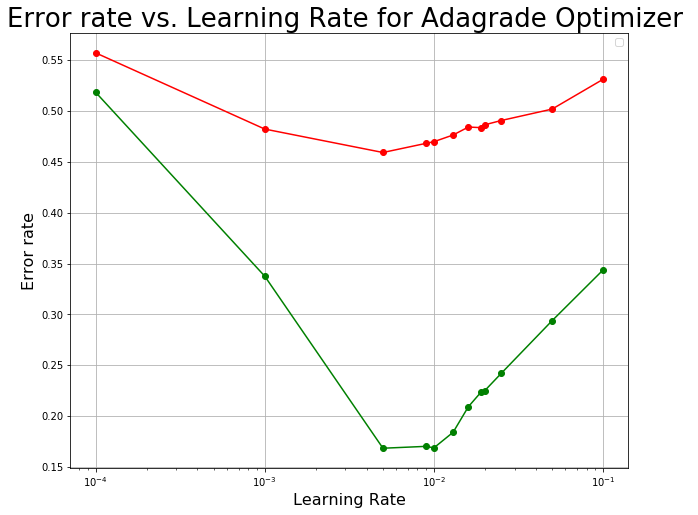

In [0]:
#Drawing error rate vs learning rate for adagrade optimizer
plt.figure(figsize = (10,8))
plt.semilogx(lr_size_list_ag, Train_error_list_ag, 'go-')
plt.semilogx(lr_size_list_ag, Val_error_list_ag, 'ro-')
plt.xlabel('Learning Rate',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Error rate vs. Learning Rate for Adagrade Optimizer ', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./performance_ag.png')

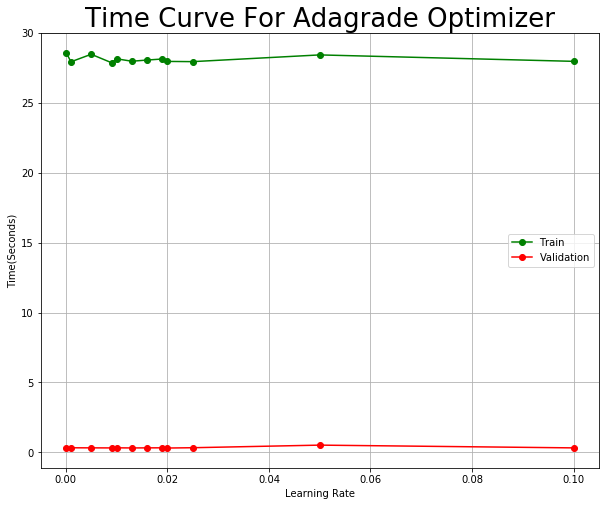

In [0]:
#Drawing train/val time v.s. training set for adagrade optimizer for different learning rate

plt.figure(figsize = (10,8))
plt.plot(lr_size_list_ag, Train_time_list_ag, 'go-', label = "Train")
plt.plot(lr_size_list_ag, Val_time_list_ag, 'ro-', label = "Validation")
plt.xlabel('Learning Rate')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For Adagrade Optimizer', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_ag.png')

## Gradient Descent Optimizer with Different Learning Rates

In [0]:
lr_size_list_gd = []
Train_error_list_gd = []
Val_error_list_gd = []
Train_time_list_gd = []
Val_time_list_gd = []
batch_size = 50 # fixed batch size
#lr = 0.001 # fixed learning rate
num_epoch = 10 # total number of epoch 
epoch = len(X_train_ft_sc)/batch_size # number of steps in one epoch

for j in [0.10,0.05,0.025,0.020,0.019,0.016,0.013,0.01,0.009,0.005,0.001,0.0001]:

    #### Appending number of learning rate                                                                               
    lr_size_list_gd.append(j)
                                                                                    
    print('LearningRate_set_size:', j)
    
    
    #### Model building
    
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None)
                                  # model_dir="./models/dnn_clf_/gd")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
    
    dnn_clf_gd = tf.contrib.learn.DNNClassifier(hidden_units = [8000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.GradientDescentOptimizer(learning_rate=j),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_gd = tf.contrib.learn.SKCompat(dnn_clf_gd) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_gd.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_gd.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_gd.predict(X_train_ft_sc) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train, y_train_partial_pred['classes'])# training error
    
    Train_error_list_gd.append(Train_error)#append training error
    
    print('dnn_clf_gd training time', Train_elapse) 
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_gd.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_gd.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_gd.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                       
    
print("Learning Rate_size_list_GradientDescent: ", lr_size_list_gd)
print("Train_error_list_GradientDescent: ", Train_error_list_gd)
print("Val_error_list_GradientDescent: ", Val_error_list_gd)
print("Train_time_list_GradientDescent: ", Train_time_list_gd)
print("Val_time_list_GradientDescent: ", Val_time_list_gd)  

('LearningRate_set_size:', 0.1)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe61c1a5550>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpmG4QAq', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpmG4QAq/model.ckpt.
IN

INFO:tensorflow:global_step/sec: 405.214
INFO:tensorflow:loss = 1.5588315, step = 7300 (0.247 sec)
INFO:tensorflow:global_step/sec: 402.969
INFO:tensorflow:loss = 2.286024, step = 7400 (0.249 sec)
INFO:tensorflow:global_step/sec: 403.89
INFO:tensorflow:loss = 2.0677316, step = 7500 (0.247 sec)
INFO:tensorflow:global_step/sec: 404.39
INFO:tensorflow:loss = 1.6758286, step = 7600 (0.247 sec)
INFO:tensorflow:global_step/sec: 403.425
INFO:tensorflow:loss = 2.159859, step = 7700 (0.249 sec)
INFO:tensorflow:global_step/sec: 400.704
INFO:tensorflow:loss = 1.4824082, step = 7800 (0.249 sec)
INFO:tensorflow:global_step/sec: 402.431
INFO:tensorflow:loss = 1.549202, step = 7900 (0.249 sec)
INFO:tensorflow:global_step/sec: 400.26
INFO:tensorflow:loss = 1.5029187, step = 8000 (0.250 sec)
INFO:tensorflow:global_step/sec: 392.479
INFO:tensorflow:loss = 1.2805289, step = 8100 (0.255 sec)
INFO:tensorflow:global_step/sec: 403.98
INFO:tensorflow:loss = 1.7046322, step = 8200 (0.247 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 396.044
INFO:tensorflow:loss = 1.4050444, step = 5000 (0.253 sec)
INFO:tensorflow:global_step/sec: 392.117
INFO:tensorflow:loss = 1.6931586, step = 5100 (0.255 sec)
INFO:tensorflow:global_step/sec: 393.605
INFO:tensorflow:loss = 1.1908271, step = 5200 (0.254 sec)
INFO:tensorflow:global_step/sec: 392.966
INFO:tensorflow:loss = 1.2097164, step = 5300 (0.254 sec)
INFO:tensorflow:global_step/sec: 387.836
INFO:tensorflow:loss = 1.3824276, step = 5400 (0.258 sec)
INFO:tensorflow:global_step/sec: 391.512
INFO:tensorflow:loss = 0.92215186, step = 5500 (0.255 sec)
INFO:tensorflow:global_step/sec: 386.685
INFO:tensorflow:loss = 1.3745483, step = 5600 (0.259 sec)
INFO:tensorflow:global_step/sec: 389.426
INFO:tensorflow:loss = 1.462667, step = 5700 (0.257 sec)
INFO:tensorflow:global_step/sec: 389.996
INFO:tensorflow:loss = 1.426464, step = 5800 (0.256 sec)
INFO:tensorflow:global_step/sec: 392.058
INFO:tensorflow:loss = 1.2501932, step = 5900 (0.256 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 392.773
INFO:tensorflow:loss = 1.0065464, step = 2700 (0.255 sec)
INFO:tensorflow:global_step/sec: 397.994
INFO:tensorflow:loss = 1.134302, step = 2800 (0.251 sec)
INFO:tensorflow:global_step/sec: 395.143
INFO:tensorflow:loss = 1.0673006, step = 2900 (0.252 sec)
INFO:tensorflow:global_step/sec: 400.218
INFO:tensorflow:loss = 1.0730914, step = 3000 (0.250 sec)
INFO:tensorflow:global_step/sec: 398.473
INFO:tensorflow:loss = 1.0813849, step = 3100 (0.251 sec)
INFO:tensorflow:global_step/sec: 396.449
INFO:tensorflow:loss = 1.3102993, step = 3200 (0.252 sec)
INFO:tensorflow:global_step/sec: 402.33
INFO:tensorflow:loss = 1.0595233, step = 3300 (0.250 sec)
INFO:tensorflow:global_step/sec: 399.208
INFO:tensorflow:loss = 1.1044416, step = 3400 (0.250 sec)
INFO:tensorflow:global_step/sec: 399.538
INFO:tensorflow:loss = 1.6073264, step = 3500 (0.250 sec)
INFO:tensorflow:global_step/sec: 398.224
INFO:tensorflow:loss = 0.8733671, step = 3600 (0.252 sec)
INFO:tensorf

INFO:tensorflow:loss = 1.691597, step = 300 (0.251 sec)
INFO:tensorflow:global_step/sec: 393.003
INFO:tensorflow:loss = 1.7844424, step = 400 (0.254 sec)
INFO:tensorflow:global_step/sec: 396.986
INFO:tensorflow:loss = 1.6000772, step = 500 (0.252 sec)
INFO:tensorflow:global_step/sec: 397.216
INFO:tensorflow:loss = 1.4186114, step = 600 (0.252 sec)
INFO:tensorflow:global_step/sec: 398.824
INFO:tensorflow:loss = 1.7365329, step = 700 (0.251 sec)
INFO:tensorflow:global_step/sec: 394.903
INFO:tensorflow:loss = 1.4630771, step = 800 (0.254 sec)
INFO:tensorflow:global_step/sec: 392.719
INFO:tensorflow:loss = 1.4473429, step = 900 (0.254 sec)
INFO:tensorflow:global_step/sec: 393.18
INFO:tensorflow:loss = 1.5794253, step = 1000 (0.254 sec)
INFO:tensorflow:global_step/sec: 398.605
INFO:tensorflow:loss = 1.2095823, step = 1100 (0.251 sec)
INFO:tensorflow:global_step/sec: 393.199
INFO:tensorflow:loss = 1.2219596, step = 1200 (0.254 sec)
INFO:tensorflow:global_step/sec: 393.837
INFO:tensorflow:los

INFO:tensorflow:loss = 0.7613569, step = 8600 (0.256 sec)
INFO:tensorflow:global_step/sec: 393.388
INFO:tensorflow:loss = 0.49765, step = 8700 (0.255 sec)
INFO:tensorflow:global_step/sec: 390.884
INFO:tensorflow:loss = 1.0416628, step = 8800 (0.255 sec)
INFO:tensorflow:global_step/sec: 388.514
INFO:tensorflow:loss = 0.846572, step = 8900 (0.258 sec)
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmp7SL7wt/model.ckpt.
INFO:tensorflow:Loss for final step: 0.679778.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7SL7wt/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_gd training time', 23.549734)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7SL7wt/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.20062222222222226, '/', 0.483)
('LearningRate_set_size:', 0.019)
INFO:

INFO:tensorflow:global_step/sec: 395.037
INFO:tensorflow:loss = 0.75936246, step = 6300 (0.253 sec)
INFO:tensorflow:global_step/sec: 396.934
INFO:tensorflow:loss = 0.9088099, step = 6400 (0.252 sec)
INFO:tensorflow:global_step/sec: 399.781
INFO:tensorflow:loss = 1.0042558, step = 6500 (0.250 sec)
INFO:tensorflow:global_step/sec: 397.986
INFO:tensorflow:loss = 1.124696, step = 6600 (0.251 sec)
INFO:tensorflow:global_step/sec: 394.772
INFO:tensorflow:loss = 0.84347606, step = 6700 (0.254 sec)
INFO:tensorflow:global_step/sec: 392.635
INFO:tensorflow:loss = 0.8792206, step = 6800 (0.254 sec)
INFO:tensorflow:global_step/sec: 396.041
INFO:tensorflow:loss = 0.6409463, step = 6900 (0.253 sec)
INFO:tensorflow:global_step/sec: 400.707
INFO:tensorflow:loss = 0.8785262, step = 7000 (0.250 sec)
INFO:tensorflow:global_step/sec: 397.635
INFO:tensorflow:loss = 0.8743422, step = 7100 (0.251 sec)
INFO:tensorflow:global_step/sec: 400.488
INFO:tensorflow:loss = 0.61706686, step = 7200 (0.250 sec)
INFO:ten

INFO:tensorflow:loss = 0.9602471, step = 3900 (0.250 sec)
INFO:tensorflow:global_step/sec: 400.024
INFO:tensorflow:loss = 1.015015, step = 4000 (0.250 sec)
INFO:tensorflow:global_step/sec: 395.233
INFO:tensorflow:loss = 0.9919915, step = 4100 (0.253 sec)
INFO:tensorflow:global_step/sec: 392.799
INFO:tensorflow:loss = 1.0599619, step = 4200 (0.254 sec)
INFO:tensorflow:global_step/sec: 399.278
INFO:tensorflow:loss = 0.8090175, step = 4300 (0.250 sec)
INFO:tensorflow:global_step/sec: 395.412
INFO:tensorflow:loss = 1.1666589, step = 4400 (0.253 sec)
INFO:tensorflow:global_step/sec: 389.63
INFO:tensorflow:loss = 0.9269629, step = 4500 (0.257 sec)
INFO:tensorflow:global_step/sec: 393.709
INFO:tensorflow:loss = 0.8860521, step = 4600 (0.254 sec)
INFO:tensorflow:global_step/sec: 400.282
INFO:tensorflow:loss = 0.83903104, step = 4700 (0.250 sec)
INFO:tensorflow:global_step/sec: 397.633
INFO:tensorflow:loss = 0.86521757, step = 4800 (0.252 sec)
INFO:tensorflow:global_step/sec: 395.341
INFO:tenso

INFO:tensorflow:global_step/sec: 398.527
INFO:tensorflow:loss = 1.2981105, step = 1600 (0.251 sec)
INFO:tensorflow:global_step/sec: 398.116
INFO:tensorflow:loss = 1.2859104, step = 1700 (0.252 sec)
INFO:tensorflow:global_step/sec: 394.688
INFO:tensorflow:loss = 1.3521112, step = 1800 (0.253 sec)
INFO:tensorflow:global_step/sec: 394.941
INFO:tensorflow:loss = 1.3316215, step = 1900 (0.253 sec)
INFO:tensorflow:global_step/sec: 398.028
INFO:tensorflow:loss = 1.2110678, step = 2000 (0.251 sec)
INFO:tensorflow:global_step/sec: 394.705
INFO:tensorflow:loss = 1.1203169, step = 2100 (0.253 sec)
INFO:tensorflow:global_step/sec: 398.153
INFO:tensorflow:loss = 1.2482044, step = 2200 (0.252 sec)
INFO:tensorflow:global_step/sec: 398.17
INFO:tensorflow:loss = 1.3796325, step = 2300 (0.251 sec)
INFO:tensorflow:global_step/sec: 398.457
INFO:tensorflow:loss = 1.660099, step = 2400 (0.251 sec)
INFO:tensorflow:global_step/sec: 396.373
INFO:tensorflow:loss = 1.4465224, step = 2500 (0.252 sec)
INFO:tensorf

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxTEKmj/model.ckpt.
INFO:tensorflow:loss = 2.5952237, step = 0
INFO:tensorflow:global_step/sec: 360.237
INFO:tensorflow:loss = 1.6942865, step = 100 (0.280 sec)
INFO:tensorflow:global_step/sec: 395.704
INFO:tensorflow:loss = 1.6543366, step = 200 (0.252 sec)
INFO:tensorflow:global_step/sec: 396.573
INFO:tensorflow:loss = 1.6442313, step = 300 (0.253 sec)
INFO:tensorflow:global_step/sec: 395.662
INFO:tensorflow:loss = 1.6415557, step = 400 (0.252 sec)
INFO:tensorflow:global_step/sec: 396.476
INFO:tensorflow:loss = 1.4848343, step = 500 (0.253 sec)
INFO:tensorflow:global_step/sec: 395.077
INFO:tensorflow:loss = 1.344816, step = 600 (0.253 sec)
INFO:tensorflow:global_step/sec: 395.144
INFO:tensorflow:loss = 1.6135098, step = 700 (0.254 sec)
INFO:tensorflow:global_step/sec: 39

INFO:tensorflow:global_step/sec: 400.617
INFO:tensorflow:loss = 0.67017084, step = 8100 (0.250 sec)
INFO:tensorflow:global_step/sec: 399.977
INFO:tensorflow:loss = 0.6638237, step = 8200 (0.250 sec)
INFO:tensorflow:global_step/sec: 394.156
INFO:tensorflow:loss = 0.79038435, step = 8300 (0.254 sec)
INFO:tensorflow:global_step/sec: 387.057
INFO:tensorflow:loss = 0.6919214, step = 8400 (0.258 sec)
INFO:tensorflow:global_step/sec: 391.282
INFO:tensorflow:loss = 0.45948783, step = 8500 (0.255 sec)
INFO:tensorflow:global_step/sec: 387.114
INFO:tensorflow:loss = 0.7402234, step = 8600 (0.258 sec)
INFO:tensorflow:global_step/sec: 386.595
INFO:tensorflow:loss = 0.5151628, step = 8700 (0.259 sec)
INFO:tensorflow:global_step/sec: 387.111
INFO:tensorflow:loss = 0.9021948, step = 8800 (0.259 sec)
INFO:tensorflow:global_step/sec: 385.964
INFO:tensorflow:loss = 0.73302424, step = 8900 (0.259 sec)
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmpxTEKmj/model.ckpt.
INFO:tensorflow:Loss for fina

INFO:tensorflow:loss = 1.0774993, step = 5700 (0.250 sec)
INFO:tensorflow:global_step/sec: 399.556
INFO:tensorflow:loss = 0.79766345, step = 5800 (0.251 sec)
INFO:tensorflow:global_step/sec: 398.943
INFO:tensorflow:loss = 0.74639845, step = 5900 (0.250 sec)
INFO:tensorflow:global_step/sec: 401.681
INFO:tensorflow:loss = 1.1405609, step = 6000 (0.249 sec)
INFO:tensorflow:global_step/sec: 398.195
INFO:tensorflow:loss = 0.8254988, step = 6100 (0.251 sec)
INFO:tensorflow:global_step/sec: 397.158
INFO:tensorflow:loss = 0.8329407, step = 6200 (0.252 sec)
INFO:tensorflow:global_step/sec: 399.73
INFO:tensorflow:loss = 0.80627275, step = 6300 (0.250 sec)
INFO:tensorflow:global_step/sec: 398.422
INFO:tensorflow:loss = 0.91268706, step = 6400 (0.251 sec)
INFO:tensorflow:global_step/sec: 402.062
INFO:tensorflow:loss = 0.9920874, step = 6500 (0.249 sec)
INFO:tensorflow:global_step/sec: 399.477
INFO:tensorflow:loss = 0.85984784, step = 6600 (0.250 sec)
INFO:tensorflow:global_step/sec: 401.35
INFO:te

INFO:tensorflow:global_step/sec: 406.59
INFO:tensorflow:loss = 1.2222922, step = 3400 (0.246 sec)
INFO:tensorflow:global_step/sec: 405.624
INFO:tensorflow:loss = 1.2898735, step = 3500 (0.247 sec)
INFO:tensorflow:global_step/sec: 402.904
INFO:tensorflow:loss = 1.0225624, step = 3600 (0.249 sec)
INFO:tensorflow:global_step/sec: 404.491
INFO:tensorflow:loss = 1.1371466, step = 3700 (0.247 sec)
INFO:tensorflow:global_step/sec: 410.931
INFO:tensorflow:loss = 1.4817761, step = 3800 (0.244 sec)
INFO:tensorflow:global_step/sec: 408.003
INFO:tensorflow:loss = 1.1033244, step = 3900 (0.245 sec)
INFO:tensorflow:global_step/sec: 400.644
INFO:tensorflow:loss = 1.1690667, step = 4000 (0.249 sec)
INFO:tensorflow:global_step/sec: 402.826
INFO:tensorflow:loss = 1.0417598, step = 4100 (0.248 sec)
INFO:tensorflow:global_step/sec: 401.947
INFO:tensorflow:loss = 1.1613755, step = 4200 (0.249 sec)
INFO:tensorflow:global_step/sec: 404.426
INFO:tensorflow:loss = 0.9866252, step = 4300 (0.247 sec)
INFO:tensor

INFO:tensorflow:loss = 1.8039879, step = 1000 (0.247 sec)
INFO:tensorflow:global_step/sec: 403.654
INFO:tensorflow:loss = 1.4182591, step = 1100 (0.248 sec)
INFO:tensorflow:global_step/sec: 403.652
INFO:tensorflow:loss = 1.5717587, step = 1200 (0.248 sec)
INFO:tensorflow:global_step/sec: 408.072
INFO:tensorflow:loss = 1.8875259, step = 1300 (0.244 sec)
INFO:tensorflow:global_step/sec: 406.146
INFO:tensorflow:loss = 1.6760373, step = 1400 (0.247 sec)
INFO:tensorflow:global_step/sec: 403.299
INFO:tensorflow:loss = 1.4938279, step = 1500 (0.247 sec)
INFO:tensorflow:global_step/sec: 407.443
INFO:tensorflow:loss = 1.6518406, step = 1600 (0.246 sec)
INFO:tensorflow:global_step/sec: 402.241
INFO:tensorflow:loss = 1.4974732, step = 1700 (0.249 sec)
INFO:tensorflow:global_step/sec: 397.37
INFO:tensorflow:loss = 1.7347956, step = 1800 (0.251 sec)
INFO:tensorflow:global_step/sec: 404.284
INFO:tensorflow:loss = 1.4142473, step = 1900 (0.247 sec)
INFO:tensorflow:global_step/sec: 402.109
INFO:tensor

INFO:tensorflow:Restoring parameters from /tmp/tmpvBRNpq/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.42013333333333336, '/', 0.511)
('LearningRate_set_size:', 0.0001)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe61c419550>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpUJ2a5B', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Crea

INFO:tensorflow:global_step/sec: 407.787
INFO:tensorflow:loss = 1.7329068, step = 7100 (0.245 sec)
INFO:tensorflow:global_step/sec: 405.37
INFO:tensorflow:loss = 1.6312506, step = 7200 (0.247 sec)
INFO:tensorflow:global_step/sec: 406.346
INFO:tensorflow:loss = 1.6466196, step = 7300 (0.246 sec)
INFO:tensorflow:global_step/sec: 404.65
INFO:tensorflow:loss = 1.4377698, step = 7400 (0.247 sec)
INFO:tensorflow:global_step/sec: 409.514
INFO:tensorflow:loss = 1.690296, step = 7500 (0.245 sec)
INFO:tensorflow:global_step/sec: 404.83
INFO:tensorflow:loss = 1.7429817, step = 7600 (0.247 sec)
INFO:tensorflow:global_step/sec: 405.897
INFO:tensorflow:loss = 1.6021234, step = 7700 (0.246 sec)
INFO:tensorflow:global_step/sec: 404.519
INFO:tensorflow:loss = 1.5172693, step = 7800 (0.248 sec)
INFO:tensorflow:global_step/sec: 410.526
INFO:tensorflow:loss = 1.6832623, step = 7900 (0.243 sec)
INFO:tensorflow:global_step/sec: 410.563
INFO:tensorflow:loss = 1.7483505, step = 8000 (0.244 sec)
INFO:tensorflo

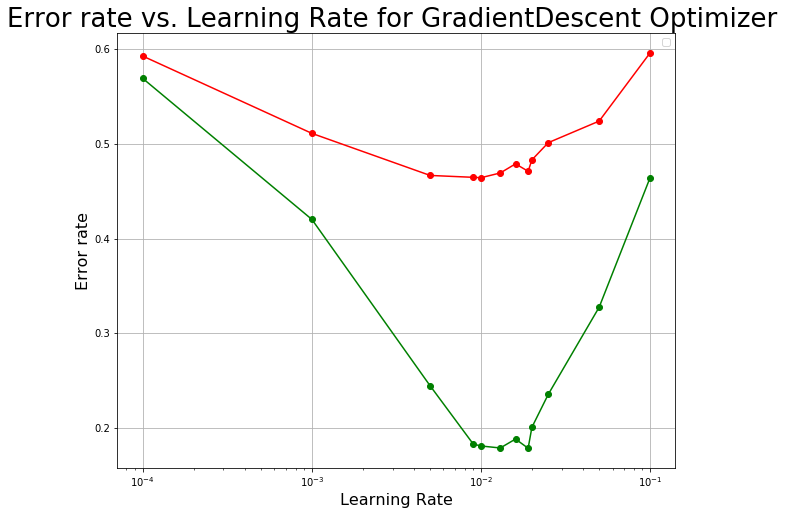

In [0]:
#Drawing error rate vs learning rate for GradientDescent optimizer
plt.figure(figsize = (10,8))
plt.semilogx(lr_size_list_gd, Train_error_list_gd, 'go-')
plt.semilogx(lr_size_list_gd, Val_error_list_gd, 'ro-')
plt.xlabel('Learning Rate',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Error rate vs. Learning Rate for GradientDescent Optimizer ', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./performance_gd.png')

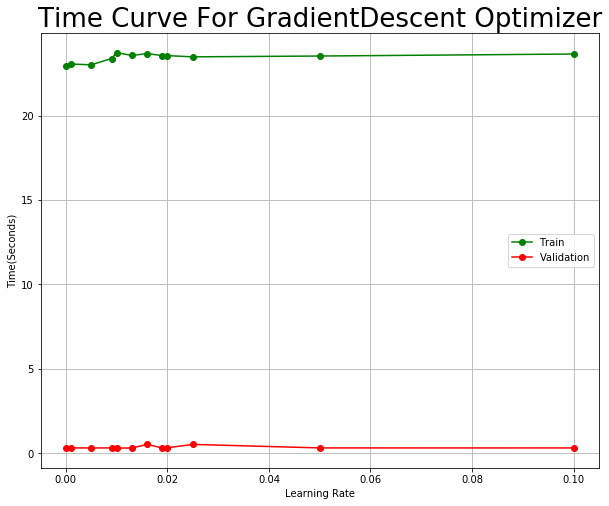

In [0]:
#Drawing train/val time v.s. training set for GradientDescent optimizer for different learning rate

plt.figure(figsize = (10,8))
plt.plot(lr_size_list_gd, Train_time_list_gd, 'go-', label = "Train")
plt.plot(lr_size_list_gd, Val_time_list_gd, 'ro-', label = "Validation")
plt.xlabel('Learning Rate')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For GradientDescent Optimizer', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_gd.png')

## Momentum Optimizer with Different Learning Rates

In [0]:
lr_size_list_mo = []
Train_error_list_mo = []
Val_error_list_mo = []
Train_time_list_mo = []
Val_time_list_mo = []
batch_size = 50 # fixed batch size
#lr = 0.001 # fixed learning rate
num_epoch = 10 # total number of epoch 
epoch = len(X_train_ft_sc)/batch_size # number of steps in one epoch

for j in [0.025,0.01,0.006,0.005,0.004,0.003,0.002,0.001,0.0001,0.00001]:

    #### Appending number of learning rate                                                                               
    lr_size_list_mo.append(j)
                                                                                    
    print('LearningRate_set_size:', j)
    
    
    #### Model building
    
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= None)
                                  # model_dir="./models/dnn_clf_/mo")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
    
    dnn_clf_mo = tf.contrib.learn.DNNClassifier(hidden_units = [8000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.MomentumOptimizer(learning_rate=j,
                                                                                              momentum = 0.6),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_mo = tf.contrib.learn.SKCompat(dnn_clf_mo) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_mo.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_mo.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_mo.predict(X_train_ft_sc) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train, y_train_partial_pred['classes'])# training error
    
    Train_error_list_mo.append(Train_error)#append training error
    
    print('dnn_clf_mo training time', Train_elapse) 
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_mo.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_mo.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_mo.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                       
    
print("Learning Rate_size_list_MomentumOptimizer: ", lr_size_list_mo)
print("Train_error_list_MomentumOptimizer: ", Train_error_list_mo)
print("Val_error_list_MomentumOptimizer: ", Val_error_list_mo)
print("Train_time_list_MomentumOptimizer: ", Train_time_list_mo)
print("Val_time_list_MomentumOptimizer: ", Val_time_list_mo)  

('LearningRate_set_size:', 0.025)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe5ec357390>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpP2kdXb', '_tf_random_seed': 26, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpP2kdXb/model.ckpt.


INFO:tensorflow:global_step/sec: 348.595
INFO:tensorflow:loss = 1.1756665, step = 7300 (0.287 sec)
INFO:tensorflow:global_step/sec: 349.584
INFO:tensorflow:loss = 1.0568452, step = 7400 (0.286 sec)
INFO:tensorflow:global_step/sec: 349.045
INFO:tensorflow:loss = 1.2251296, step = 7500 (0.286 sec)
INFO:tensorflow:global_step/sec: 350.045
INFO:tensorflow:loss = 1.0890801, step = 7600 (0.286 sec)
INFO:tensorflow:global_step/sec: 350.428
INFO:tensorflow:loss = 1.411578, step = 7700 (0.286 sec)
INFO:tensorflow:global_step/sec: 344.273
INFO:tensorflow:loss = 0.99533826, step = 7800 (0.290 sec)
INFO:tensorflow:global_step/sec: 344.685
INFO:tensorflow:loss = 0.94561064, step = 7900 (0.290 sec)
INFO:tensorflow:global_step/sec: 344.315
INFO:tensorflow:loss = 1.478375, step = 8000 (0.291 sec)
INFO:tensorflow:global_step/sec: 342.39
INFO:tensorflow:loss = 1.6298927, step = 8100 (0.292 sec)
INFO:tensorflow:global_step/sec: 345.367
INFO:tensorflow:loss = 1.2990384, step = 8200 (0.290 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 355.936
INFO:tensorflow:loss = 0.7165462, step = 5000 (0.281 sec)
INFO:tensorflow:global_step/sec: 355.195
INFO:tensorflow:loss = 1.0440929, step = 5100 (0.281 sec)
INFO:tensorflow:global_step/sec: 354.963
INFO:tensorflow:loss = 0.81107354, step = 5200 (0.282 sec)
INFO:tensorflow:global_step/sec: 353.908
INFO:tensorflow:loss = 0.9889786, step = 5300 (0.282 sec)
INFO:tensorflow:global_step/sec: 351.09
INFO:tensorflow:loss = 0.670412, step = 5400 (0.285 sec)
INFO:tensorflow:global_step/sec: 352.089
INFO:tensorflow:loss = 0.6183742, step = 5500 (0.284 sec)
INFO:tensorflow:global_step/sec: 355.792
INFO:tensorflow:loss = 1.007595, step = 5600 (0.281 sec)
INFO:tensorflow:global_step/sec: 352.291
INFO:tensorflow:loss = 1.1486104, step = 5700 (0.283 sec)
INFO:tensorflow:global_step/sec: 355.815
INFO:tensorflow:loss = 0.83328307, step = 5800 (0.282 sec)
INFO:tensorflow:global_step/sec: 352.575
INFO:tensorflow:loss = 0.7132715, step = 5900 (0.283 sec)
INFO:tensor

INFO:tensorflow:loss = 1.158335, step = 2600 (0.281 sec)
INFO:tensorflow:global_step/sec: 355.596
INFO:tensorflow:loss = 1.0035478, step = 2700 (0.281 sec)
INFO:tensorflow:global_step/sec: 357.3
INFO:tensorflow:loss = 1.1637425, step = 2800 (0.280 sec)
INFO:tensorflow:global_step/sec: 357.143
INFO:tensorflow:loss = 1.0002339, step = 2900 (0.280 sec)
INFO:tensorflow:global_step/sec: 356.682
INFO:tensorflow:loss = 1.080782, step = 3000 (0.280 sec)
INFO:tensorflow:global_step/sec: 356.447
INFO:tensorflow:loss = 0.95892394, step = 3100 (0.281 sec)
INFO:tensorflow:global_step/sec: 356.156
INFO:tensorflow:loss = 1.1578068, step = 3200 (0.280 sec)
INFO:tensorflow:global_step/sec: 354.462
INFO:tensorflow:loss = 1.0433376, step = 3300 (0.282 sec)
INFO:tensorflow:global_step/sec: 356.019
INFO:tensorflow:loss = 1.0819185, step = 3400 (0.281 sec)
INFO:tensorflow:global_step/sec: 352.914
INFO:tensorflow:loss = 1.2742642, step = 3500 (0.283 sec)
INFO:tensorflow:global_step/sec: 355.139
INFO:tensorfl

INFO:tensorflow:global_step/sec: 345.858
INFO:tensorflow:loss = 1.7533613, step = 300 (0.289 sec)
INFO:tensorflow:global_step/sec: 346.07
INFO:tensorflow:loss = 1.5415653, step = 400 (0.289 sec)
INFO:tensorflow:global_step/sec: 340.533
INFO:tensorflow:loss = 1.4142315, step = 500 (0.294 sec)
INFO:tensorflow:global_step/sec: 342.631
INFO:tensorflow:loss = 1.3411008, step = 600 (0.292 sec)
INFO:tensorflow:global_step/sec: 346.304
INFO:tensorflow:loss = 1.6095417, step = 700 (0.288 sec)
INFO:tensorflow:global_step/sec: 345.54
INFO:tensorflow:loss = 1.492034, step = 800 (0.290 sec)
INFO:tensorflow:global_step/sec: 343.77
INFO:tensorflow:loss = 1.3486362, step = 900 (0.290 sec)
INFO:tensorflow:global_step/sec: 348.233
INFO:tensorflow:loss = 1.5876776, step = 1000 (0.288 sec)
INFO:tensorflow:global_step/sec: 348.938
INFO:tensorflow:loss = 1.0995587, step = 1100 (0.286 sec)
INFO:tensorflow:global_step/sec: 345.744
INFO:tensorflow:loss = 1.2363144, step = 1200 (0.289 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 343.197
INFO:tensorflow:loss = 0.6358496, step = 8600 (0.291 sec)
INFO:tensorflow:global_step/sec: 339.907
INFO:tensorflow:loss = 0.5077318, step = 8700 (0.294 sec)
INFO:tensorflow:global_step/sec: 343.384
INFO:tensorflow:loss = 0.8457867, step = 8800 (0.291 sec)
INFO:tensorflow:global_step/sec: 344.256
INFO:tensorflow:loss = 0.6533978, step = 8900 (0.290 sec)
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmpsOYu2v/model.ckpt.
INFO:tensorflow:Loss for final step: 0.5589182.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsOYu2v/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('dnn_clf_mo training time', 27.576414)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsOYu2v/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Train error, Val_error', 0.14355555555555555, '/', 0

INFO:tensorflow:loss = 0.7565367, step = 6200 (0.284 sec)
INFO:tensorflow:global_step/sec: 351.228
INFO:tensorflow:loss = 0.7660897, step = 6300 (0.285 sec)
INFO:tensorflow:global_step/sec: 347.889
INFO:tensorflow:loss = 0.78875947, step = 6400 (0.287 sec)
INFO:tensorflow:global_step/sec: 349.567
INFO:tensorflow:loss = 1.0142027, step = 6500 (0.286 sec)
INFO:tensorflow:global_step/sec: 350.195
INFO:tensorflow:loss = 0.80099106, step = 6600 (0.285 sec)
INFO:tensorflow:global_step/sec: 352.694
INFO:tensorflow:loss = 0.8133534, step = 6700 (0.284 sec)
INFO:tensorflow:global_step/sec: 355.355
INFO:tensorflow:loss = 0.9235962, step = 6800 (0.281 sec)
INFO:tensorflow:global_step/sec: 354.294
INFO:tensorflow:loss = 0.6029436, step = 6900 (0.283 sec)
INFO:tensorflow:global_step/sec: 352.965
INFO:tensorflow:loss = 0.8287953, step = 7000 (0.283 sec)
INFO:tensorflow:global_step/sec: 354.638
INFO:tensorflow:loss = 0.941425, step = 7100 (0.282 sec)
INFO:tensorflow:global_step/sec: 349.099
INFO:tens

INFO:tensorflow:global_step/sec: 350.108
INFO:tensorflow:loss = 0.98832506, step = 3900 (0.285 sec)
INFO:tensorflow:global_step/sec: 355.54
INFO:tensorflow:loss = 1.0950022, step = 4000 (0.282 sec)
INFO:tensorflow:global_step/sec: 354.365
INFO:tensorflow:loss = 0.9280989, step = 4100 (0.282 sec)
INFO:tensorflow:global_step/sec: 356.991
INFO:tensorflow:loss = 1.0899669, step = 4200 (0.280 sec)
INFO:tensorflow:global_step/sec: 353.298
INFO:tensorflow:loss = 0.910048, step = 4300 (0.284 sec)
INFO:tensorflow:global_step/sec: 349.136
INFO:tensorflow:loss = 1.2112765, step = 4400 (0.286 sec)
INFO:tensorflow:global_step/sec: 352.194
INFO:tensorflow:loss = 1.0815884, step = 4500 (0.284 sec)
INFO:tensorflow:global_step/sec: 350.639
INFO:tensorflow:loss = 1.0134246, step = 4600 (0.285 sec)
INFO:tensorflow:global_step/sec: 355.211
INFO:tensorflow:loss = 0.99657714, step = 4700 (0.281 sec)
INFO:tensorflow:global_step/sec: 353.182
INFO:tensorflow:loss = 0.8883171, step = 4800 (0.283 sec)
INFO:tenso

INFO:tensorflow:loss = 1.3187424, step = 1500 (0.282 sec)
INFO:tensorflow:global_step/sec: 356.932
INFO:tensorflow:loss = 1.390072, step = 1600 (0.279 sec)
INFO:tensorflow:global_step/sec: 355.864
INFO:tensorflow:loss = 1.2983956, step = 1700 (0.282 sec)
INFO:tensorflow:global_step/sec: 354.388
INFO:tensorflow:loss = 1.4436433, step = 1800 (0.282 sec)
INFO:tensorflow:global_step/sec: 354.83
INFO:tensorflow:loss = 1.2271351, step = 1900 (0.281 sec)
INFO:tensorflow:global_step/sec: 355.102
INFO:tensorflow:loss = 1.2922118, step = 2000 (0.282 sec)
INFO:tensorflow:global_step/sec: 357.452
INFO:tensorflow:loss = 1.2019769, step = 2100 (0.280 sec)
INFO:tensorflow:global_step/sec: 356.175
INFO:tensorflow:loss = 1.2775528, step = 2200 (0.280 sec)
INFO:tensorflow:global_step/sec: 354.135
INFO:tensorflow:loss = 1.3944162, step = 2300 (0.283 sec)
INFO:tensorflow:global_step/sec: 354.757
INFO:tensorflow:loss = 1.7523803, step = 2400 (0.282 sec)
INFO:tensorflow:global_step/sec: 350.007
INFO:tensorf

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpS29Vch/model.ckpt.
INFO:tensorflow:loss = 2.5952237, step = 0
INFO:tensorflow:global_step/sec: 322.696
INFO:tensorflow:loss = 1.7440895, step = 100 (0.312 sec)
INFO:tensorflow:global_step/sec: 353.185
INFO:tensorflow:loss = 1.6928462, step = 200 (0.283 sec)
INFO:tensorflow:global_step/sec: 352.264
INFO:tensorflow:loss = 1.6431996, step = 300 (0.284 sec)
INFO:tensorflow:global_step/sec: 351.496
INFO:tensorflow:loss = 1.6005774, step = 400 (0.285 sec)
INFO:tensorflow:global_step/sec: 351.984
INFO:tensorflow:loss = 1.4763293, step = 500 (0.284 sec)
INFO:tensorflow:global_step/sec: 353.006
INFO:tensorflow:loss = 1.434863, step = 600 (0.283 sec)
INFO:tensorflow:global_step/sec: 353.212
INFO:tensorflow:loss = 1.5443109, step = 700 (0.283 sec)
INFO:tensorflow:global_step/sec: 35

INFO:tensorflow:loss = 0.8367395, step = 8100 (0.280 sec)
INFO:tensorflow:global_step/sec: 358.526
INFO:tensorflow:loss = 0.9815774, step = 8200 (0.279 sec)
INFO:tensorflow:global_step/sec: 356.936
INFO:tensorflow:loss = 1.2072504, step = 8300 (0.280 sec)
INFO:tensorflow:global_step/sec: 357.773
INFO:tensorflow:loss = 1.0698344, step = 8400 (0.279 sec)
INFO:tensorflow:global_step/sec: 357.135
INFO:tensorflow:loss = 0.8581093, step = 8500 (0.280 sec)
INFO:tensorflow:global_step/sec: 356.828
INFO:tensorflow:loss = 1.1373074, step = 8600 (0.280 sec)
INFO:tensorflow:global_step/sec: 357.619
INFO:tensorflow:loss = 0.9618381, step = 8700 (0.280 sec)
INFO:tensorflow:global_step/sec: 353.119
INFO:tensorflow:loss = 1.241161, step = 8800 (0.284 sec)
INFO:tensorflow:global_step/sec: 350.876
INFO:tensorflow:loss = 1.1458772, step = 8900 (0.285 sec)
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmpS29Vch/model.ckpt.
INFO:tensorflow:Loss for final step: 1.1215324.
INFO:tensorflow:Graph was f

INFO:tensorflow:global_step/sec: 354.983
INFO:tensorflow:loss = 1.4419342, step = 5800 (0.281 sec)
INFO:tensorflow:global_step/sec: 352.371
INFO:tensorflow:loss = 1.4836469, step = 5900 (0.284 sec)
INFO:tensorflow:global_step/sec: 351.698
INFO:tensorflow:loss = 1.7721997, step = 6000 (0.284 sec)
INFO:tensorflow:global_step/sec: 355.697
INFO:tensorflow:loss = 1.3932846, step = 6100 (0.282 sec)
INFO:tensorflow:global_step/sec: 353.832
INFO:tensorflow:loss = 1.5207895, step = 6200 (0.282 sec)
INFO:tensorflow:global_step/sec: 346.186
INFO:tensorflow:loss = 1.4470215, step = 6300 (0.289 sec)
INFO:tensorflow:global_step/sec: 350.032
INFO:tensorflow:loss = 1.5466623, step = 6400 (0.286 sec)
INFO:tensorflow:global_step/sec: 351.248
INFO:tensorflow:loss = 1.6130222, step = 6500 (0.284 sec)
INFO:tensorflow:global_step/sec: 351.799
INFO:tensorflow:loss = 1.6253428, step = 6600 (0.284 sec)
INFO:tensorflow:global_step/sec: 351.625
INFO:tensorflow:loss = 1.566264, step = 6700 (0.284 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 350.204
INFO:tensorflow:loss = 2.0434346, step = 3500 (0.286 sec)
INFO:tensorflow:global_step/sec: 354.552
INFO:tensorflow:loss = 1.9338483, step = 3600 (0.282 sec)
INFO:tensorflow:global_step/sec: 355.401
INFO:tensorflow:loss = 2.0095336, step = 3700 (0.281 sec)
INFO:tensorflow:global_step/sec: 357.134
INFO:tensorflow:loss = 2.139186, step = 3800 (0.280 sec)
INFO:tensorflow:global_step/sec: 358.342
INFO:tensorflow:loss = 1.8517834, step = 3900 (0.279 sec)
INFO:tensorflow:global_step/sec: 357.353
INFO:tensorflow:loss = 1.830669, step = 4000 (0.280 sec)
INFO:tensorflow:global_step/sec: 356.676
INFO:tensorflow:loss = 1.7653472, step = 4100 (0.281 sec)
INFO:tensorflow:global_step/sec: 352.412
INFO:tensorflow:loss = 1.989072, step = 4200 (0.284 sec)
INFO:tensorflow:global_step/sec: 350.057
INFO:tensorflow:loss = 1.9423043, step = 4300 (0.286 sec)
INFO:tensorflow:global_step/sec: 349.398
INFO:tensorflow:loss = 1.9047552, step = 4400 (0.286 sec)
INFO:tensorfl

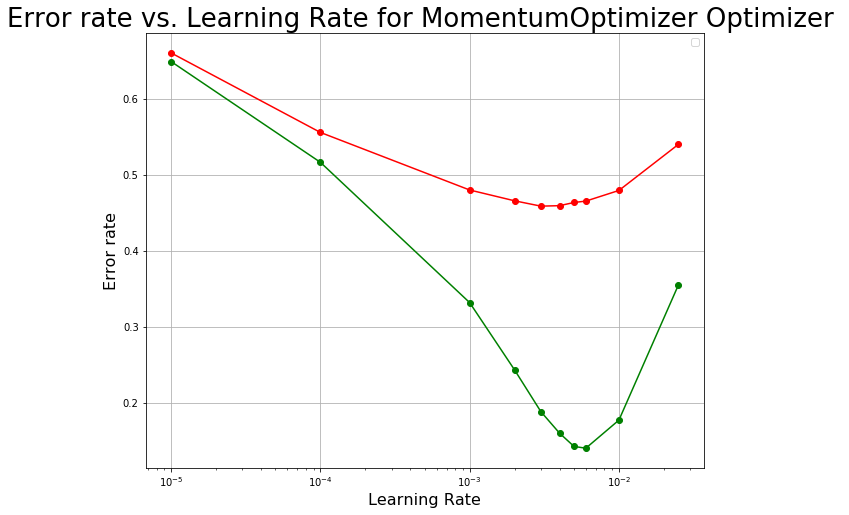

In [0]:
#Drawing error rate vs learning rate for MomentumOptimizer optimizer
plt.figure(figsize = (10,8))
plt.semilogx(lr_size_list_mo, Train_error_list_mo, 'go-')
plt.semilogx(lr_size_list_mo, Val_error_list_mo, 'ro-')
plt.xlabel('Learning Rate',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Error rate vs. Learning Rate for MomentumOptimizer Optimizer ', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./performance_mo.png')

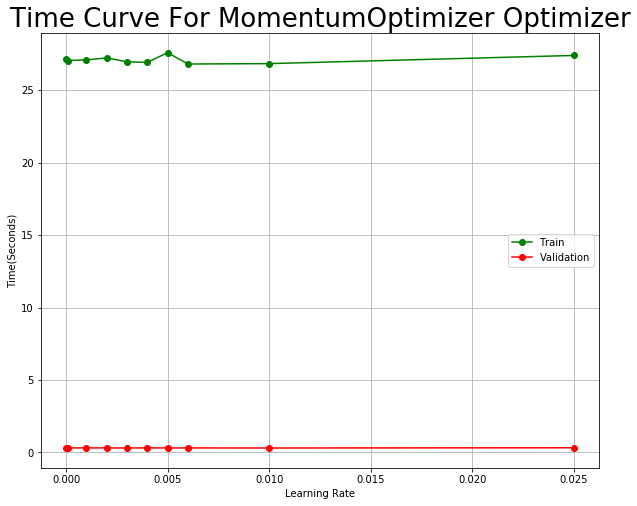

In [0]:
#Drawing train/val time v.s. training set for MomentumOptimizer optimizer for different learning rate

plt.figure(figsize = (10,8))
plt.plot(lr_size_list_mo, Train_time_list_mo, 'go-', label = "Train")
plt.plot(lr_size_list_mo, Val_time_list_mo, 'ro-', label = "Validation")
plt.xlabel('Learning Rate')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For MomentumOptimizer Optimizer', fontsize=26)
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_mo.png')

## Comparison of Optimizer's Performance

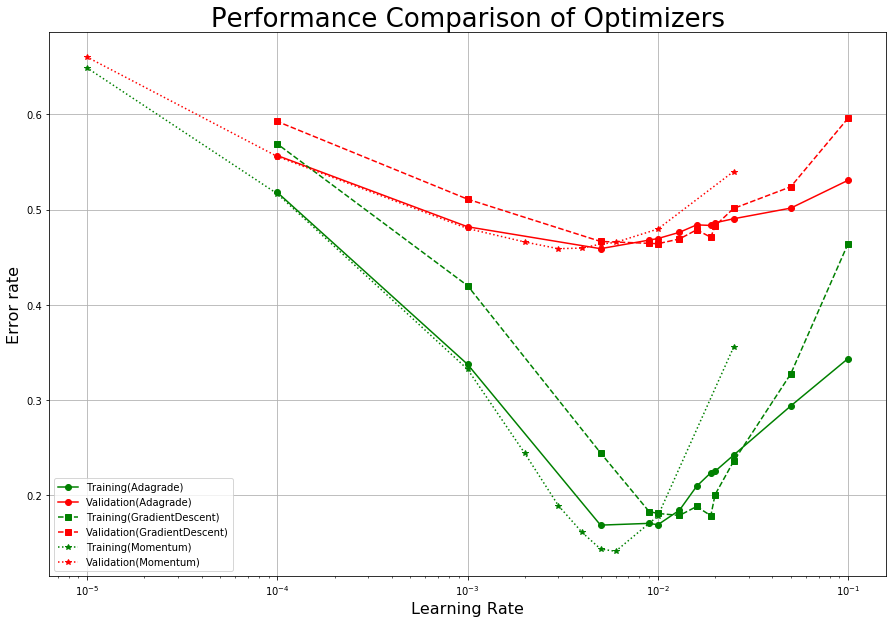

In [0]:
#ag, gd, mo
#Drawing performances of different optimizers
plt.figure(figsize = (15,10))
plt.semilogx(lr_size_list_ag, Train_error_list_ag, 'go-', label = "Training(Adagrade)")
plt.semilogx(lr_size_list_ag, Val_error_list_ag, 'ro-', label = "Validation(Adagrade)")
plt.semilogx(lr_size_list_gd, Train_error_list_gd, 'gs--', label = "Training(GradientDescent)")
plt.semilogx(lr_size_list_gd, Val_error_list_gd, 'rs--', label = "Validation(GradientDescent)") 
plt.semilogx(lr_size_list_mo, Train_error_list_mo, 'g*:', label = "Training(Momentum)")
plt.semilogx(lr_size_list_mo, Val_error_list_mo, 'r*:', label = "Validation(Momentum)")

plt.xlabel('Learning Rate',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.legend( fontsize=10)
plt.title('Performance Comparison of Optimizers', fontsize=26)
plt.grid(True)
plt.savefig('./performance_comp_opt.png')

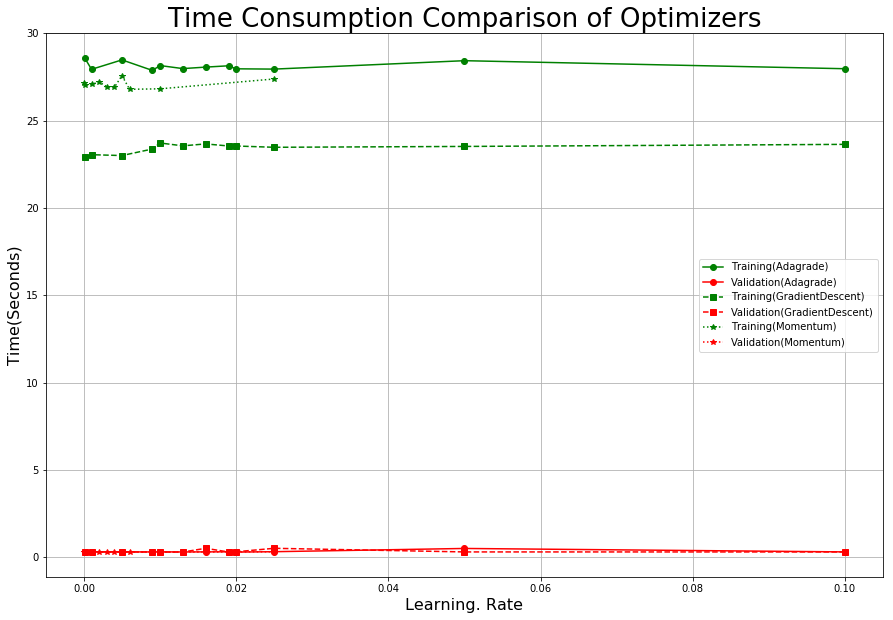

In [0]:
#Drawing time comparison plot for different optimizers
#Drawing train/val time v.s. training set
plt.figure(figsize = (15,10))
plt.plot(lr_size_list_ag, Train_time_list_ag, 'go-', label = "Training(Adagrade)")
plt.plot(lr_size_list_ag, Val_time_list_ag, 'ro-', label = "Validation(Adagrade)")
plt.plot(lr_size_list_gd, Train_time_list_gd, 'gs--', label = "Training(GradientDescent)")
plt.plot(lr_size_list_gd, Val_time_list_gd, 'rs--', label = "Validation(GradientDescent)") 
plt.plot(lr_size_list_mo, Train_time_list_mo, 'g*:', label = "Training(Momentum)")
plt.plot(lr_size_list_mo, Val_time_list_mo, 'r*:', label = "Validation(Momentum)")


plt.xlabel('Learning. Rate',fontsize=16)
plt.ylabel('Time(Seconds)',fontsize=16)
plt.legend( fontsize=10)
plt.title('Time Consumption Comparison of Optimizers', fontsize=26)
plt.grid(True)
plt.savefig('./time_comp_opt.png')

In [0]:
#Best Model
#Performance of Standerd Scaler Scaled data
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.005
num_epoch = 15 # total number of epoch 
config = tf.contrib.learn.RunConfig(tf_random_seed=32,
                                   save_checkpoints_steps= None)
                                   #model_dir="./models/initial/cifar10_4") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
dnn_clf_bst = tf.contrib.learn.DNNClassifier(hidden_units = [4000,4000,4000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

dnn_clf_bst = tf.contrib.learn.SKCompat(dnn_clf_bst) # to be compatible with sklearn
dnn_clf_bst.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=epoch*num_epoch) 
y_valid_pred = dnn_clf_bst.predict(X_valid_ft_sc)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd24e981f50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmptur4C1', '_tf_random_seed': 32, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmptur4C1/model.ckpt.
INFO:tensorflow:loss = 2.402766, s

INFO:tensorflow:global_step/sec: 218.131
INFO:tensorflow:loss = 0.29454696, step = 7300 (0.459 sec)
INFO:tensorflow:global_step/sec: 217.575
INFO:tensorflow:loss = 0.42688966, step = 7400 (0.459 sec)
INFO:tensorflow:global_step/sec: 218.255
INFO:tensorflow:loss = 0.3643351, step = 7500 (0.458 sec)
INFO:tensorflow:global_step/sec: 219.096
INFO:tensorflow:loss = 0.41164455, step = 7600 (0.456 sec)
INFO:tensorflow:global_step/sec: 217.696
INFO:tensorflow:loss = 0.3717659, step = 7700 (0.459 sec)
INFO:tensorflow:global_step/sec: 216.827
INFO:tensorflow:loss = 0.20468952, step = 7800 (0.461 sec)
INFO:tensorflow:global_step/sec: 216.784
INFO:tensorflow:loss = 0.3652333, step = 7900 (0.461 sec)
INFO:tensorflow:global_step/sec: 216.799
INFO:tensorflow:loss = 0.53438145, step = 8000 (0.461 sec)
INFO:tensorflow:global_step/sec: 217.616
INFO:tensorflow:loss = 0.24037987, step = 8100 (0.460 sec)
INFO:tensorflow:global_step/sec: 218.645
INFO:tensorflow:loss = 0.32160088, step = 8200 (0.457 sec)
INF

0.5618

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(X_train)
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.005
num_epoch = 10 # total number of epoch 
config = tf.contrib.learn.RunConfig(tf_random_seed=42,
                                   save_checkpoints_steps= 1100,
                                   model_dir="./models/initial/cifar10_3") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft_sc)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [4000,2000,4000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir="./models/initial/cifar10_3",
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # to be compatible with sklearn

# here's a more "manual" example
for e in range(num_epoch):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size):
        X_train_ft1 = X_train.flatten().reshape(45000,-1)
        X_train_ft1_sc = scaler.fit_transform(X_train_ft1)
        dnn_clf.fit(X_train_ft1_sc, y_train, batch_size=batch_size, steps=1100)
        #break
        batches += 1
        if batches >= 5:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

 
y_valid_pred = dnn_clf.predict(X_valid_ft_sc)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6a46abbd0>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': 42, '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_num_ps_replicas': 0, '_train_distribute': None, '_is_chief': True, '_model_dir': './models/initial/cifar10_3', '_protocol': None, '_save_checkpoints_steps': 1100, '_environment': 'local', '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_summary_steps': 100}
('Epoch', 0)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-55000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init

INFO:tensorflow:loss = 0.222406, step = 60400 (0.356 sec)
INFO:tensorflow:Saving checkpoints for 60500 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.18255869.
('Epoch', 1)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-60500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 60500 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:loss = 0.36272293, step = 60500
INFO:tensorflow:global_step/sec: 249.505
INFO:tensorflow:loss = 0.31399783, step = 60600 (0.402 sec)
INFO:tensorflow:global_step/sec: 281.777
INFO:tensorflow:loss = 0.15357326, step = 60700 (0.355 sec)
INFO:tensorflow:global_step/sec: 279.605
INFO:tensorflow:loss = 0.21749294, step = 60800 (0.358 sec)
INFO:tensorflow:global_step/sec: 280.645
INFO:tensorflow:loss = 0.30308494, step = 60900 (0.356 sec)


INFO:tensorflow:loss = 0.2970278, step = 66000
INFO:tensorflow:global_step/sec: 249.705
INFO:tensorflow:loss = 0.25368568, step = 66100 (0.402 sec)
INFO:tensorflow:global_step/sec: 276.748
INFO:tensorflow:loss = 0.12426153, step = 66200 (0.362 sec)
INFO:tensorflow:global_step/sec: 280.612
INFO:tensorflow:loss = 0.15989801, step = 66300 (0.356 sec)
INFO:tensorflow:global_step/sec: 278.354
INFO:tensorflow:loss = 0.27015075, step = 66400 (0.360 sec)
INFO:tensorflow:global_step/sec: 278.172
INFO:tensorflow:loss = 0.17796634, step = 66500 (0.359 sec)
INFO:tensorflow:global_step/sec: 279.708
INFO:tensorflow:loss = 0.1651495, step = 66600 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.817
INFO:tensorflow:loss = 0.23812312, step = 66700 (0.357 sec)
INFO:tensorflow:global_step/sec: 279.334
INFO:tensorflow:loss = 0.23819551, step = 66800 (0.358 sec)
INFO:tensorflow:global_step/sec: 280.032
INFO:tensorflow:loss = 0.17608623, step = 66900 (0.357 sec)
INFO:tensorflow:global_step/sec: 280.604
INFO

INFO:tensorflow:global_step/sec: 285.214
INFO:tensorflow:loss = 0.10594679, step = 72100 (0.351 sec)
INFO:tensorflow:global_step/sec: 285.113
INFO:tensorflow:loss = 0.20757411, step = 72200 (0.351 sec)
INFO:tensorflow:global_step/sec: 284.2
INFO:tensorflow:loss = 0.20693159, step = 72300 (0.352 sec)
INFO:tensorflow:global_step/sec: 284.299
INFO:tensorflow:loss = 0.16074015, step = 72400 (0.352 sec)
INFO:tensorflow:global_step/sec: 285.619
INFO:tensorflow:loss = 0.122964725, step = 72500 (0.350 sec)
INFO:tensorflow:Saving checkpoints for 72600 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.11760044.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-72600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 72600 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:los

INFO:tensorflow:Loss for final step: 0.11829393.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-78100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 78100 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:loss = 0.13998769, step = 78100
INFO:tensorflow:global_step/sec: 251.837
INFO:tensorflow:loss = 0.14905106, step = 78200 (0.399 sec)
INFO:tensorflow:global_step/sec: 284.189
INFO:tensorflow:loss = 0.06471075, step = 78300 (0.351 sec)
INFO:tensorflow:global_step/sec: 283.309
INFO:tensorflow:loss = 0.10008158, step = 78400 (0.354 sec)
INFO:tensorflow:global_step/sec: 283.468
INFO:tensorflow:loss = 0.17858575, step = 78500 (0.352 sec)
INFO:tensorflow:global_step/sec: 280.206
INFO:tensorflow:loss = 0.10559931, step = 78600 (0.357 sec)
INFO:tensorflow:global_step/sec: 284.394
INFO:tensorflow:lo

INFO:tensorflow:global_step/sec: 280.052
INFO:tensorflow:loss = 0.049321163, step = 83800 (0.358 sec)
INFO:tensorflow:global_step/sec: 275.431
INFO:tensorflow:loss = 0.059408523, step = 83900 (0.362 sec)
INFO:tensorflow:global_step/sec: 281.064
INFO:tensorflow:loss = 0.14467591, step = 84000 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.876
INFO:tensorflow:loss = 0.10136154, step = 84100 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.962
INFO:tensorflow:loss = 0.0847953, step = 84200 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.038
INFO:tensorflow:loss = 0.13428843, step = 84300 (0.357 sec)
INFO:tensorflow:global_step/sec: 281.473
INFO:tensorflow:loss = 0.075394504, step = 84400 (0.355 sec)
INFO:tensorflow:global_step/sec: 281.655
INFO:tensorflow:loss = 0.13016582, step = 84500 (0.355 sec)
INFO:tensorflow:global_step/sec: 277.918
INFO:tensorflow:loss = 0.05647828, step = 84600 (0.360 sec)
INFO:tensorflow:Saving checkpoints for 84700 into ./models/initial/cifar10_3/model.ckpt.


INFO:tensorflow:global_step/sec: 279.471
INFO:tensorflow:loss = 0.08245884, step = 89800 (0.358 sec)
INFO:tensorflow:global_step/sec: 283.28
INFO:tensorflow:loss = 0.062048387, step = 89900 (0.353 sec)
INFO:tensorflow:global_step/sec: 281.801
INFO:tensorflow:loss = 0.10646477, step = 90000 (0.355 sec)
INFO:tensorflow:global_step/sec: 282.69
INFO:tensorflow:loss = 0.036026746, step = 90100 (0.354 sec)
INFO:tensorflow:Saving checkpoints for 90200 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.08851831.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-90200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 90200 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:loss = 0.106983855, step = 90200
INFO:tensorflow:global_step/sec: 249.827
INFO:tensorflow:loss = 0.0716

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-95700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 95700 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:loss = 0.10915401, step = 95700
INFO:tensorflow:global_step/sec: 246.438
INFO:tensorflow:loss = 0.08447506, step = 95800 (0.407 sec)
INFO:tensorflow:global_step/sec: 278.132
INFO:tensorflow:loss = 0.045270108, step = 95900 (0.360 sec)
INFO:tensorflow:global_step/sec: 279.58
INFO:tensorflow:loss = 0.035444576, step = 96000 (0.358 sec)
INFO:tensorflow:global_step/sec: 276.471
INFO:tensorflow:loss = 0.097209424, step = 96100 (0.362 sec)
INFO:tensorflow:global_step/sec: 278.409
INFO:tensorflow:loss = 0.091158725, step = 96200 (0.359 sec)
INFO:tensorflow:global_step/sec: 279.761
INFO:tensorflow:loss = 0.07043366, step = 96300 (0.358 sec)
INFO

INFO:tensorflow:global_step/sec: 282.169
INFO:tensorflow:loss = 0.023943214, step = 101400 (0.354 sec)
INFO:tensorflow:global_step/sec: 281.906
INFO:tensorflow:loss = 0.021975562, step = 101500 (0.354 sec)
INFO:tensorflow:global_step/sec: 282.976
INFO:tensorflow:loss = 0.070287086, step = 101600 (0.354 sec)
INFO:tensorflow:global_step/sec: 283.867
INFO:tensorflow:loss = 0.10248233, step = 101700 (0.352 sec)
INFO:tensorflow:global_step/sec: 285.275
INFO:tensorflow:loss = 0.059654072, step = 101800 (0.351 sec)
INFO:tensorflow:global_step/sec: 285.614
INFO:tensorflow:loss = 0.06321737, step = 101900 (0.350 sec)
INFO:tensorflow:global_step/sec: 285.361
INFO:tensorflow:loss = 0.044651538, step = 102000 (0.351 sec)
INFO:tensorflow:global_step/sec: 282.836
INFO:tensorflow:loss = 0.13399488, step = 102100 (0.353 sec)
INFO:tensorflow:global_step/sec: 285.083
INFO:tensorflow:loss = 0.019704534, step = 102200 (0.351 sec)
INFO:tensorflow:Saving checkpoints for 102300 into ./models/initial/cifar10_

INFO:tensorflow:global_step/sec: 278.18
INFO:tensorflow:loss = 0.029937208, step = 107300 (0.360 sec)
INFO:tensorflow:global_step/sec: 276.544
INFO:tensorflow:loss = 0.04368762, step = 107400 (0.362 sec)
INFO:tensorflow:global_step/sec: 279.064
INFO:tensorflow:loss = 0.0314711, step = 107500 (0.358 sec)
INFO:tensorflow:global_step/sec: 278.725
INFO:tensorflow:loss = 0.12967537, step = 107600 (0.359 sec)
INFO:tensorflow:global_step/sec: 279.942
INFO:tensorflow:loss = 0.01806252, step = 107700 (0.358 sec)
INFO:tensorflow:Saving checkpoints for 107800 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.05378176.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-107800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 107800 into ./models/initial/cifar10_3/model.ckpt.
INFO:tensor

0.5096

In [0]:
y_valid_pred = dnn_clf.predict(X_valid_ft_sc)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-177500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.5178

# The final test accuracy

In [0]:
#Best Model's Performance (without augmentation)
y_test_pred = dnn_clf_bst.predict(X_test_ft_sc)
print(y_test_pred.keys())
accuracy_score(y_test, y_test_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptur4C1/model.ckpt-13500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.5633

In [0]:
#Best Model's Performance (with augmentation)
y_test_pred_ag = dnn_clf.predict(X_test_ft_sc)
print(y_test_pred_ag.keys())
accuracy_score(y_test, y_test_pred_ag['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/initial/cifar10_3/model.ckpt-177500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.5284

In [0]:
print(classification_report(y_test,y_test_pred['classes']))

             precision    recall  f1-score   support

          0       0.63      0.68      0.65      1000
          1       0.74      0.61      0.67      1000
          2       0.44      0.45      0.44      1000
          3       0.39      0.40      0.39      1000
          4       0.45      0.52      0.48      1000
          5       0.52      0.41      0.46      1000
          6       0.57      0.65      0.60      1000
          7       0.66      0.61      0.63      1000
          8       0.69      0.71      0.70      1000
          9       0.59      0.60      0.60      1000

avg / total       0.57      0.56      0.56     10000



In [0]:
conf_mx_DNN_1L = confusion_matrix(y_test, y_test_pred['classes'])

conf_mx_DNN_1L

array([[681,  15,  56,  11,  46,   9,  30,  14,  99,  39],
       [ 49, 606,  19,  21,  24,  13,  25,  11,  76, 156],
       [ 69,   7, 445,  81, 153,  52, 101,  53,  19,  20],
       [ 29,  14, 101, 399,  98, 143, 115,  42,  18,  41],
       [ 39,   4, 123,  65, 520,  41,  96,  78,  17,  17],
       [ 13,   3,  93, 231,  84, 408,  64,  62,  17,  25],
       [  9,  13,  62,  84,  98,  35, 646,  16,  12,  25],
       [ 38,   1,  58,  74,  84,  59,  22, 614,   6,  44],
       [ 96,  41,  24,  24,  27,  11,  11,  10, 712,  44],
       [ 65, 112,  23,  33,  22,  16,  30,  37,  60, 602]])

In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    


Normalized confusion matrix
[[0.681 0.015 0.056 0.011 0.046 0.009 0.03  0.014 0.099 0.039]
 [0.049 0.606 0.019 0.021 0.024 0.013 0.025 0.011 0.076 0.156]
 [0.069 0.007 0.445 0.081 0.153 0.052 0.101 0.053 0.019 0.02 ]
 [0.029 0.014 0.101 0.399 0.098 0.143 0.115 0.042 0.018 0.041]
 [0.039 0.004 0.123 0.065 0.52  0.041 0.096 0.078 0.017 0.017]
 [0.013 0.003 0.093 0.231 0.084 0.408 0.064 0.062 0.017 0.025]
 [0.009 0.013 0.062 0.084 0.098 0.035 0.646 0.016 0.012 0.025]
 [0.038 0.001 0.058 0.074 0.084 0.059 0.022 0.614 0.006 0.044]
 [0.096 0.041 0.024 0.024 0.027 0.011 0.011 0.01  0.712 0.044]
 [0.065 0.112 0.023 0.033 0.022 0.016 0.03  0.037 0.06  0.602]]


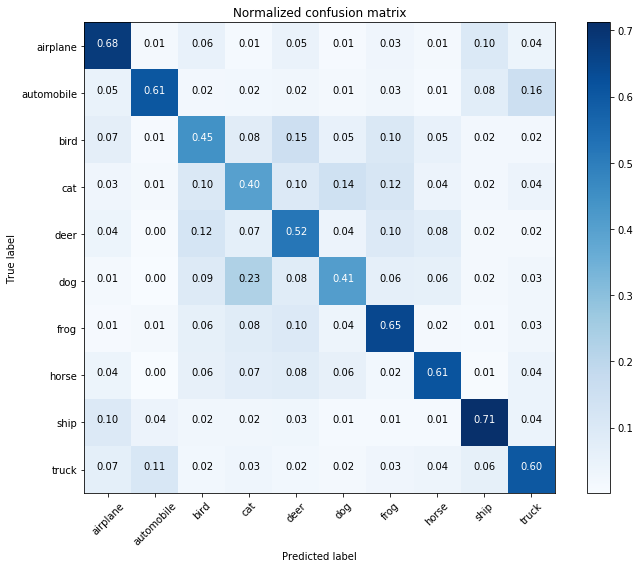

In [0]:

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(conf_mx_DNN_1L, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
plot_confusion_matrix(conf_mx_DNN_1L, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('./conf_mat_n.png')
plt.show()


Confusion matrix, without normalization
[[681  15  56  11  46   9  30  14  99  39]
 [ 49 606  19  21  24  13  25  11  76 156]
 [ 69   7 445  81 153  52 101  53  19  20]
 [ 29  14 101 399  98 143 115  42  18  41]
 [ 39   4 123  65 520  41  96  78  17  17]
 [ 13   3  93 231  84 408  64  62  17  25]
 [  9  13  62  84  98  35 646  16  12  25]
 [ 38   1  58  74  84  59  22 614   6  44]
 [ 96  41  24  24  27  11  11  10 712  44]
 [ 65 112  23  33  22  16  30  37  60 602]]


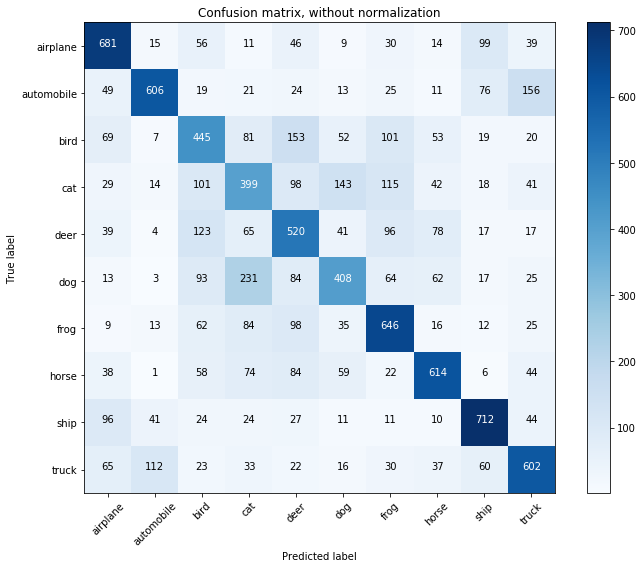

In [0]:
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(conf_mx_DNN_1L, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.savefig('./conf_mat_un.png')
plt.show()